In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pickle
from matplotlib.colors import LogNorm

sns.set_theme()
sns.set(font_scale = 0.9)

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# no text wrapping
display(HTML("<style>.dataframe td { white-space: nowrap; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.1f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

pd.set_option('display.max_colwidth', 200)

# Helper Functions

In [2]:
def range_to_average(string):
    """convert ranges to average of the top and bottom of the range"""
    if pd.isna(string):
        return pd.NA
    string = str(string).replace(' ', '')
    if string.replace('.', '', 1).isnumeric():
        return float(string)
    elif (x := string.split('-', 1)) == string.split('-'):
        if len(x) == 2:
            return float(float(x[0])+float(x[1]))/2
        else:
            # print('ERROR! Bad String: \"', string, '\"', sep='')  # debug
            return pd.NA
        
        
def print_unique(dataframe):
    for col in dataframe.columns:
        print()
        print(col)
        if dataframe[col].nunique() > 100:
            print('number of unique values:', dataframe[col].nunique())
        elif dataframe[col].dtype == '<M8[ns]':
            print(sorted(list(dataframe[col].astype(str).unique()), key=str))
        elif dataframe[col].dtype == float:
            print(sorted(list(dataframe[col].round(2).unique()), key=str))
        else:
            print(sorted(list(dataframe[col].unique()), key=str))


def types_of_data(series):
    numbers, strings, blanks, n_null = 0, 0, 0, 0
    for item in series:
        if pd.isnull(item):
            n_null += 1
        else:
            try:
                float(item)
                numbers += 1
            except (ValueError):
                strings += 1
                if str(item) == ' ' or str(item) == '':
                    blanks += 1           
    return numbers, strings, blanks, n_null


def print_data_info(dataframe, column):
    print('--------------------------------------------------\nData Info:', column.upper(), '\n')  
    numbers, strings, blanks, n_null = types_of_data(dataframe[column])  
    print('UNIQUE numbers, strings, blanks, null =', types_of_data(dataframe[column].unique()))
    print('number of numeric =', numbers)
    print('number of strings =', strings)
    print('number of blanks =', blanks)
    print('number of null = ', n_null)

    
def print_hist(dataframe, column, max_bins=100, colours=(0,9)):  
    print('\n--------------------------------------------------\nHistogram:', column.upper())   
    plt.figure(figsize=(10, 3))    
    n_unique = dataframe[column].nunique()
    
    if n_unique <= max_bins:
        bins = n_unique
    else:
        bins = max_bins  
    
    # if there are too many bins, rotate the text to make it readable
    if bins > 20:
        xrot = 90
    else:
        xrot = 0
        
    is_categorical = dataframe[column].dtype == 'object'
    if is_categorical:
        plot = dataframe[column].fillna('NA').astype(str).sort_values().value_counts().plot.bar(
            rot=90, color=sns.color_palette()[colours[1]], width=1
        )
        print('CATEGORICAL')
    else:
        plot = dataframe[column].hist(
            bins=bins, xrot=0, color=sns.color_palette()[colours[0]]
        )
        print('NUMERICAL')
    
    plot.yaxis.tick_right()
    plt.show()
    
    
def print_timeseries(dataframe, column, time_column, colours=(1,6)):
    print('\n------------------------------------------------\nTime Series:', column.upper(), sep='')
    plt.figure(figsize=(10, 3))
    
    try:
        plot = sns.lineplot(
            x = dataframe[time_column], 
            y = dataframe[column].astype(float),  # cast int to float or get ValueErrors with IQR (pi 50)
            errorbar = ('pi', 50),  # IQR
            color = sns.color_palette()[colours[0]]
        )
        print('NUMERICAL')
    except (ValueError, TypeError):  # categorical variables, can't cast to float
        plot = sns.lineplot(
            x = dataframe[time_column], 
            y = dataframe[column].astype(str).sort_values(),
            errorbar = ('pi', 50), 
            color = sns.color_palette()[colours[1]]
        )
        print('CATEGORICAL')  # NOTE: categorical variables treated as ordinal to make plotting possible, averages don't have meaning
        
    # plot.set_xlim(1957, 2022)  # show entire dataset time period for all plots
    plot.yaxis.tick_right()  # so all of the graphs align with eachother, regarless of text length
    plt.show()
    
    
def do_EDA_stuff(dataframe, column, date_column='YEAR'):
    print_data_info(dataframe, column)
    print_hist(dataframe, column)
    print_timeseries(dataframe, column, date_column)

# =============================================
# BIOLOGICAL DATA
# =============================================

In [3]:
df_gns = pd.read_excel(r'.\raw_data\GNS Efish_2006-2020_For DM App.xlsx', sheet_name='Biological Data')
df_gns.columns = [x.strip().replace(' ', '_').upper() for x in df_gns.columns]

df_mar = pd.read_excel(r'.\raw_data\Margaree Efish_1957-2020_For DM App.xlsx', sheet_name='Biological Data')
df_mar.columns = [x.strip().replace(' ', '_').upper() for x in df_mar.columns]

In [4]:
df_gns.dtypes

ID                   int64
YEAR               float64
SITE                object
RIVER_NAME          object
SWEEP_NUMBER       float64
SPECIES             object
ORIGIN              object
FISH_STATUS         object
FORK_LENGTH        float64
TOTAL_LENGTH       float64
WEIGHT              object
CATCH_FREQUENCY      int64
FISH_SIZE           object
RIVER_AGE          float64
AGE_TYPE            object
SEX                 object
MATURITY            object
SCALE_ID_NUMBER     object
COMMENTS            object
dtype: object

In [5]:
df_mar.dtypes

ID                              int64
YEAR                            int64
SITE                           object
CGNDB                          object
SWEEP_NUMBER                   object
SPECIES_ITIS_CODE             float64
SPECIES                        object
ORIGIN                         object
FISH_STATUS                    object
FORK_LENGTH                    object
FORK_LENGTH_INTERVAL_WIDTH     object
TOTAL_LENGTH                   object
WEIGHT                        float64
CATCH_FREQUENCY               float64
FISH_SIZE                      object
RIVER_AGE                     float64
AGE_TYPE                       object
SEX                            object
MATURITY                       object
SCALE_ID_NUMBER                object
COMMENTS                       object
dtype: object

# describe the data

In [6]:
df_gns.describe(include='all').T

count unique           top    freq   mean    std    min  \
ID              12895.0    NaN           NaN     NaN 6448.0 3722.6    1.0   
YEAR            12859.0    NaN           NaN     NaN 2013.6    4.3 2006.0   
SITE            12859.0   32.0           4.0  2420.0    NaN    NaN    NaN   
RIVER_NAME        12859     16  River Philip    4114    NaN    NaN    NaN   
SWEEP_NUMBER    12859.0    NaN           NaN     NaN    0.5    0.0    0.5   
SPECIES         12855.0   20.0        1731.0 10597.0    NaN    NaN    NaN   
ORIGIN             9964      2             W    9962    NaN    NaN    NaN   
FISH_STATUS       12859      6            RS   12616    NaN    NaN    NaN   
FORK_LENGTH     12776.0    NaN           NaN     NaN   66.2   21.4   13.5   
TOTAL_LENGTH        5.0    NaN           NaN     NaN  333.2  183.3   44.0   
WEIGHT            12650   2676           1.6      47    NaN    NaN    NaN   
CATCH_FREQUENCY 12895.0    NaN           NaN     NaN    1.2    3.3    1.0   
FISH_SIZE         10627      4           FRY    7675    NaN    NaN    NaN   
RIVER_AGE        6967.0    NaN           NaN     NaN    0.4    0.6    0.0   
AGE_TYPE            918      2         SCALE     916    NaN    NaN    NaN   
SEX                1882      2             U    1437    NaN    NaN    NaN   
MATURITY             23      1             P      23    NaN    NaN    NaN   
SCALE_ID_NUMBER     502    369         WR7-2       3    NaN    NaN    NaN   
COMMENTS            510     48    precocious     331    NaN    NaN    NaN   

                   25%    50%    75%     max  
ID              3224.5 6448.0 9671.5 12895.0  
YEAR            2010.0 2014.0 2017.0  2020.0  
SITE               NaN    NaN    NaN     NaN  
RIVER_NAME         NaN    NaN    NaN     NaN  
SWEEP_NUMBER       0.5    0.5    0.5     0.5  
SPECIES            NaN    NaN    NaN     NaN  
ORIGIN             NaN    NaN    NaN     NaN  
FISH_STATUS        NaN    NaN    NaN     NaN  
FORK_LENGTH       53.0   59.0   75.0   552.0  
TOTAL_LENGTH     325.0  325.0  442.0   530.0  
WEIGHT             NaN    NaN    NaN     NaN  
CATCH_FREQUENCY    1.0    1.0    1.0   163.0  
FISH_SIZE          NaN    NaN    NaN     NaN  
RIVER_AGE          0.0    0.0    1.0     2.0  
AGE_TYPE           NaN    NaN    NaN     NaN  
SEX                NaN    NaN    NaN     NaN  
MATURITY           NaN    NaN    NaN     NaN  
SCALE_ID_NUMBER    NaN    NaN    NaN     NaN  
COMMENTS           NaN    NaN    NaN     NaN

In [7]:
df_mar.describe(include='all').T

count unique        top    freq    mean     std  \
ID                         44472.0    NaN        NaN     NaN 22236.5 12838.1   
YEAR                       44472.0    NaN        NaN     NaN  1994.7    16.0   
SITE                       44472.0  115.0       51.0  5404.0     NaN     NaN   
CGNDB                         7941     10   Margaree    2727     NaN     NaN   
SWEEP_NUMBER               41612.0   11.0        0.5 16974.0     NaN     NaN   
SPECIES_ITIS_CODE              0.0    NaN        NaN     NaN     NaN     NaN   
SPECIES                    44472.0   23.0     1731.0 36774.0     NaN     NaN   
ORIGIN                       44472      3          W   43370     NaN     NaN   
FISH_STATUS                  41124      7         RS   36910     NaN     NaN   
FORK_LENGTH                35439.0  205.0       53.0   658.0     NaN     NaN   
FORK_LENGTH_INTERVAL_WIDTH  3637.0   27.0        1.0  3521.0     NaN     NaN   
TOTAL_LENGTH                5822.0  202.0        1.0   812.0     NaN     NaN   
WEIGHT                     24842.0    NaN        NaN     NaN     6.6    73.8   
CATCH_FREQUENCY            44465.0    NaN        NaN     NaN     2.9    11.7   
FISH_SIZE                    36719      6     SMPARR   15049     NaN     NaN   
RIVER_AGE                  35813.0    NaN        NaN     NaN     0.8     0.7   
AGE_TYPE                     11548      3   LGTHFREQ   10290     NaN     NaN   
SEX                           3088      3          M    1546     NaN     NaN   
MATURITY                        36      1          P      36     NaN     NaN   
SCALE_ID_NUMBER                835    728    M103C-4       2     NaN     NaN   
COMMENTS                      1081     72  spotcheck     781     NaN     NaN   

                              min     25%     50%     75%     max  
ID                            1.0 11118.8 22236.5 33354.2 44472.0  
YEAR                       1957.0  1986.0  1999.0  2005.0  2020.0  
SITE                          NaN     NaN     NaN     NaN     NaN  
CGNDB                         NaN     NaN     NaN     NaN     NaN  
SWEEP_NUMBER                  NaN     NaN     NaN     NaN     NaN  
SPECIES_ITIS_CODE             NaN     NaN     NaN     NaN     NaN  
SPECIES                       NaN     NaN     NaN     NaN     NaN  
ORIGIN                        NaN     NaN     NaN     NaN     NaN  
FISH_STATUS                   NaN     NaN     NaN     NaN     NaN  
FORK_LENGTH                   NaN     NaN     NaN     NaN     NaN  
FORK_LENGTH_INTERVAL_WIDTH    NaN     NaN     NaN     NaN     NaN  
TOTAL_LENGTH                  NaN     NaN     NaN     NaN     NaN  
WEIGHT                        0.1     1.8     4.0     8.6 11600.0  
CATCH_FREQUENCY               1.0     1.0     1.0     1.0   581.0  
FISH_SIZE                     NaN     NaN     NaN     NaN     NaN  
RIVER_AGE                     0.0     0.0     1.0     1.0     4.0  
AGE_TYPE                      NaN     NaN     NaN     NaN     NaN  
SEX                           NaN     NaN     NaN     NaN     NaN  
MATURITY                      NaN     NaN     NaN     NaN     NaN  
SCALE_ID_NUMBER               NaN     NaN     NaN     NaN     NaN  
COMMENTS                      NaN     NaN     NaN     NaN     NaN

# What are the differences between the two files?

### missing from gns

In [8]:
[x for x in df_mar.columns if x not in df_gns.columns]

['CGNDB', 'SPECIES_ITIS_CODE', 'FORK_LENGTH_INTERVAL_WIDTH']

In [9]:
df_mar.CGNDB.value_counts(dropna=False)

NaN         36531
Margaree     2727
CAMNO        1011
CBBWL         874
CATHP         668
CAWKZ         498
CBJVR         470
CACZB         443
CANHO         428
CARKU         427
CBPVG         395
Name: CGNDB, dtype: int64

In [10]:
# this is not a useful column
df_mar.SPECIES_ITIS_CODE.value_counts(dropna=False)

NaN    44472
Name: SPECIES_ITIS_CODE, dtype: int64

In [11]:
# this field is incomplete and redundant
df_mar.FORK_LENGTH_INTERVAL_WIDTH.value_counts(dropna=False).head(10)

NaN        40835
1           3521
81-85         11
96-100        10
86-90          9
71-75          8
91-95          8
76-80          8
101-105        8
106-110        7
Name: FORK_LENGTH_INTERVAL_WIDTH, dtype: int64

In [12]:
# way more information in fork_length
print('Null Data:', df_mar.FORK_LENGTH.isnull().sum())
print('Non-Null Data:', df_mar.FORK_LENGTH.notnull().sum())

Null Data: 9033
Non-Null Data: 35439


### missing from mar

In [13]:
[x for x in df_gns.columns if x not in df_mar.columns]

['RIVER_NAME']

In [14]:
df_gns.RIVER_NAME.value_counts(dropna=False)

River Philip              4114
West River Antigonish     3515
East River Pictou         2872
West River Pictou          562
Mabou                      462
Wallace                    201
Barney River               169
Wallace River              158
River John                 157
Wallace River              154
Barneys River              126
Barneys                    125
Barney's River             113
Mabou River                 83
NaN                         36
North East Mabou            33
River John East Branch      15
Name: RIVER_NAME, dtype: int64

# Descriptive statistics

### NULL

In [15]:
(df_mar.isnull().sum() / df_mar.shape[0]).sort_values(ascending=False)

SPECIES_ITIS_CODE            1.0
MATURITY                     1.0
SCALE_ID_NUMBER              1.0
COMMENTS                     1.0
SEX                          0.9
FORK_LENGTH_INTERVAL_WIDTH   0.9
TOTAL_LENGTH                 0.9
CGNDB                        0.8
AGE_TYPE                     0.7
WEIGHT                       0.4
FORK_LENGTH                  0.2
RIVER_AGE                    0.2
FISH_SIZE                    0.2
FISH_STATUS                  0.1
SWEEP_NUMBER                 0.1
CATCH_FREQUENCY              0.0
SPECIES                      0.0
ORIGIN                       0.0
YEAR                         0.0
SITE                         0.0
ID                           0.0
dtype: float64

In [16]:
(df_gns.isnull().sum() / df_gns.shape[0]).sort_values(ascending=False)

TOTAL_LENGTH      1.0
MATURITY          1.0
SCALE_ID_NUMBER   1.0
COMMENTS          1.0
AGE_TYPE          0.9
SEX               0.9
RIVER_AGE         0.5
ORIGIN            0.2
FISH_SIZE         0.2
WEIGHT            0.0
FORK_LENGTH       0.0
SPECIES           0.0
SWEEP_NUMBER      0.0
FISH_STATUS       0.0
YEAR              0.0
RIVER_NAME        0.0
SITE              0.0
CATCH_FREQUENCY   0.0
ID                0.0
dtype: float64

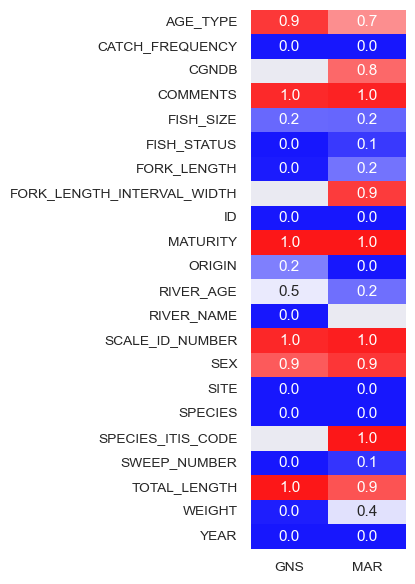

In [17]:
plt.figure(figsize=(2,7))
sns.heatmap(
    pd.concat([
        pd.DataFrame((df_gns.isnull().sum() / df_gns.shape[0]).sort_values(ascending=False), columns=['GNS']),
        pd.DataFrame((df_mar.isnull().sum() / df_mar.shape[0]).sort_values(ascending=False), columns=['MAR'])
    ], axis=1).sort_index(),
    cmap='bwr', annot=True, fmt='.1f', annot_kws={"fontsize":11}, cbar=False, alpha=0.9
)
plt.show()

### Data types

In [18]:
pd.concat([
    pd.DataFrame(df_gns.dtypes, columns=['gns_dtypes']),
    pd.DataFrame(df_gns.nunique(), columns=['gns_unique']).astype('Int64'),
    pd.DataFrame(df_mar.dtypes, columns=['mar_dtypes']),
    pd.DataFrame(df_mar.nunique(), columns=['mar_unique']).astype('Int64')
], axis=1).sort_index()

gns_dtypes  gns_unique mar_dtypes  mar_unique
AGE_TYPE                       object           2     object           3
CATCH_FREQUENCY                 int64          43    float64         180
CGNDB                             NaN        <NA>     object          10
COMMENTS                       object          48     object          72
FISH_SIZE                      object           4     object           6
FISH_STATUS                    object           6     object           7
FORK_LENGTH                   float64         171     object         205
FORK_LENGTH_INTERVAL_WIDTH        NaN        <NA>     object          27
ID                              int64       12895      int64       44472
MATURITY                       object           1     object           1
ORIGIN                         object           2     object           3
RIVER_AGE                     float64           3    float64           5
RIVER_NAME                     object          16        NaN        <NA>
SCALE_ID_NUMBER                object         369     object         728
SEX                            object           2     object           3
SITE                           object          32     object         115
SPECIES                        object          20     object          23
SPECIES_ITIS_CODE                 NaN        <NA>    float64           0
SWEEP_NUMBER                  float64           1     object          11
TOTAL_LENGTH                  float64           4     object         202
WEIGHT                         object        2676    float64        2466
YEAR                          float64          15      int64          51

In [19]:
df_mar.YEAR.min(), df_gns.YEAR.min()

(1957, 2006.0)

In [20]:
print_unique(df_gns)


ID
number of unique values: 12895

YEAR
[2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0, 2017.0, 2018.0, 2019.0, 2020.0, nan]

SITE
['.', 1, 10, '1A', 2, 3, 4, '4B', 5, 6, '6B', 7, '7B', '7b', 8, '8A', '8B', '8b', 9, 98, 99, 996, 997, 998, 999, '9A', 'A', 'B', 'EF BRI', 'P4', 'SP 1', 'SP1', nan]

RIVER_NAME
['Barney River', "Barney's River", 'Barneys', 'Barneys River', 'East River Pictou', 'Mabou', 'Mabou River', 'North East Mabou', 'River John', 'River John East Branch', 'River Philip', 'Wallace', 'Wallace River', 'Wallace River ', 'West River Antigonish', 'West River Pictou', nan]

SWEEP_NUMBER
[0.5, nan]

SPECIES
[140, 1731, 1741, 1781, 2610, 2621, 2630, 2640, 2641, 2650, 2651, 2680, 3410, 4110, 4220, 4260, 4280, 'DACE', 'Unkn', 'frog', nan]

ORIGIN
['H', 'W', nan]

FISH_STATUS
['L', 'M', 'MS', 'MZ', 'R', 'RS', nan]

FORK_LENGTH
number of unique values: 171

TOTAL_LENGTH
[325.0, 44.0, 442.0, 530.0, nan]

WEIGHT
number of unique values: 2676



In [21]:
print_unique(df_mar)


ID
number of unique values: 44472

YEAR
[1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1975, 1976, 1977, 1978, 1979, 1986, 1987, 1988, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

SITE
number of unique values: 115

CGNDB
['CACZB', 'CAMNO', 'CANHO', 'CARKU', 'CATHP', 'CAWKZ', 'CBBWL', 'CBJVR', 'CBPVG', 'Margaree', nan]

SWEEP_NUMBER
[0, 0.5, 1, '1A', '1B', 2, 3, 4, 5, 6, 7, nan]

SPECIES_ITIS_CODE
[nan]

SPECIES
[140, 151, 1510, 1519, 1731, 1741, 1751, 1760, 1781, 2600, 2610, 2660, 2680, 3410, 4110, 412, 422, 4220, 4250, 4260, 9999, 'tadpole', 'worm']

ORIGIN
['H', 'NC', 'W']

FISH_STATUS
['M', 'M ', 'MS', 'R', 'R ', 'RL', 'RS', nan]

FORK_LENGTH
number of unique values: 205

FORK_LENGTH_INTERVAL_WIDTH
[1, '101-105', '106-110', '111-115', '116-120', '121-125', '1221-125', '126-130', '131-135', '136-140', '146-150', '151-

# Impute / Convert to Numeric
### numeric columns with non numeric data

In [22]:
[x for x in df_gns['FORK_LENGTH'].unique() if not str(x).replace('.','',1).isnumeric()]

[nan]

In [23]:
df_gns[df_gns['FORK_LENGTH'].isnull()].shape[0]

119

In [24]:
[x for x in df_gns['WEIGHT'].unique() if not str(x).replace('.','',1).isnumeric()]

[nan, '4..14']

In [25]:
df_gns[df_gns['WEIGHT'].isnull()].shape[0], df_gns[df_gns['WEIGHT']=='4..14'].shape[0]

(245, 1)

In [26]:
# sorted(list(df_gns.WEIGHT.unique()), key=str)
# 4.14 looks like it is a legit value

In [27]:
[x for x in df_mar['FORK_LENGTH'].unique() if not str(x).replace('.','',1).isnumeric()]

[nan,
 '21-25',
 '26-30',
 '31-35',
 '36-40',
 '41-45',
 '46-50',
 ' ',
 '76-80',
 '81-85',
 '86-90',
 '96-100']

In [28]:
(
    df_mar[df_mar.FORK_LENGTH.isnull()].shape[0],
    df_mar[df_mar.FORK_LENGTH.isin([x for x in df_mar['FORK_LENGTH'].dropna().unique() if not str(x).replace('.','',1).isnumeric()])].shape[0]
)
# null, other non-numeric

(9033, 40)

In [29]:
[x for x in df_mar['TOTAL_LENGTH'].unique() if not str(x).replace('.','',1).isnumeric()]

[nan,
 '50-54',
 '55-59',
 '60-64',
 '45-49',
 '65-69',
 '40-44',
 '85-89',
 '35-39',
 '30-34',
 '70-74',
 '75-79',
 '80-84',
 '25-29',
 '64-69',
 '100-104',
 '105-109',
 '145-149',
 '115-119',
 '110-114',
 '130-134',
 '120-124',
 '125-129',
 '165-169',
 '135-139',
 '150-154',
 '155-159',
 '140-144',
 '170-174',
 '90-94',
 '95-99',
 '160-164',
 '185-189',
 '175-179',
 '180-184',
 '210-214',
 '255-259',
 '190-194',
 '220-224',
 '245-249',
 '125-125',
 '205-209',
 '195-199']

In [30]:
df_mar[df_mar['TOTAL_LENGTH'].isnull()].shape[0]

38650

# convert numeric to numeric, coercing errors
### NOTE: this step replaces the errors shown above with NA, but notes the old values in the flag column

##### check '.'

In [31]:
########### confirm that '.' is noted with errors not just replaced and ignored #################
# (yes) (confirmed with df_gsite later)

dataframe=df_gns
for col in dataframe.columns:
    for item in dataframe[col].unique():
        if item == '.':
            print(col)

SITE


In [32]:
df_gns.SITE.unique()

array([996, 'B', 998, 2, 3, 'A', 1, 8, 4, 997, 'SP1', 999, 98, 99, 5, 10,
       'EF BRI', 6, 7, '.', 'SP 1', '1A', '8B', '8A', 9, '4B', 'P4', '7B',
       '8b', '7b', nan, '9A', '6B'], dtype=object)

In [33]:
query = (~df_gns['SITE'].astype(str).str.replace('.','',1,regex=False).str.isnumeric()) & df_gns['SITE'].notnull()
df_gns.loc[query, 'SITE'].unique()

array(['B', 'A', 'SP1', 'EF BRI', '.', 'SP 1', '1A', '8B', '8A', '4B',
       'P4', '7B', '8b', '7b', '9A', '6B'], dtype=object)

##### impute and flag

In [34]:
# impute 4.14 from '4..14'
df_gns.loc[df_gns['WEIGHT']=='4..14', 'FLAG_WEIGHT'] = df_gns.loc[df_gns['WEIGHT']=='4..14', 'WEIGHT']  # flag the entries with errors
df_gns.loc[df_gns['WEIGHT']=='4..14', 'WEIGHT'] = 4.14

# impute averages from ranges
query = (~df_mar['FORK_LENGTH'].astype(str).str.replace('.','',1,regex=False).str.isnumeric()) & df_mar['FORK_LENGTH'].notnull()
df_mar.loc[query, 'FLAG_FORK_LENGTH'] = df_mar.loc[query, 'FORK_LENGTH']  # flag the entries with errors
df_mar.loc[query, 'FORK_LENGTH'] = df_mar.loc[query, 'FORK_LENGTH'].apply(range_to_average)

query = (~df_mar['TOTAL_LENGTH'].astype(str).str.replace('.','',1,regex=False).str.isnumeric()) & df_mar['TOTAL_LENGTH'].notnull()
df_mar.loc[query, 'FLAG_TOTAL_LENGTH'] = df_mar.loc[query, 'TOTAL_LENGTH']  # flag the entries with errors
df_mar.loc[query, 'TOTAL_LENGTH'] = df_mar.loc[query, 'TOTAL_LENGTH'].apply(range_to_average)

In [35]:
# convert and coerce errors
df_gns['WEIGHT'] = pd.to_numeric(df_gns.WEIGHT, errors='coerce')
df_mar['FORK_LENGTH'] = (pd.to_numeric(df_mar.FORK_LENGTH, errors='coerce') // 1).astype('Int64')
df_mar['TOTAL_LENGTH'] = pd.to_numeric(df_mar.TOTAL_LENGTH, errors='coerce')

In [36]:
display(df_gns[df_gns.FLAG_WEIGHT.notnull()])
display(df_mar[df_mar.FLAG_FORK_LENGTH.notnull()].sample(5))
display(df_mar[df_mar.FLAG_TOTAL_LENGTH.notnull()].sample(5))

ID   YEAR SITE             RIVER_NAME  SWEEP_NUMBER SPECIES ORIGIN  \
12507  12508 2018.0    3  West River Antigonish           0.5    1781    NaN   

      FISH_STATUS  FORK_LENGTH  TOTAL_LENGTH  WEIGHT  CATCH_FREQUENCY  \
12507          RS         73.0           NaN     4.1                1   

      FISH_SIZE  RIVER_AGE AGE_TYPE  SEX MATURITY SCALE_ID_NUMBER COMMENTS  \
12507       NaN        NaN      NaN  NaN      NaN             NaN      NaN   

      FLAG_WEIGHT  
12507       4..14

ID  YEAR SITE CGNDB SWEEP_NUMBER  SPECIES_ITIS_CODE SPECIES ORIGIN  \
4562  4563  1986   15   NaN            2                NaN    1731      W   
4571  4572  1986   51   NaN            2                NaN    1731      W   
4578  4579  1986   51   NaN            4                NaN    1731      W   
4551  4552  1986   34   NaN            2                NaN    1731      W   
4564  4565  1986   15   NaN            2                NaN    1731      W   

     FISH_STATUS  FORK_LENGTH FORK_LENGTH_INTERVAL_WIDTH  TOTAL_LENGTH  \
4562          RS           33                        NaN           NaN   
4571          RS           38                        NaN           NaN   
4578          RS           43                        NaN           NaN   
4551          RS           38                        NaN           NaN   
4564          RS           43                        NaN           NaN   

      WEIGHT  CATCH_FREQUENCY FISH_SIZE  RIVER_AGE  AGE_TYPE  SEX MATURITY  \
4562     NaN              1.0       FRY        0.0  LGTHFREQ  NaN      NaN   
4571     NaN              3.0       FRY        0.0  LGTHFREQ  NaN      NaN   
4578     NaN              2.0       FRY        0.0  LGTHFREQ  NaN      NaN   
4551     NaN             28.0       FRY        1.0  LGTHFREQ  NaN      NaN   
4564     NaN              4.0       FRY        0.0  LGTHFREQ  NaN      NaN   

     SCALE_ID_NUMBER COMMENTS FLAG_FORK_LENGTH FLAG_TOTAL_LENGTH  
4562             NaN      NaN            31-35               NaN  
4571             NaN      NaN            36-40               NaN  
4578             NaN      NaN            41-45               NaN  
4551             NaN      NaN            36-40               NaN  
4564             NaN      NaN            41-45               NaN

ID  YEAR SITE CGNDB SWEEP_NUMBER  SPECIES_ITIS_CODE SPECIES ORIGIN  \
7059  7060  1977   27   NaN            1                NaN    1781      W   
8375  8376  1978   34   NaN            1                NaN    1781      W   
6791  6792  1977   15   NaN            1                NaN    1731      W   
7958  7959  1978   15   NaN            2                NaN    1781      W   
7031  7032  1977   23   NaN            4                NaN    1731      W   

     FISH_STATUS  FORK_LENGTH FORK_LENGTH_INTERVAL_WIDTH  TOTAL_LENGTH  \
7059          RS         <NA>                        NaN         112.0   
8375          RS         <NA>                        NaN         112.0   
6791          RS         <NA>                        NaN         132.0   
7958          RS         <NA>                        NaN          47.0   
7031          RS         <NA>                        NaN         127.0   

      WEIGHT  CATCH_FREQUENCY FISH_SIZE  RIVER_AGE  AGE_TYPE  SEX MATURITY  \
7059     NaN              4.0       NaN        1.0       NaN  NaN      NaN   
8375     NaN              1.0       NaN        1.0  LGTHFREQ  NaN      NaN   
6791     NaN              1.0    LGPARR        2.0  LGTHFREQ  NaN      NaN   
7958     NaN              1.0       NaN        NaN       NaN  NaN      NaN   
7031     NaN              1.0    LGPARR        2.0  LGTHFREQ  NaN      NaN   

     SCALE_ID_NUMBER COMMENTS FLAG_FORK_LENGTH FLAG_TOTAL_LENGTH  
7059             NaN      NaN              NaN           110-114  
8375             NaN      NaN              NaN           110-114  
6791             NaN      NaN              NaN           130-134  
7958             NaN      NaN              NaN             45-49  
7031             NaN      NaN              NaN           125-129

# create weight bins for plotting

In [37]:
# one huge boi
df_mar[df_mar.WEIGHT>10000]

ID  YEAR SITE CGNDB SWEEP_NUMBER  SPECIES_ITIS_CODE SPECIES ORIGIN  \
12689  12690  1991   96   NaN            1                NaN    1781      W   

      FISH_STATUS  FORK_LENGTH FORK_LENGTH_INTERVAL_WIDTH  TOTAL_LENGTH  \
12689          RS          100                        NaN           NaN   

       WEIGHT  CATCH_FREQUENCY FISH_SIZE  RIVER_AGE AGE_TYPE  SEX MATURITY  \
12689 11600.0              1.0       NaN        NaN      NaN  NaN      NaN   

      SCALE_ID_NUMBER COMMENTS FLAG_FORK_LENGTH FLAG_TOTAL_LENGTH  
12689             NaN      NaN              NaN               NaN

In [38]:
df_gns['WT_BIN'] = df_gns['WEIGHT'] // 1
df_gns.loc[df_gns.WT_BIN>100, 'WT_BIN'] = 100
df_mar['WT_BIN'] = df_mar['WEIGHT'] // 1
df_mar.loc[df_mar.WT_BIN>100, 'WT_BIN'] = 100

# Biological EDA and Comparison





=========================== COMMENTS ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: COMMENTS 

UNIQUE numbers, strings, blanks, null = (0, 48, 0, 1)
number of numeric = 0
number of strings = 510
number of blanks = 0
number of null =  12385

		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: COMMENTS 

UNIQUE numbers, strings, blanks, null = (0, 72, 1, 1)
number of numeric = 0
number of strings = 1081
number of blanks = 1
number of null =  43391




=========================== FLAG_FORK_LENGTH ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
COLUMN MISSING: FLAG_FORK_LENGTH

		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: FLAG_FORK_LENGTH 

UNIQUE numbers, strings, blanks, null = (0, 11, 1, 1)
number of numeric = 0
number of strings = 40
number of blanks = 1
number of null =  44432




====

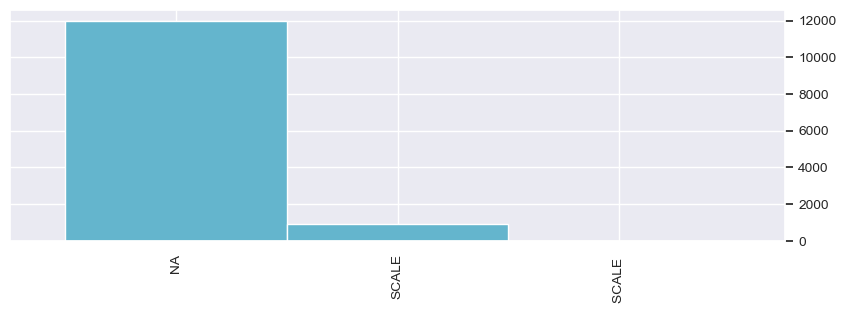


------------------------------------------------
Time Series:AGE_TYPE
CATEGORICAL


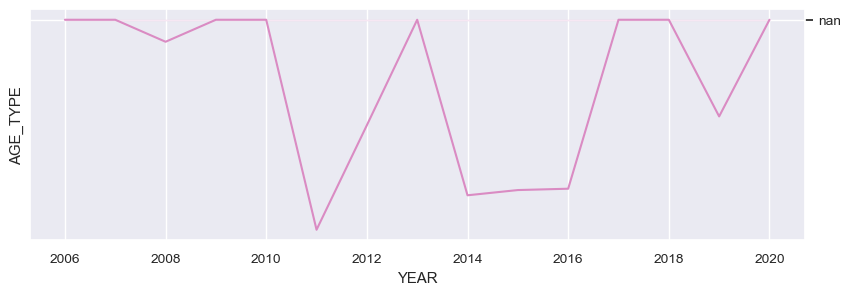


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: AGE_TYPE 

UNIQUE numbers, strings, blanks, null = (0, 3, 0, 1)
number of numeric = 0
number of strings = 11548
number of blanks = 0
number of null =  32924

--------------------------------------------------
Histogram: AGE_TYPE
CATEGORICAL


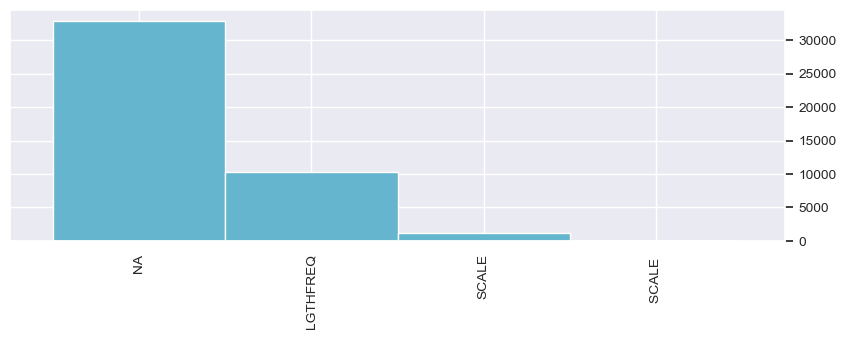


------------------------------------------------
Time Series:AGE_TYPE
CATEGORICAL


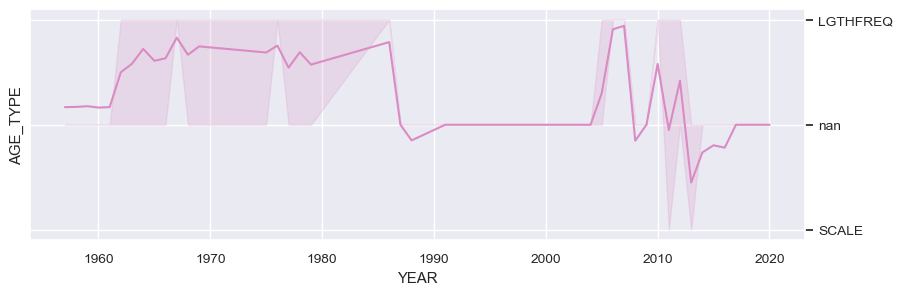





=========================== CATCH_FREQUENCY ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: CATCH_FREQUENCY 

UNIQUE numbers, strings, blanks, null = (43, 0, 0, 0)
number of numeric = 12895
number of strings = 0
number of blanks = 0
number of null =  0

--------------------------------------------------
Histogram: CATCH_FREQUENCY
NUMERICAL


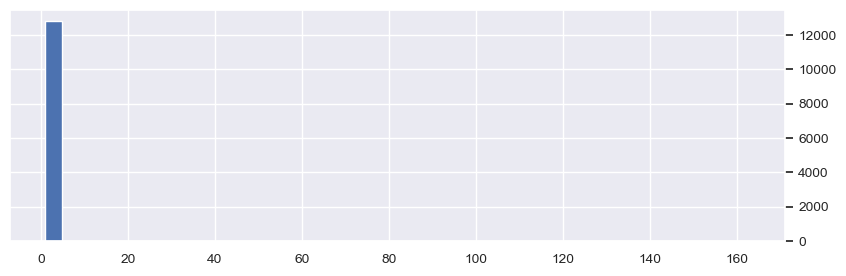


------------------------------------------------
Time Series:CATCH_FREQUENCY
NUMERICAL


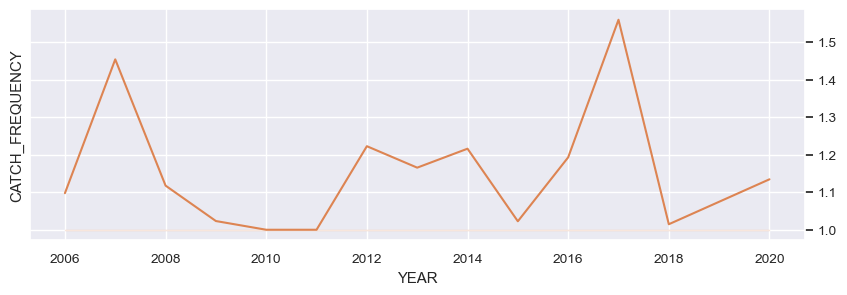


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: CATCH_FREQUENCY 

UNIQUE numbers, strings, blanks, null = (180, 0, 0, 1)
number of numeric = 44465
number of strings = 0
number of blanks = 0
number of null =  7

--------------------------------------------------
Histogram: CATCH_FREQUENCY
NUMERICAL


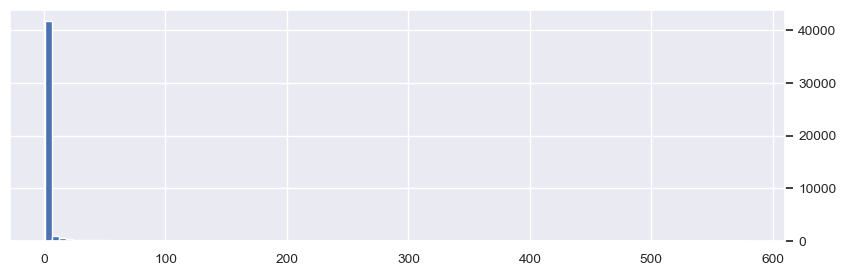


------------------------------------------------
Time Series:CATCH_FREQUENCY
NUMERICAL


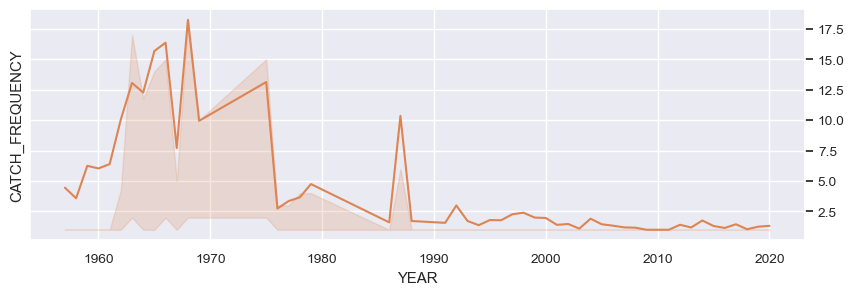





=========================== CGNDB ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
COLUMN MISSING: CGNDB

		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: CGNDB 

UNIQUE numbers, strings, blanks, null = (0, 10, 0, 1)
number of numeric = 0
number of strings = 7941
number of blanks = 0
number of null =  36531

--------------------------------------------------
Histogram: CGNDB
CATEGORICAL


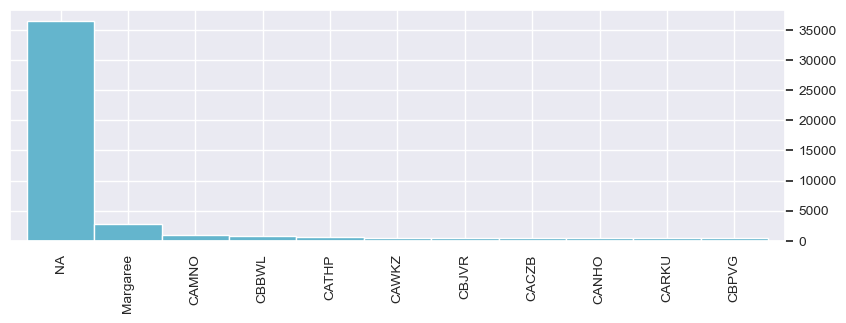


------------------------------------------------
Time Series:CGNDB
CATEGORICAL


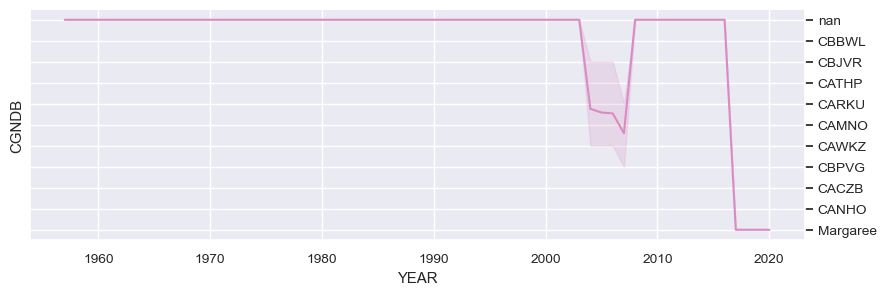





=========================== FISH_SIZE ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: FISH_SIZE 

UNIQUE numbers, strings, blanks, null = (0, 4, 0, 1)
number of numeric = 0
number of strings = 10627
number of blanks = 0
number of null =  2268

--------------------------------------------------
Histogram: FISH_SIZE
CATEGORICAL


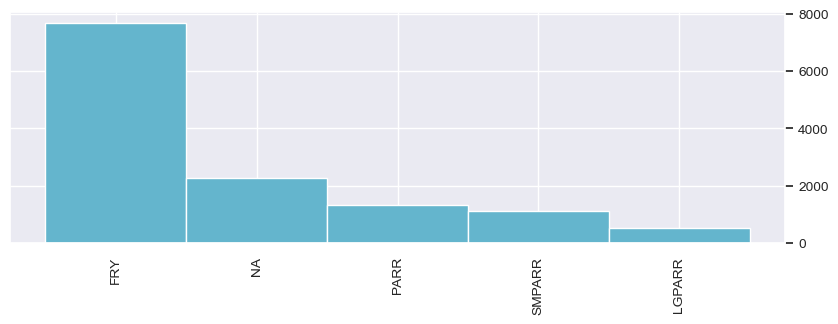


------------------------------------------------
Time Series:FISH_SIZE
CATEGORICAL


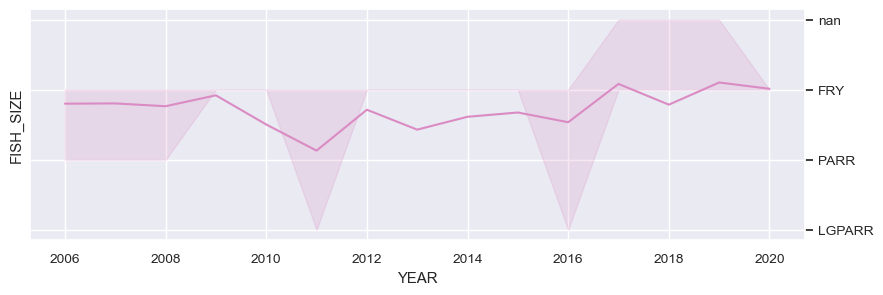


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: FISH_SIZE 

UNIQUE numbers, strings, blanks, null = (0, 6, 0, 1)
number of numeric = 0
number of strings = 36719
number of blanks = 0
number of null =  7753

--------------------------------------------------
Histogram: FISH_SIZE
CATEGORICAL


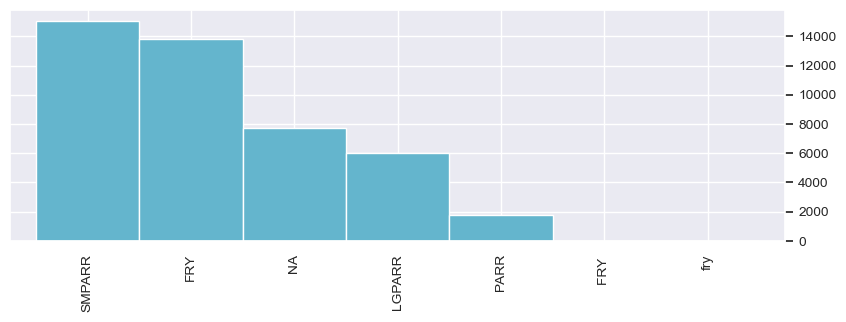


------------------------------------------------
Time Series:FISH_SIZE
CATEGORICAL


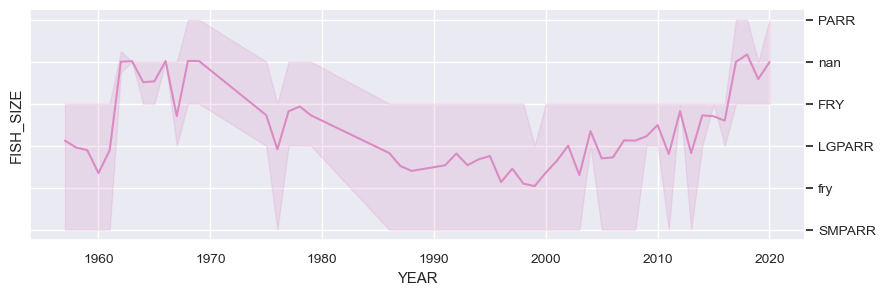





=========================== FISH_STATUS ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: FISH_STATUS 

UNIQUE numbers, strings, blanks, null = (0, 6, 0, 1)
number of numeric = 0
number of strings = 12859
number of blanks = 0
number of null =  36

--------------------------------------------------
Histogram: FISH_STATUS
CATEGORICAL


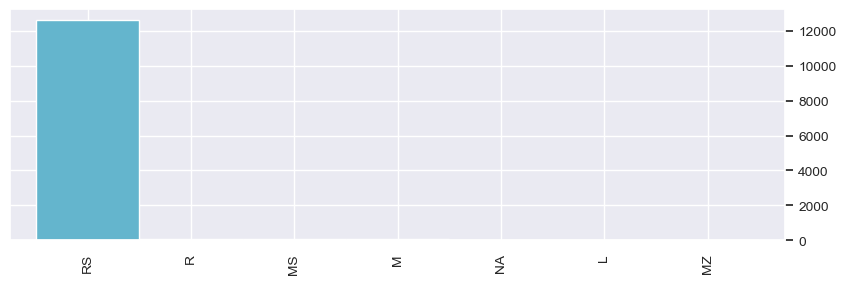


------------------------------------------------
Time Series:FISH_STATUS
CATEGORICAL


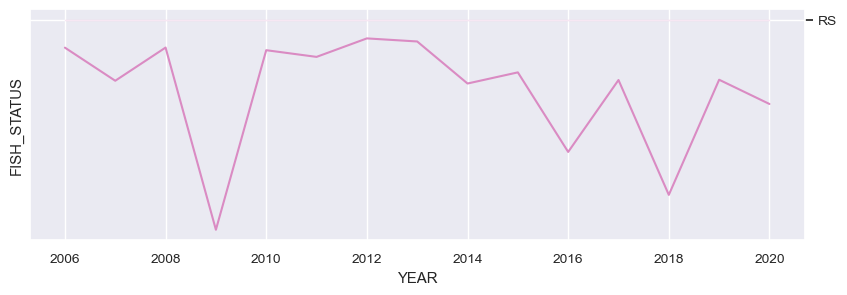


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: FISH_STATUS 

UNIQUE numbers, strings, blanks, null = (0, 7, 0, 1)
number of numeric = 0
number of strings = 41124
number of blanks = 0
number of null =  3348

--------------------------------------------------
Histogram: FISH_STATUS
CATEGORICAL


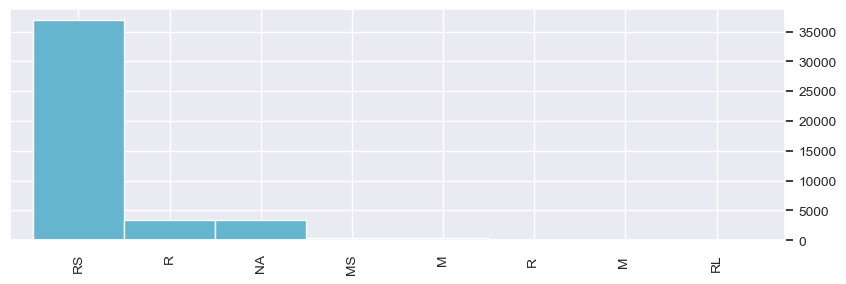


------------------------------------------------
Time Series:FISH_STATUS
CATEGORICAL


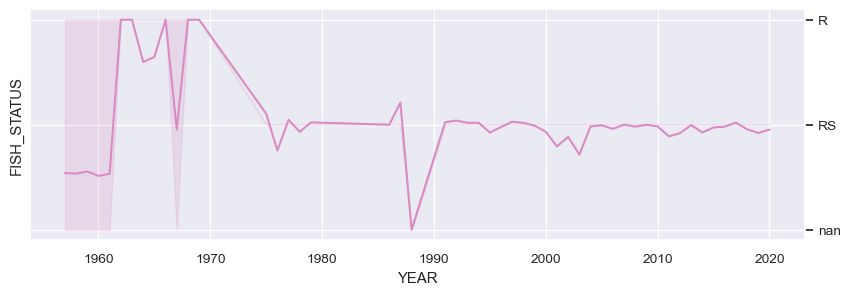





=========================== FORK_LENGTH ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: FORK_LENGTH 

UNIQUE numbers, strings, blanks, null = (171, 0, 0, 1)
number of numeric = 12776
number of strings = 0
number of blanks = 0
number of null =  119

--------------------------------------------------
Histogram: FORK_LENGTH
NUMERICAL


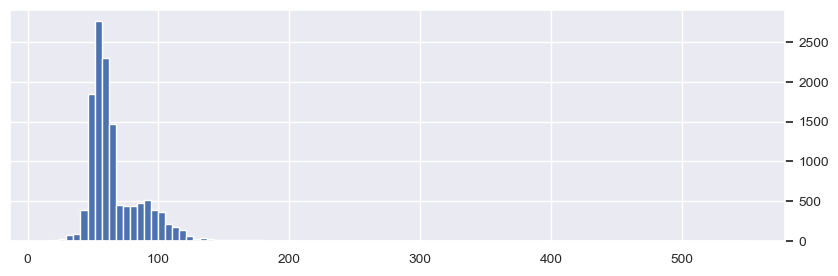


------------------------------------------------
Time Series:FORK_LENGTH
NUMERICAL


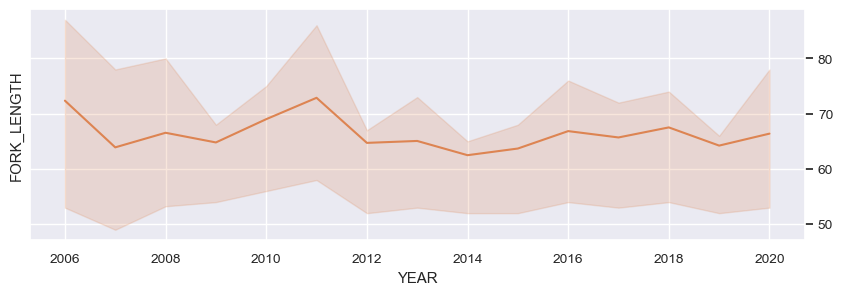


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: FORK_LENGTH 

UNIQUE numbers, strings, blanks, null = (194, 0, 0, 1)
number of numeric = 35438
number of strings = 0
number of blanks = 0
number of null =  9034

--------------------------------------------------
Histogram: FORK_LENGTH
NUMERICAL


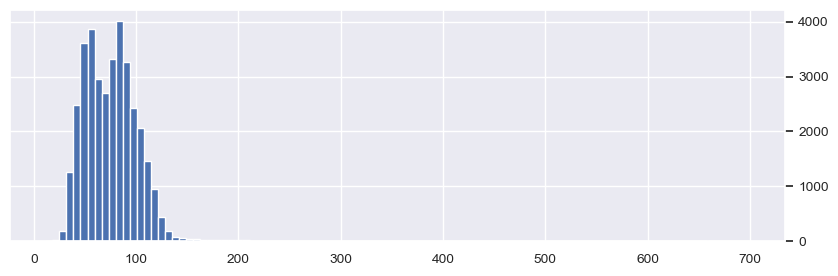


------------------------------------------------
Time Series:FORK_LENGTH
NUMERICAL


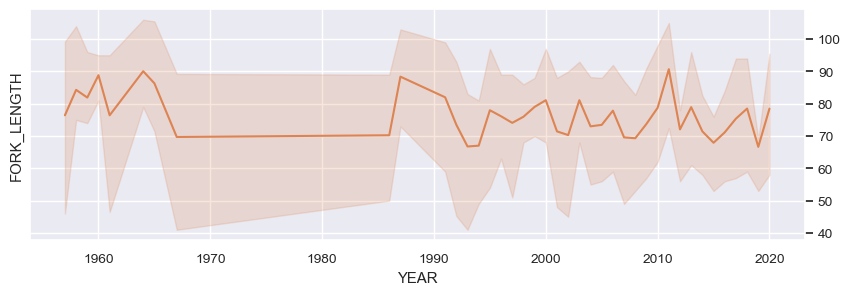





=========================== MATURITY ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: MATURITY 

UNIQUE numbers, strings, blanks, null = (0, 1, 0, 1)
number of numeric = 0
number of strings = 23
number of blanks = 0
number of null =  12872

--------------------------------------------------
Histogram: MATURITY
CATEGORICAL


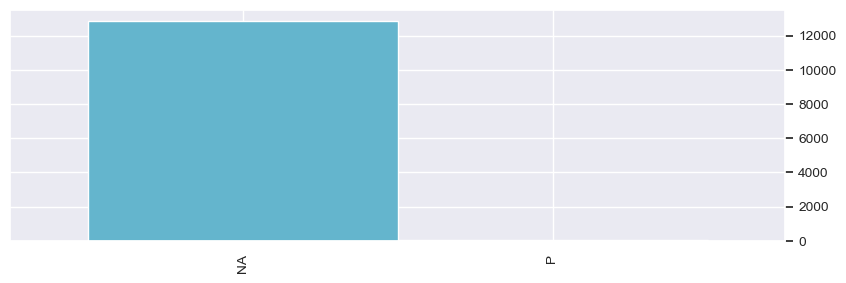


------------------------------------------------
Time Series:MATURITY
CATEGORICAL


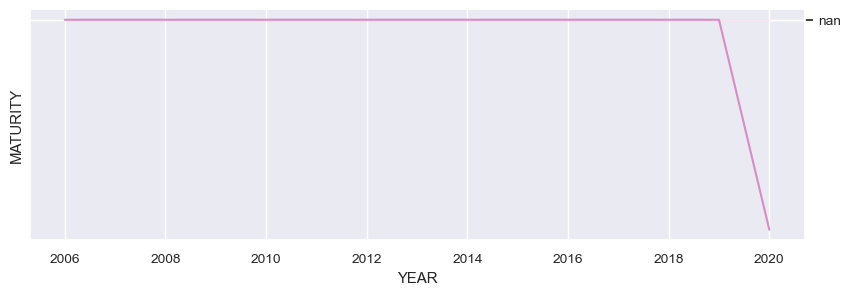


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: MATURITY 

UNIQUE numbers, strings, blanks, null = (0, 1, 0, 1)
number of numeric = 0
number of strings = 36
number of blanks = 0
number of null =  44436

--------------------------------------------------
Histogram: MATURITY
CATEGORICAL


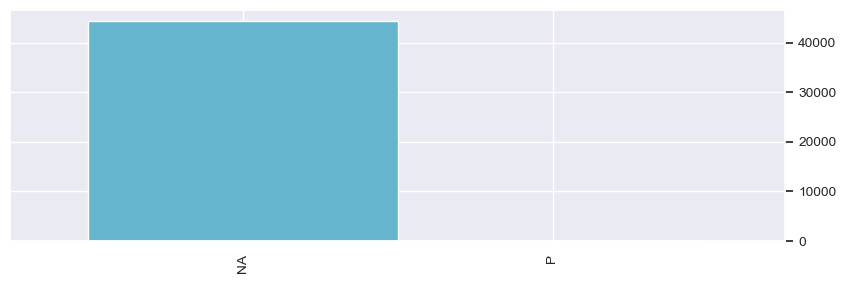


------------------------------------------------
Time Series:MATURITY
CATEGORICAL


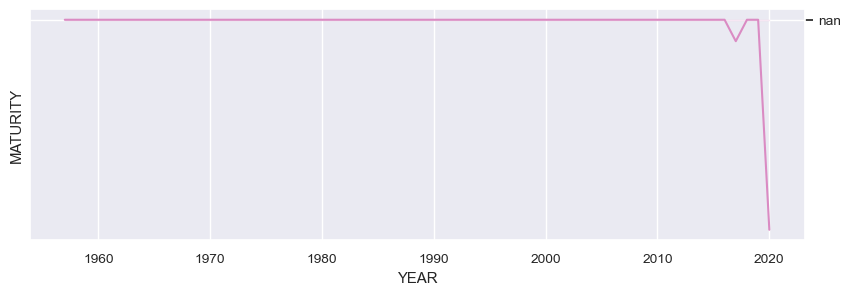





=========================== ORIGIN ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: ORIGIN 

UNIQUE numbers, strings, blanks, null = (0, 2, 0, 1)
number of numeric = 0
number of strings = 9964
number of blanks = 0
number of null =  2931

--------------------------------------------------
Histogram: ORIGIN
CATEGORICAL


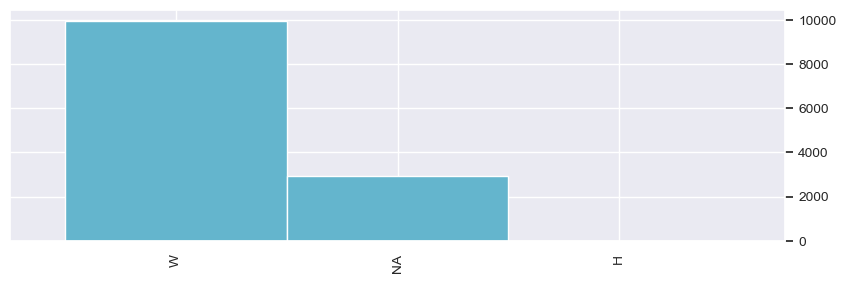


------------------------------------------------
Time Series:ORIGIN
CATEGORICAL


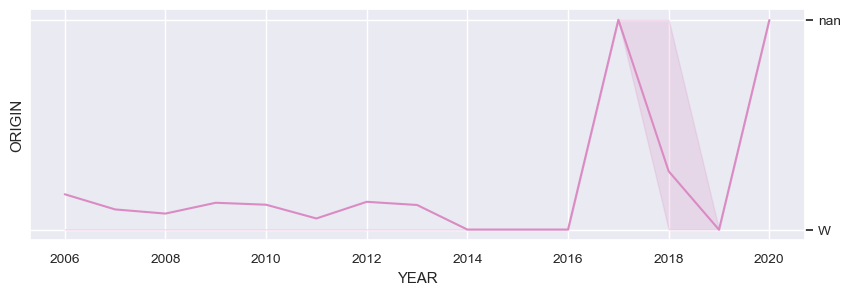


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: ORIGIN 

UNIQUE numbers, strings, blanks, null = (0, 3, 0, 0)
number of numeric = 0
number of strings = 44472
number of blanks = 0
number of null =  0

--------------------------------------------------
Histogram: ORIGIN
CATEGORICAL


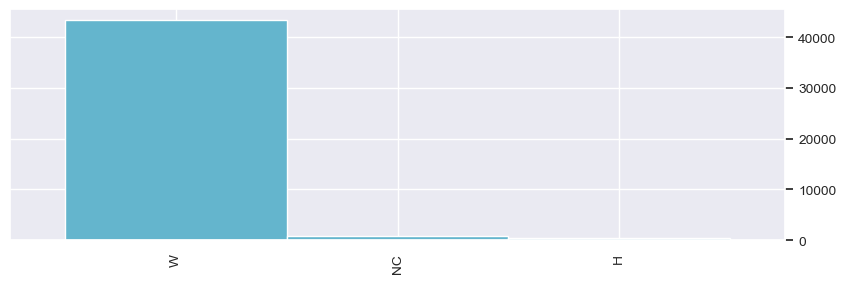


------------------------------------------------
Time Series:ORIGIN
CATEGORICAL


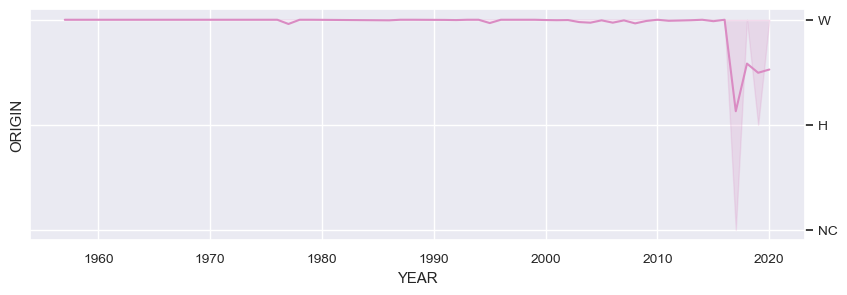





=========================== RIVER_AGE ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: RIVER_AGE 

UNIQUE numbers, strings, blanks, null = (3, 0, 0, 1)
number of numeric = 6967
number of strings = 0
number of blanks = 0
number of null =  5928

--------------------------------------------------
Histogram: RIVER_AGE
NUMERICAL


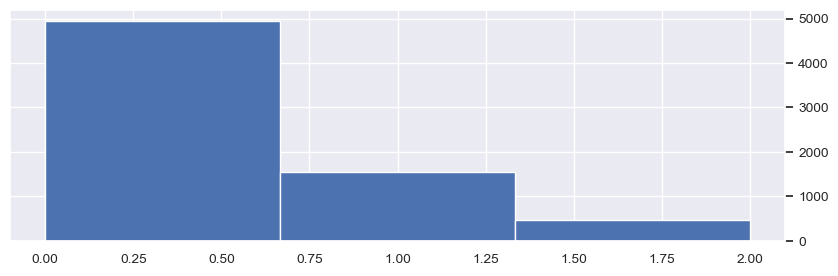


------------------------------------------------
Time Series:RIVER_AGE
NUMERICAL


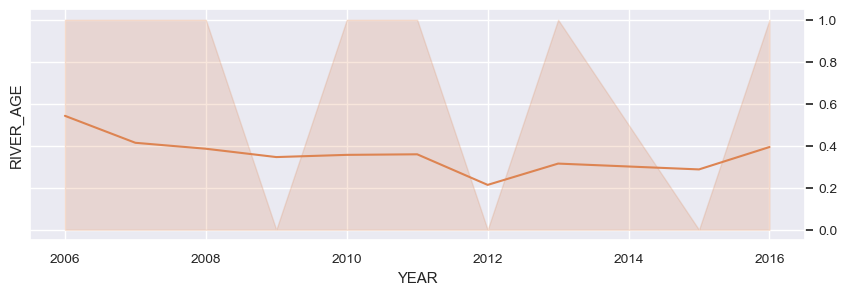


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: RIVER_AGE 

UNIQUE numbers, strings, blanks, null = (5, 0, 0, 1)
number of numeric = 35813
number of strings = 0
number of blanks = 0
number of null =  8659

--------------------------------------------------
Histogram: RIVER_AGE
NUMERICAL


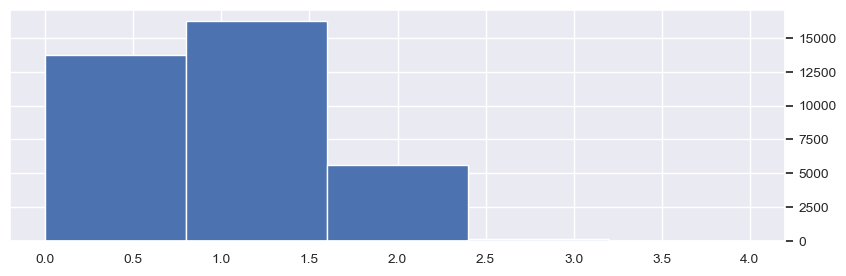


------------------------------------------------
Time Series:RIVER_AGE
NUMERICAL


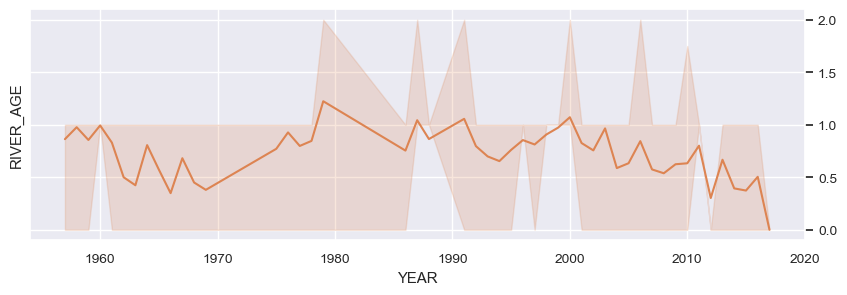





=========================== RIVER_NAME ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: RIVER_NAME 

UNIQUE numbers, strings, blanks, null = (0, 16, 0, 1)
number of numeric = 0
number of strings = 12859
number of blanks = 0
number of null =  36

--------------------------------------------------
Histogram: RIVER_NAME
CATEGORICAL


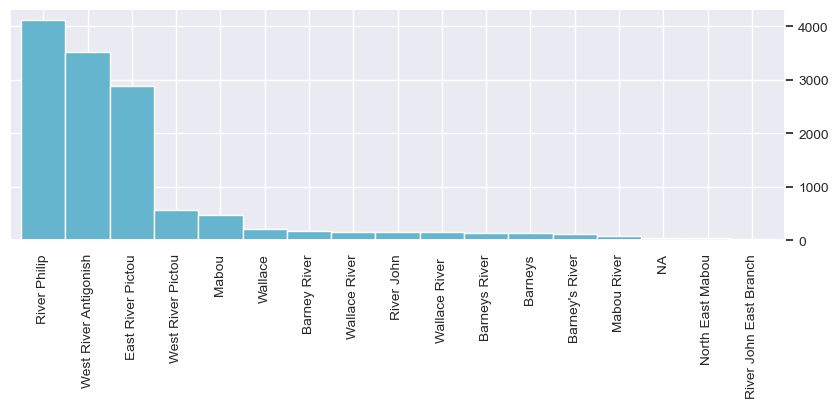


------------------------------------------------
Time Series:RIVER_NAME
CATEGORICAL


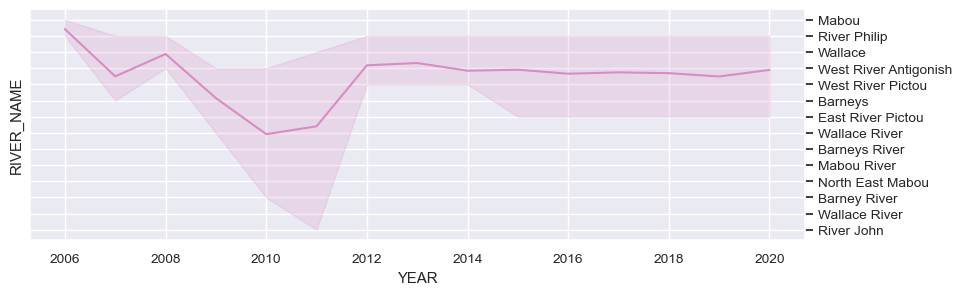


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
COLUMN MISSING: RIVER_NAME




=========================== SEX ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: SEX 

UNIQUE numbers, strings, blanks, null = (0, 2, 0, 1)
number of numeric = 0
number of strings = 1882
number of blanks = 0
number of null =  11013

--------------------------------------------------
Histogram: SEX
CATEGORICAL


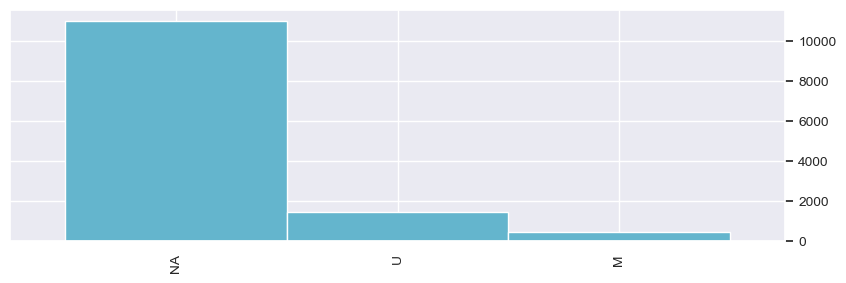


------------------------------------------------
Time Series:SEX
CATEGORICAL


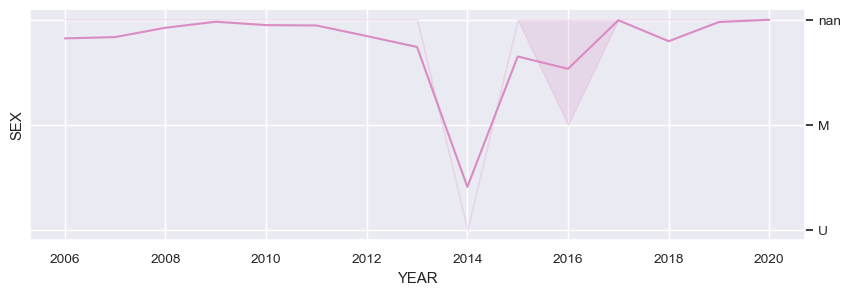


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: SEX 

UNIQUE numbers, strings, blanks, null = (0, 3, 0, 1)
number of numeric = 0
number of strings = 3088
number of blanks = 0
number of null =  41384

--------------------------------------------------
Histogram: SEX
CATEGORICAL


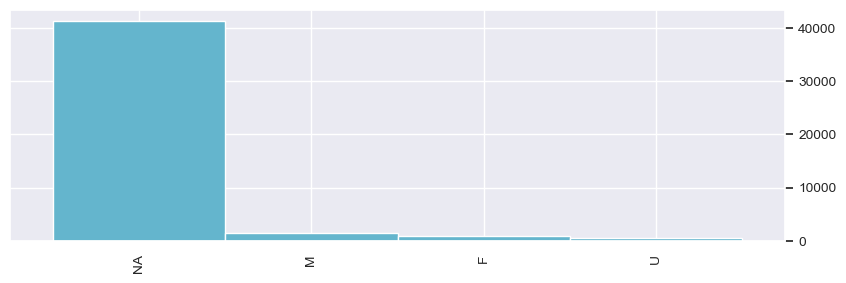


------------------------------------------------
Time Series:SEX
CATEGORICAL


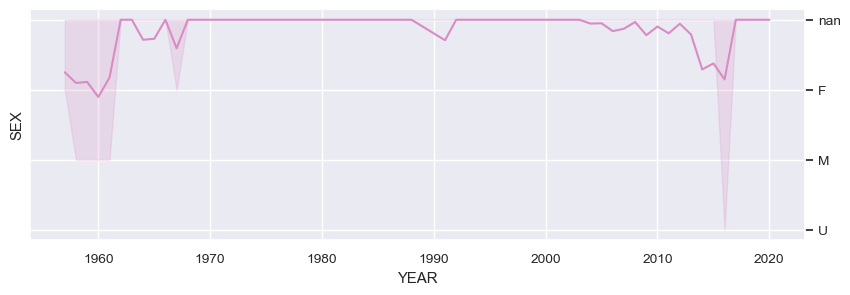





=========================== SPECIES ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: SPECIES 

UNIQUE numbers, strings, blanks, null = (17, 3, 0, 1)
number of numeric = 12852
number of strings = 3
number of blanks = 0
number of null =  40

--------------------------------------------------
Histogram: SPECIES
CATEGORICAL


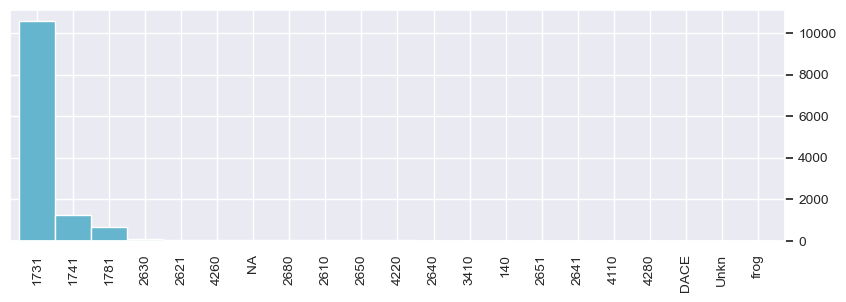


------------------------------------------------
Time Series:SPECIES
CATEGORICAL


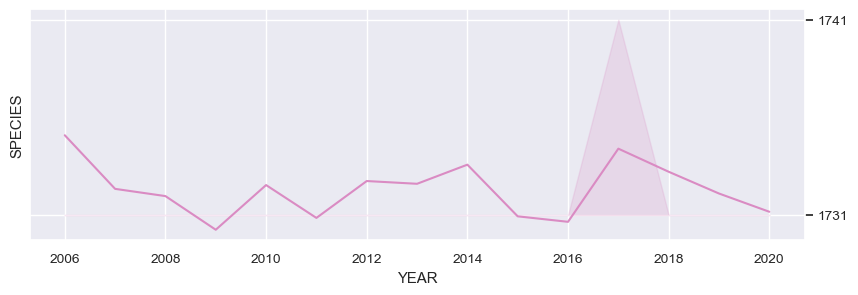


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: SPECIES 

UNIQUE numbers, strings, blanks, null = (21, 2, 0, 0)
number of numeric = 44470
number of strings = 2
number of blanks = 0
number of null =  0

--------------------------------------------------
Histogram: SPECIES
CATEGORICAL


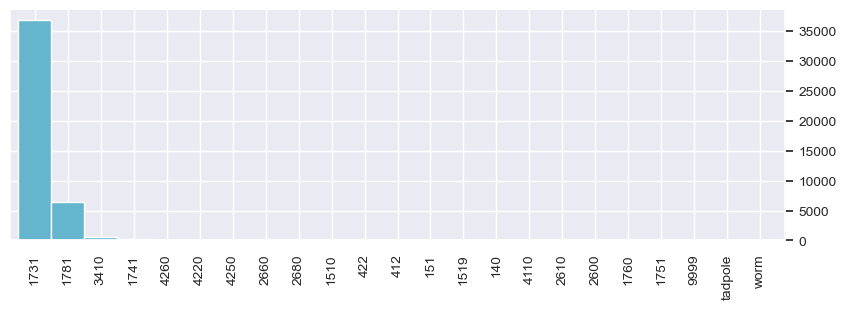


------------------------------------------------
Time Series:SPECIES
CATEGORICAL


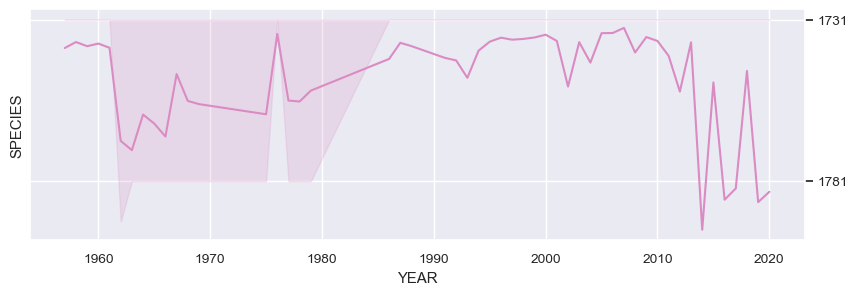





=========================== SWEEP_NUMBER ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: SWEEP_NUMBER 

UNIQUE numbers, strings, blanks, null = (1, 0, 0, 1)
number of numeric = 12859
number of strings = 0
number of blanks = 0
number of null =  36

--------------------------------------------------
Histogram: SWEEP_NUMBER
NUMERICAL


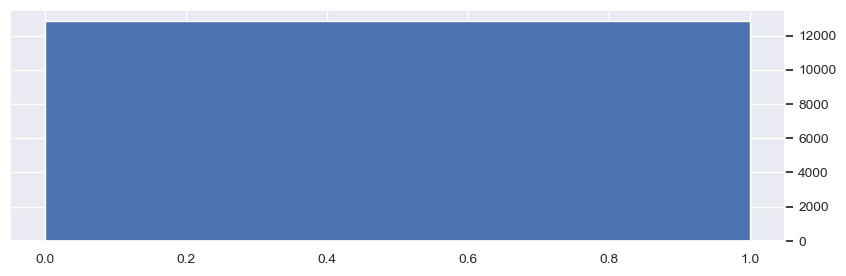


------------------------------------------------
Time Series:SWEEP_NUMBER
NUMERICAL


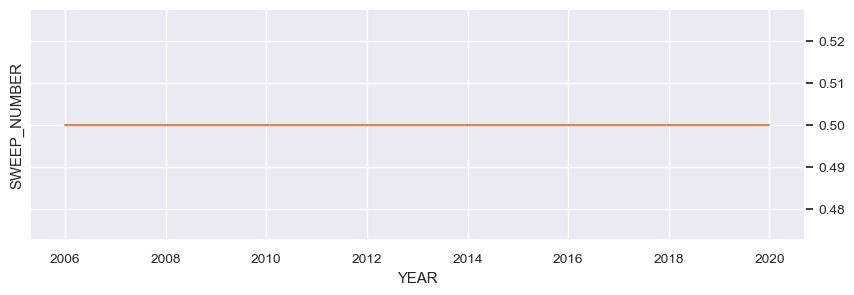


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: SWEEP_NUMBER 

UNIQUE numbers, strings, blanks, null = (9, 2, 0, 1)
number of numeric = 40583
number of strings = 1029
number of blanks = 0
number of null =  2860

--------------------------------------------------
Histogram: SWEEP_NUMBER
CATEGORICAL


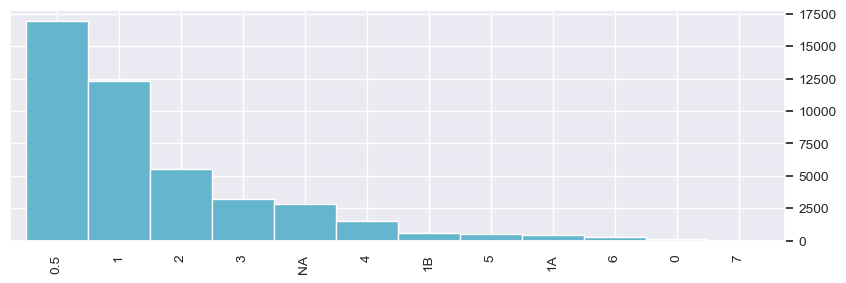


------------------------------------------------
Time Series:SWEEP_NUMBER
CATEGORICAL


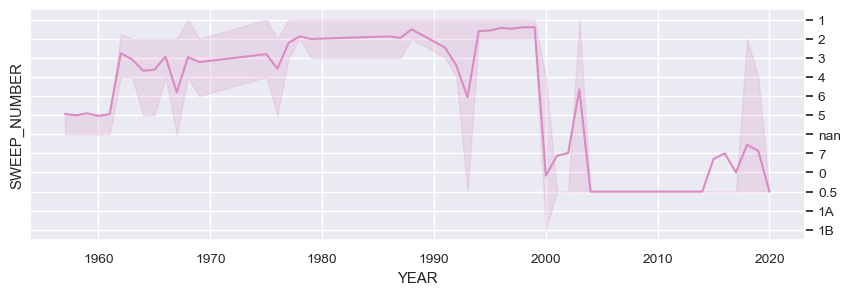





=========================== WT_BIN ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: WT_BIN 

UNIQUE numbers, strings, blanks, null = (66, 0, 0, 1)
number of numeric = 12650
number of strings = 0
number of blanks = 0
number of null =  245

--------------------------------------------------
Histogram: WT_BIN
NUMERICAL


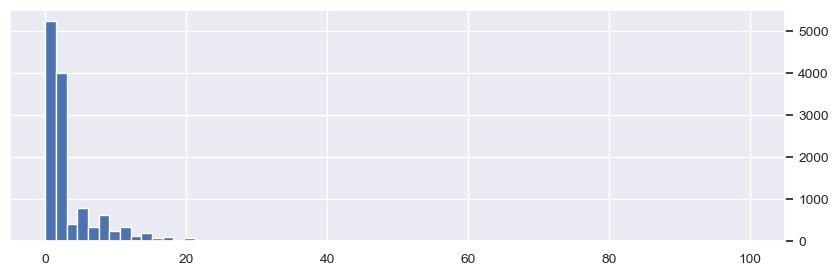


------------------------------------------------
Time Series:WT_BIN
NUMERICAL


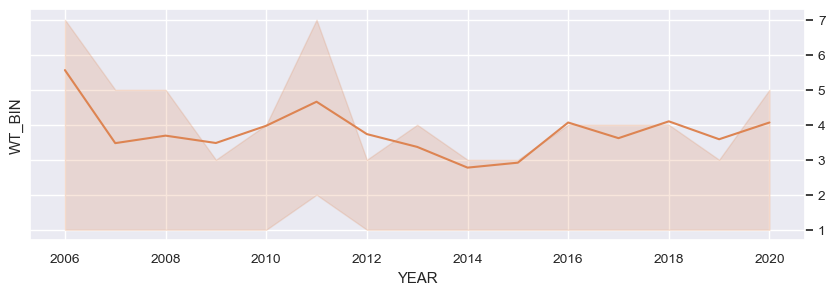


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: WT_BIN 

UNIQUE numbers, strings, blanks, null = (74, 0, 0, 1)
number of numeric = 24842
number of strings = 0
number of blanks = 0
number of null =  19630

--------------------------------------------------
Histogram: WT_BIN
NUMERICAL


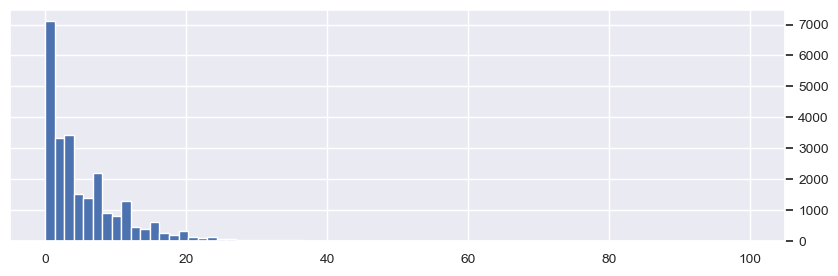


------------------------------------------------
Time Series:WT_BIN
NUMERICAL


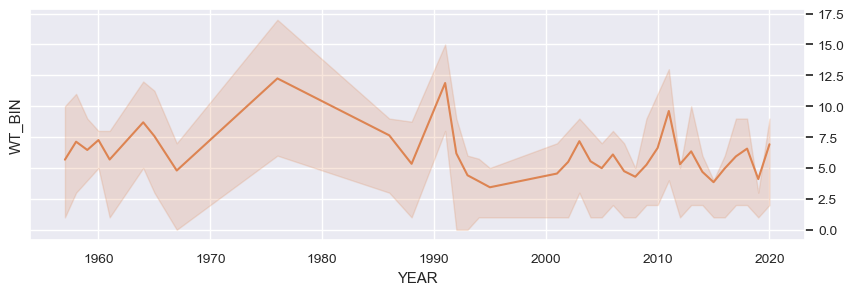

In [39]:
dont_plot_these_columns = sorted(['ID', 'YEAR', 'WEIGHT', 'SCALE_ID_NUMBER', 'SITE', 'SPECIES_ITIS_CODE', 'TOTAL_LENGTH', 'COMMENTS', 'FORK_LENGTH_INTERVAL_WIDTH', 'FLAG_FORK_LENGTH', 'FLAG_TOTAL_LENGTH', 'FLAG_WEIGHT'])
plot_these_columns = sorted([x for x in set(list(df_gns.columns) + list(df_mar.columns)) if x not in dont_plot_these_columns])
missing_from_gns = [x for x in df_mar.columns if x not in df_gns.columns]
missing_from_mar = [x for x in df_gns.columns if x not in df_mar.columns]

for col in dont_plot_these_columns:
    print(f'\n\n\n\n=========================== {col.upper()} ===========================\n')
    print('\n\t\t<<<<<  GNS  >>>>>\n')
    if col in missing_from_gns:
        print('--------------------------------------------------\nCOLUMN MISSING:', col)
    else:
        print_data_info(df_gns, col)
    print('\n\t\t<<<<<  MARGAREE  >>>>>\n')
    if col in missing_from_mar:
        print('--------------------------------------------------\nCOLUMN MISSING:', col)
    else:
        print_data_info(df_mar, col)
for col in plot_these_columns:
    print(f'\n\n\n\n=========================== {col.upper()} ===========================\n')
    print('\n\t\t<<<<<  GNS  >>>>>\n')
    if col in missing_from_gns:
        print('--------------------------------------------------\nCOLUMN MISSING:', col)
    else:
        do_EDA_stuff(df_gns, col)
    print('\n\t\t<<<<<  MARGAREE  >>>>>\n')
    if col in missing_from_mar:
        print('--------------------------------------------------\nCOLUMN MISSING:', col)
    else:
        do_EDA_stuff(df_mar, col)

# =============================================
# CODE DATA
# =============================================

In [40]:
# 'Code, species' / 'Code' sheet has field, code, label, descriptions for many features (not just species)

df_gcode = pd.read_excel(r'.\raw_data\GNS Efish_2006-2020_For DM App.xlsx', sheet_name='Code, species')
df_gcode.columns = [x.strip().replace(' ', '_').upper() for x in df_gcode.columns]

df_mcode = pd.read_excel(r'.\raw_data\Margaree Efish_1957-2020_For DM App.xlsx', sheet_name='Code')
df_mcode.columns = [x.strip().replace(' ', '_').upper() for x in df_mcode.columns]

### are they the exact same? (yes)

In [41]:
(df_mcode == df_gcode).all()

VIEW_NAME       True
ALIAS_NAME      True
FIELDNAME       True
CODE_VALUE      True
LABEL           True
DESCRIPTION    False
dtype: bool

In [42]:
# all 'mismatched' entries are actually just Null

df_mcode[~(df_mcode == df_gcode).all(axis=1)].DESCRIPTION.isna().all(), df_gcode[~(df_mcode == df_gcode).all(axis=1)].DESCRIPTION.isna().all()

(True, True)

In [43]:
# from now on, just use mcode
df_code = df_mcode

### unique values

In [44]:
print_unique(df_code)


VIEW_NAME
['VU_SEMIR_BIOLOGICAL', 'VU_SEMIR_RIVER', 'VU_SEMIR_SITE', 'VU_SEMIR_SITE_MEASUREMENT', 'VU_SEMIR_SPECIES']

ALIAS_NAME
['Fish Data', 'River', 'Site Data', 'Site Measurement Data', 'Species']

FIELDNAME
['AGE_TYPE', 'AIKENHEAD_LEGROW_CODE', 'APRONSEINE_TYPE', 'DEPTH_LAYOUT_TYPE', 'ELECTROFISHER_TYPE', 'FILE_TYPE', 'FISH_SIZE', 'FISH_STATUS', 'MARITIME_RIVER_CODE', 'MATURITY', 'MESH_SIZE', 'OLD_MARITIME_RIVER_CODE', 'ORIGIN', 'RIVER_PROVINCE', 'SEX', 'SPECIES_LIFE_STAGE', 'WEATHER']

CODE_VALUE
number of unique values: 374

LABEL
number of unique values: 452

DESCRIPTION
number of unique values: 433


### are there any duplicate fieldname/code combos? (yes)
* substatial data cleaning could be benefitial

In [45]:
df_code.groupby(['FIELDNAME', 'CODE_VALUE']).count().describe()

VIEW_NAME  ALIAS_NAME  LABEL  DESCRIPTION
count      470.0       470.0  470.0        470.0
mean         1.6         1.6    1.6          1.5
std          0.5         0.5    0.5          0.6
min          1.0         1.0    1.0          0.0
25%          1.0         1.0    1.0          1.0
50%          2.0         2.0    2.0          2.0
75%          2.0         2.0    2.0          2.0
max          2.0         2.0    2.0          2.0

In [46]:
# entries with duplicated fieldname, code_value 
duplicated_codes = list(
    df_code[df_code.duplicated(subset=['FIELDNAME', 'CODE_VALUE'], keep=False)]
    .groupby('CODE_VALUE')
    .count()
    .reset_index()
    .CODE_VALUE
    .unique()
)

In [47]:
# what are the differences in different columns where CODE_VALUE is duplicated?

df_duplicated = df_code[df_code.CODE_VALUE.isin(duplicated_codes)].sort_values('CODE_VALUE')

for col in [x for x in df_duplicated if x != 'CODE_VALUE']:
    print()
    print(col)
    temp = df_duplicated[df_duplicated.ne(df_duplicated.shift())][col].value_counts()
    print(temp[temp>1].sort_index())


VIEW_NAME
VU_SEMIR_RIVER    193
VU_SEMIR_SITE     193
Name: VIEW_NAME, dtype: int64

ALIAS_NAME
River        193
Site Data    193
Name: ALIAS_NAME, dtype: int64

FIELDNAME
MARITIME_RIVER_CODE        99
OLD_MARITIME_RIVER_CODE    98
Name: FIELDNAME, dtype: int64

LABEL
1113000 - MIRAMICHI RIVER                                      2
1113004 - SOUTHWEST MIRAMICHI, Southwest Miramichi River       2
1113024 - BETT'S MILL BK., BETT'S MILL BROOK                   2
1113024 - BETTS MILL BK                                        2
1113045 - Rocky Brook                                          2
1113048 - BIG HOLE BK                                          2
1113060 - Bartholomew River                                    2
1113060 - UNKNOWN                                              2
1113063 - DUNGARVON                                            2
1113063 - Dungarvon River                                      2
1113064 - Renous River                                         2
1113066 - NORTH

In [48]:
# example
df_duplicated[df_duplicated.CODE_VALUE=='1113073']

VIEW_NAME ALIAS_NAME                FIELDNAME CODE_VALUE  \
339  VU_SEMIR_RIVER      River  OLD_MARITIME_RIVER_CODE    1113073   
174  VU_SEMIR_RIVER      River      MARITIME_RIVER_CODE    1113073   
611   VU_SEMIR_SITE  Site Data  OLD_MARITIME_RIVER_CODE    1113073   
446   VU_SEMIR_SITE  Site Data      MARITIME_RIVER_CODE    1113073   

                           LABEL                  DESCRIPTION  
339  1113073 - BIG SEVOGLE RIVER  1113073 - BIG SEVOGLE RIVER  
174        1113073 - BIG SEVOGLE        1113073 - BIG SEVOGLE  
611  1113073 - BIG SEVOGLE RIVER  1113073 - BIG SEVOGLE RIVER  
446        1113073 - BIG SEVOGLE        1113073 - BIG SEVOGLE

# CODE visualisations and EDA

--------------------------------------------------
Data Info: CODE_VALUE 

UNIQUE numbers, strings, blanks, null = (342, 32, 0, 0)
number of numeric = 703
number of strings = 39
number of blanks = 0
number of null =  0
--------------------------------------------------
Data Info: DESCRIPTION 

UNIQUE numbers, strings, blanks, null = (44, 389, 0, 1)
number of numeric = 44
number of strings = 674
number of blanks = 0
number of null =  24
--------------------------------------------------
Data Info: LABEL 

UNIQUE numbers, strings, blanks, null = (44, 408, 0, 0)
number of numeric = 44
number of strings = 698
number of blanks = 0
number of null =  0
--------------------------------------------------
Data Info: ALIAS_NAME 

UNIQUE numbers, strings, blanks, null = (0, 5, 0, 0)
number of numeric = 0
number of strings = 742
number of blanks = 0
number of null =  0

--------------------------------------------------
Histogram: ALIAS_NAME
CATEGORICAL


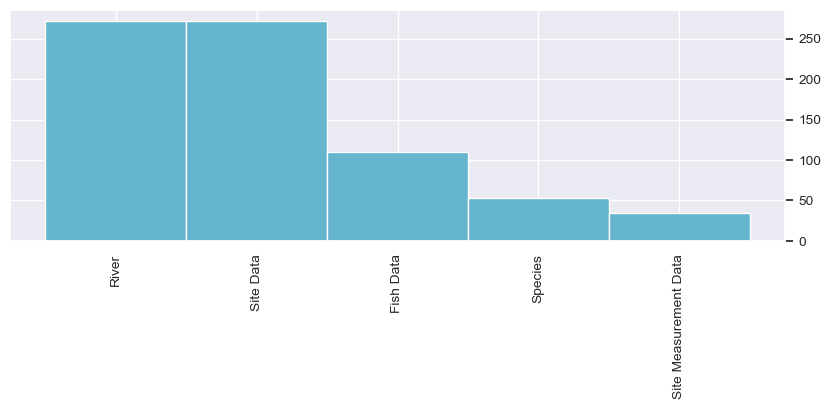

--------------------------------------------------
Data Info: FIELDNAME 

UNIQUE numbers, strings, blanks, null = (0, 17, 0, 0)
number of numeric = 0
number of strings = 742
number of blanks = 0
number of null =  0

--------------------------------------------------
Histogram: FIELDNAME
CATEGORICAL


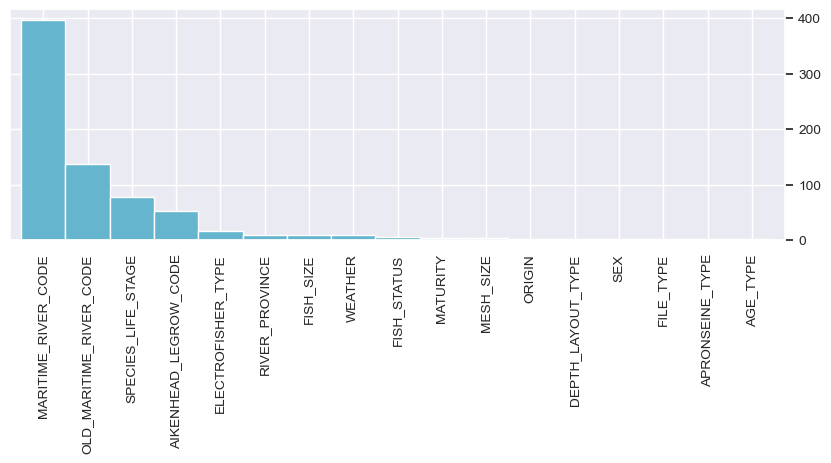

--------------------------------------------------
Data Info: VIEW_NAME 

UNIQUE numbers, strings, blanks, null = (0, 5, 0, 0)
number of numeric = 0
number of strings = 742
number of blanks = 0
number of null =  0

--------------------------------------------------
Histogram: VIEW_NAME
CATEGORICAL


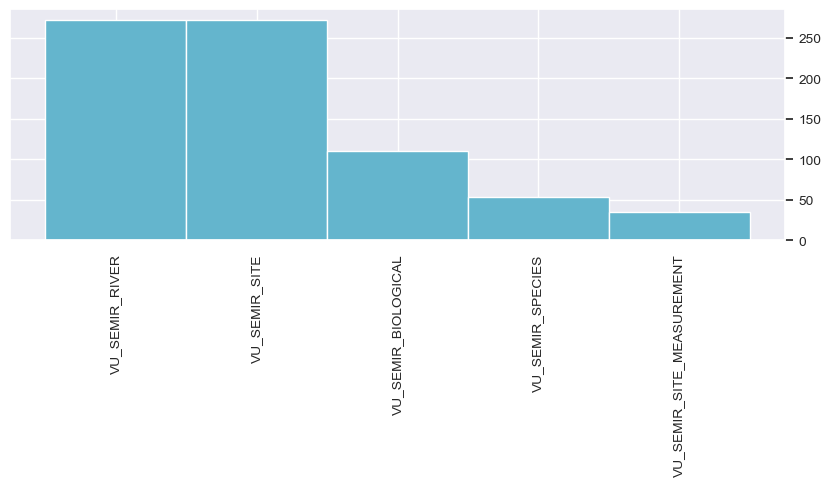

In [49]:
dont_plot_these_columns = sorted(['CODE_VALUE', 'LABEL', 'DESCRIPTION'])
plot_these_columns = sorted([x for x in list(df_code.columns) if x not in dont_plot_these_columns])

for col in dont_plot_these_columns:
    print_data_info(df_code, col)
for col in plot_these_columns:
    print_data_info(df_code, col)
    print_hist(df_code, col)

### Null values

In [50]:
df_code.isnull().sum()

VIEW_NAME       0
ALIAS_NAME      0
FIELDNAME       0
CODE_VALUE      0
LABEL           0
DESCRIPTION    24
dtype: int64

In [51]:
df_code[df_code.DESCRIPTION.isnull()]

VIEW_NAME             ALIAS_NAME          FIELDNAME  \
100        VU_SEMIR_BIOLOGICAL              Fish Data           AGE_TYPE   
101        VU_SEMIR_BIOLOGICAL              Fish Data           AGE_TYPE   
377             VU_SEMIR_RIVER                  River     RIVER_PROVINCE   
378             VU_SEMIR_RIVER                  River     RIVER_PROVINCE   
379             VU_SEMIR_RIVER                  River     RIVER_PROVINCE   
380             VU_SEMIR_RIVER                  River     RIVER_PROVINCE   
381             VU_SEMIR_RIVER                  River     RIVER_PROVINCE   
649              VU_SEMIR_SITE              Site Data     RIVER_PROVINCE   
650              VU_SEMIR_SITE              Site Data     RIVER_PROVINCE   
651              VU_SEMIR_SITE              Site Data     RIVER_PROVINCE   
652              VU_SEMIR_SITE              Site Data     RIVER_PROVINCE   
653              VU_SEMIR_SITE              Site Data     RIVER_PROVINCE   
654  VU_SEMIR_SITE_MEASUREMENT  Site Measurement Data  DEPTH_LAYOUT_TYPE   
655  VU_SEMIR_SITE_MEASUREMENT  Site Measurement Data  DEPTH_LAYOUT_TYPE   
656  VU_SEMIR_SITE_MEASUREMENT  Site Measurement Data  DEPTH_LAYOUT_TYPE   
680  VU_SEMIR_SITE_MEASUREMENT  Site Measurement Data            WEATHER   
681  VU_SEMIR_SITE_MEASUREMENT  Site Measurement Data            WEATHER   
682  VU_SEMIR_SITE_MEASUREMENT  Site Measurement Data            WEATHER   
683  VU_SEMIR_SITE_MEASUREMENT  Site Measurement Data            WEATHER   
684  VU_SEMIR_SITE_MEASUREMENT  Site Measurement Data            WEATHER   
685  VU_SEMIR_SITE_MEASUREMENT  Site Measurement Data            WEATHER   
686  VU_SEMIR_SITE_MEASUREMENT  Site Measurement Data            WEATHER   
687  VU_SEMIR_SITE_MEASUREMENT  Site Measurement Data            WEATHER   
688  VU_SEMIR_SITE_MEASUREMENT  Site Measurement Data            WEATHER   

    CODE_VALUE                           LABEL DESCRIPTION  
100   LGTHFREQ     BIOLOGICAL_AGING_METHOD1_LF         NaN  
101      SCALE    BIOLOGICAL_AGING_METHOD1_SCL         NaN  
377         NB               RIVER_PROVINCE_NB         NaN  
378       NFLD             RIVER_PROVINCE_NFLD         NaN  
379         NS               RIVER_PROVINCE_NS         NaN  
380        PEI              RIVER_PROVINCE_PEI         NaN  
381         QC               RIVER_PROVINCE_QC         NaN  
649         NB               RIVER_PROVINCE_NB         NaN  
650       NFLD             RIVER_PROVINCE_NFLD         NaN  
651         NS               RIVER_PROVINCE_NS         NaN  
652        PEI              RIVER_PROVINCE_PEI         NaN  
653         QC               RIVER_PROVINCE_QC         NaN  
654        2X3     SURVEY_SITE_DIM_DEPTH_TP1_1         NaN  
655        3X3     SURVEY_SITE_DIM_DEPTH_TP1_2         NaN  
656        3X4     SURVEY_SITE_DIM_DEPTH_TP1_3         NaN  
680          0   SITE_EVENT_WEATHER_OBSERV_UNK         NaN  
681          1   SITE_EVENT_WEATHER_OBSERV_SUN         NaN  
682          2  SITE_EVENT_WEATHER_OBSERV_RAIN         NaN  
683          3   SITE_EVENT_WEATHER_OBSERV_FOG         NaN  
684          4  SITE_EVENT_WEATHER_OBSERV_SNOW         NaN  
685          5  SITE_EVENT_WEATHER_OBSERV_FRRA         NaN  
686          6  SITE_EVENT_WEATHER_OBSERV_MIST         NaN  
687          7  SITE_EVENT_WEATHER_OBSERV_DARK         NaN  
688          8   SITE_EVENT_WEATHER_OBSERV_CLR         NaN

### Value Counts

In [52]:
for col in df_code.columns:
    print()
    print(col)
    if df_code[col].nunique()>10:
        display(df_code[col].value_counts().head(10))
    else:
        display(df_code[col].value_counts())


VIEW_NAME


VU_SEMIR_RIVER               272
VU_SEMIR_SITE                272
VU_SEMIR_BIOLOGICAL          110
VU_SEMIR_SPECIES              53
VU_SEMIR_SITE_MEASUREMENT     35
Name: VIEW_NAME, dtype: int64


ALIAS_NAME


River                    272
Site Data                272
Fish Data                110
Species                   53
Site Measurement Data     35
Name: ALIAS_NAME, dtype: int64


FIELDNAME


MARITIME_RIVER_CODE        396
OLD_MARITIME_RIVER_CODE    138
SPECIES_LIFE_STAGE          79
AIKENHEAD_LEGROW_CODE       53
ELECTROFISHER_TYPE          17
FISH_SIZE                   10
RIVER_PROVINCE              10
WEATHER                      9
FISH_STATUS                  6
MATURITY                     5
Name: FIELDNAME, dtype: int64


CODE_VALUE


2          6
1          6
847004     4
1113088    4
1102000    4
1192019    4
1192020    4
1103000    4
1104000    4
1107000    4
Name: CODE_VALUE, dtype: int64


LABEL


1113001 - Black Brook         4
1113068 - SUTHERLAND BROOK    4
1103000 - Eel River           4
1102000 - Portage River       4
1115000 - OYSTER RIVER        4
1113057 - MORSE BROOK         4
1109000 - BLACK RIVER         4
1114000 - BARTIBOG RIVER      4
1111000 - NAPAN RIVER         4
1104000 - French River        4
Name: LABEL, dtype: int64


DESCRIPTION


1113016 - Black Brook          4
1113005 - Barnaby River        4
1113007 - Grey Rapids Brook    4
1113008 - Becket Brook         4
1113013 - McKenzie Brook       4
1113001 - Black Brook          4
1111000 - NAPAN RIVER          4
1109000 - BLACK RIVER          4
1104000 - French River         4
1103000 - Eel River            4
Name: DESCRIPTION, dtype: int64

# =============================================
# SITE MEASUREMENT DATA
# =============================================

In [53]:
df_gsite = pd.read_excel(r'.\raw_data\GNS Efish_2006-2020_For DM App.xlsx', sheet_name='Site Measurement Data')
df_gsite.columns = [x.strip().replace(' ', '_').upper() for x in df_gsite.columns]

df_msite = pd.read_excel(r'.\raw_data\Margaree Efish_1957-2020_For DM App.xlsx', sheet_name='Site Measurement Data')
df_msite.columns = [x.strip().replace(' ', '_').upper() for x in df_msite.columns]

In [54]:
pd.concat(
    [
        df_gsite.drop('SITE_EVENT_DATE', axis=1).describe(percentiles=[], include='all').drop(['top', 'freq']).T.fillna(''),
        df_msite.drop('SITE_EVENT_DATE', axis=1).describe(percentiles=[], include='all').drop(['top', 'freq']).T.fillna('')
    ], axis=1,
    keys=['GNS', 'MARGAREE']
)

GNS                                           \
                              count unique   mean   std    min    50%    max   
ID                            244.0         122.5  70.6    1.0  122.5  244.0   
SURVEY                        244.0        2013.8   4.1 2006.0 2014.0 2020.0   
SITE                          242.0   32.0                                     
RIVER_NAME                    244.0     15                                     
TOS1                          211.0   21.0                                     
TOS2                          211.0   21.0                                     
TOS3                          211.0    7.0                                     
TOS4                          211.0    6.0                                     
LENGTH_LEFT_BANK              238.0          15.2   4.9    3.5   14.8   33.6   
LENGTH_RIGHT_BANK             238.0          15.8  12.6    3.4   14.8  194.0   
WIDTH_LOWER                   238.0  102.0                                     
WIDTH_MIDDLE                  232.0     93                                     
WIDTH_UPPER                   238.0           7.3   3.3    2.1    6.3   20.5   
FULL_WETTED_WIDTH              93.0          89.6  30.6   33.1   87.1  203.0   
DEPTHA1                       202.0   46.0                                     
DEPTHA2                       202.0   48.0                                     
DEPTHA3                       202.0   51.0                                     
DEPTHA4                         0.0                                            
DEPTHB1                       200.0   41.0                                     
DEPTHB2                       200.0   44.0                                     
DEPTHB3                       200.0   46.0                                     
DEPTHB4                         0.0                                            
DEPTHC1                       201.0   44.0                                     
DEPTHC2                       201.0   41.0                                     
DEPTHC3                       201.0   41.0                                     
DEPTHC4                         0.0                                            
DEPTH_MAX                     127.0          32.8  10.5   13.0   32.0   76.0   
DEPTH_LAYOUT_TYPE               0.0                                            
AIR_TEMPERATURE                 0.0                                            
WATER_TEMPERATURE_ARRIVAL     190.0   84.0                                     
WATER_TEMPERATURE_DEPART        0.0                                            
TIME_TEMP1                      0.0                                            
WATER_TEMP1                     0.0                                            
TIME_TEMP2                      0.0                                            
WATER_TEMP2                     0.0                                            
TIME_TEMP3                      0.0                                            
WATER_TEMP3                     0.0                                            
GRADIENT_WATER_HEIGH_UP         0.0                                            
GRADIENT_WATER_HEIGH_DOWN       0.0                                            
GRADIENT_DISTANCE               0.0                                            
WATER_VEL_TIME                  0.0                                            
WATER_VEL_DISTANCE              0.0                                            
WATER_PH                       42.0     22                                     
WATER_CONDUCTIVITY            190.0          75.4  61.0   17.2   52.0  372.0   
WATER_CONDUCTIVITY_RESOLUTION   0.0                                            
SUB_TYPE_FINES                241.0    7.0                                     
SUB_TYPE_SAND                 241.0   11.0                                     
SUB_TYPE_GRAVEL               241.0   12.0                                     
SUB_TYPE_PEBBLE               24

### differences in columns

In [55]:
# not in Margaree data
[x for x in df_gsite.columns if x not in df_msite.columns]

['RIVER_NAME']

In [56]:
# not in GNS data
[x for x in df_msite.columns if x not in df_msite.columns]

[]

### yearly change

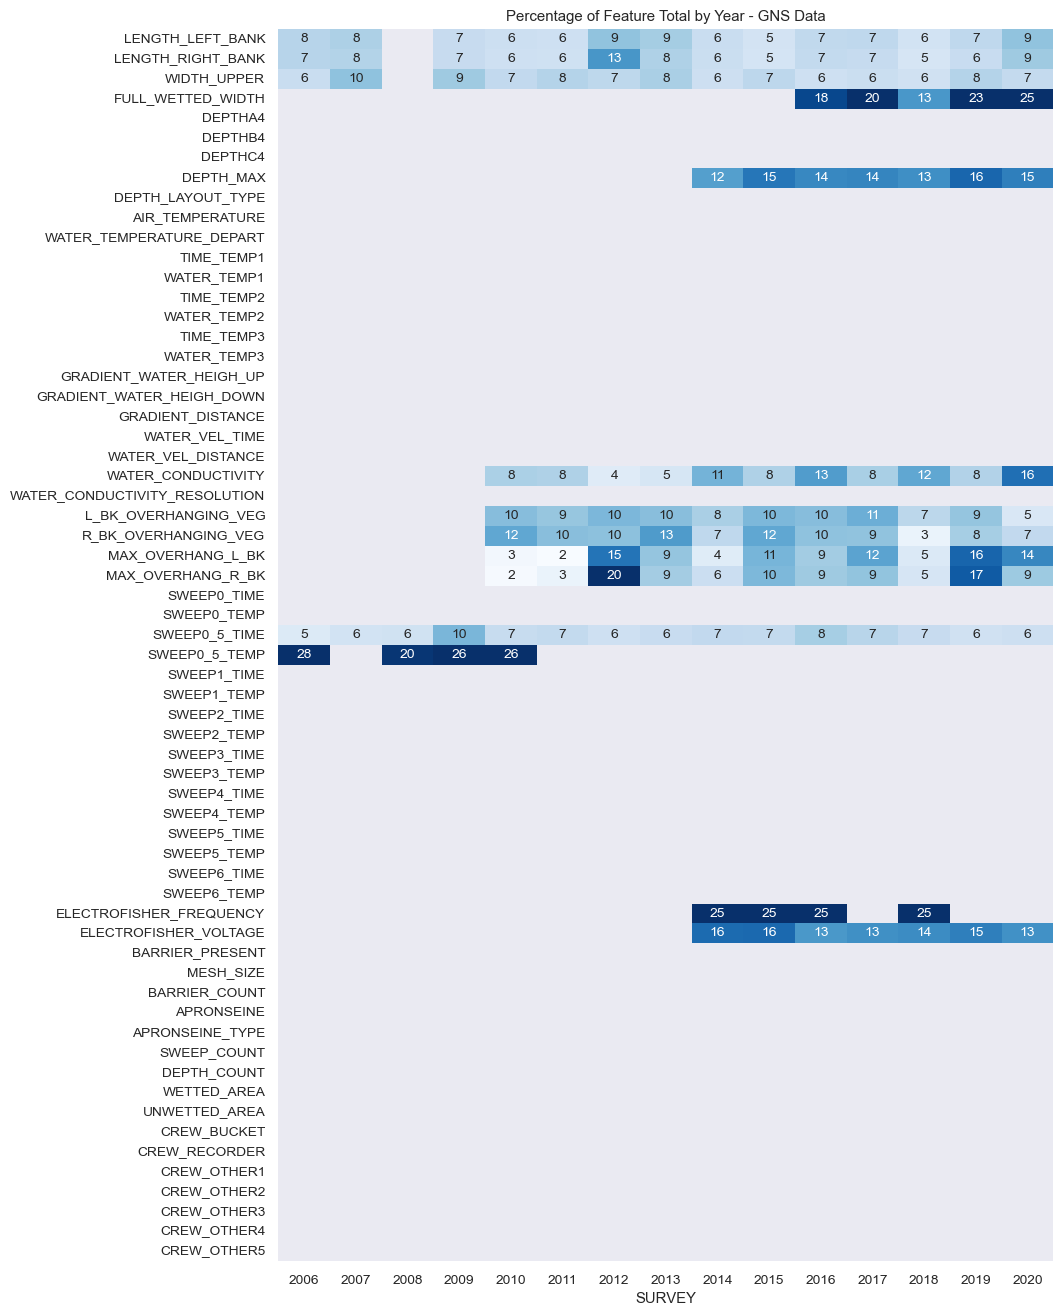

In [57]:
plt.figure(figsize=(10,16))
sns.heatmap(
    (100 * df_gsite.groupby('SURVEY').mean() / df_gsite.groupby('SURVEY').mean().sum()).drop('ID', axis=1).T, 
    cmap='Blues',
    cbar=False, 
    annot=True, 
    fmt='.0f', 
    annot_kws={"fontsize":10},
    vmax=20
)
plt.title('Percentage of Feature Total by Year - GNS Data')
plt.show()

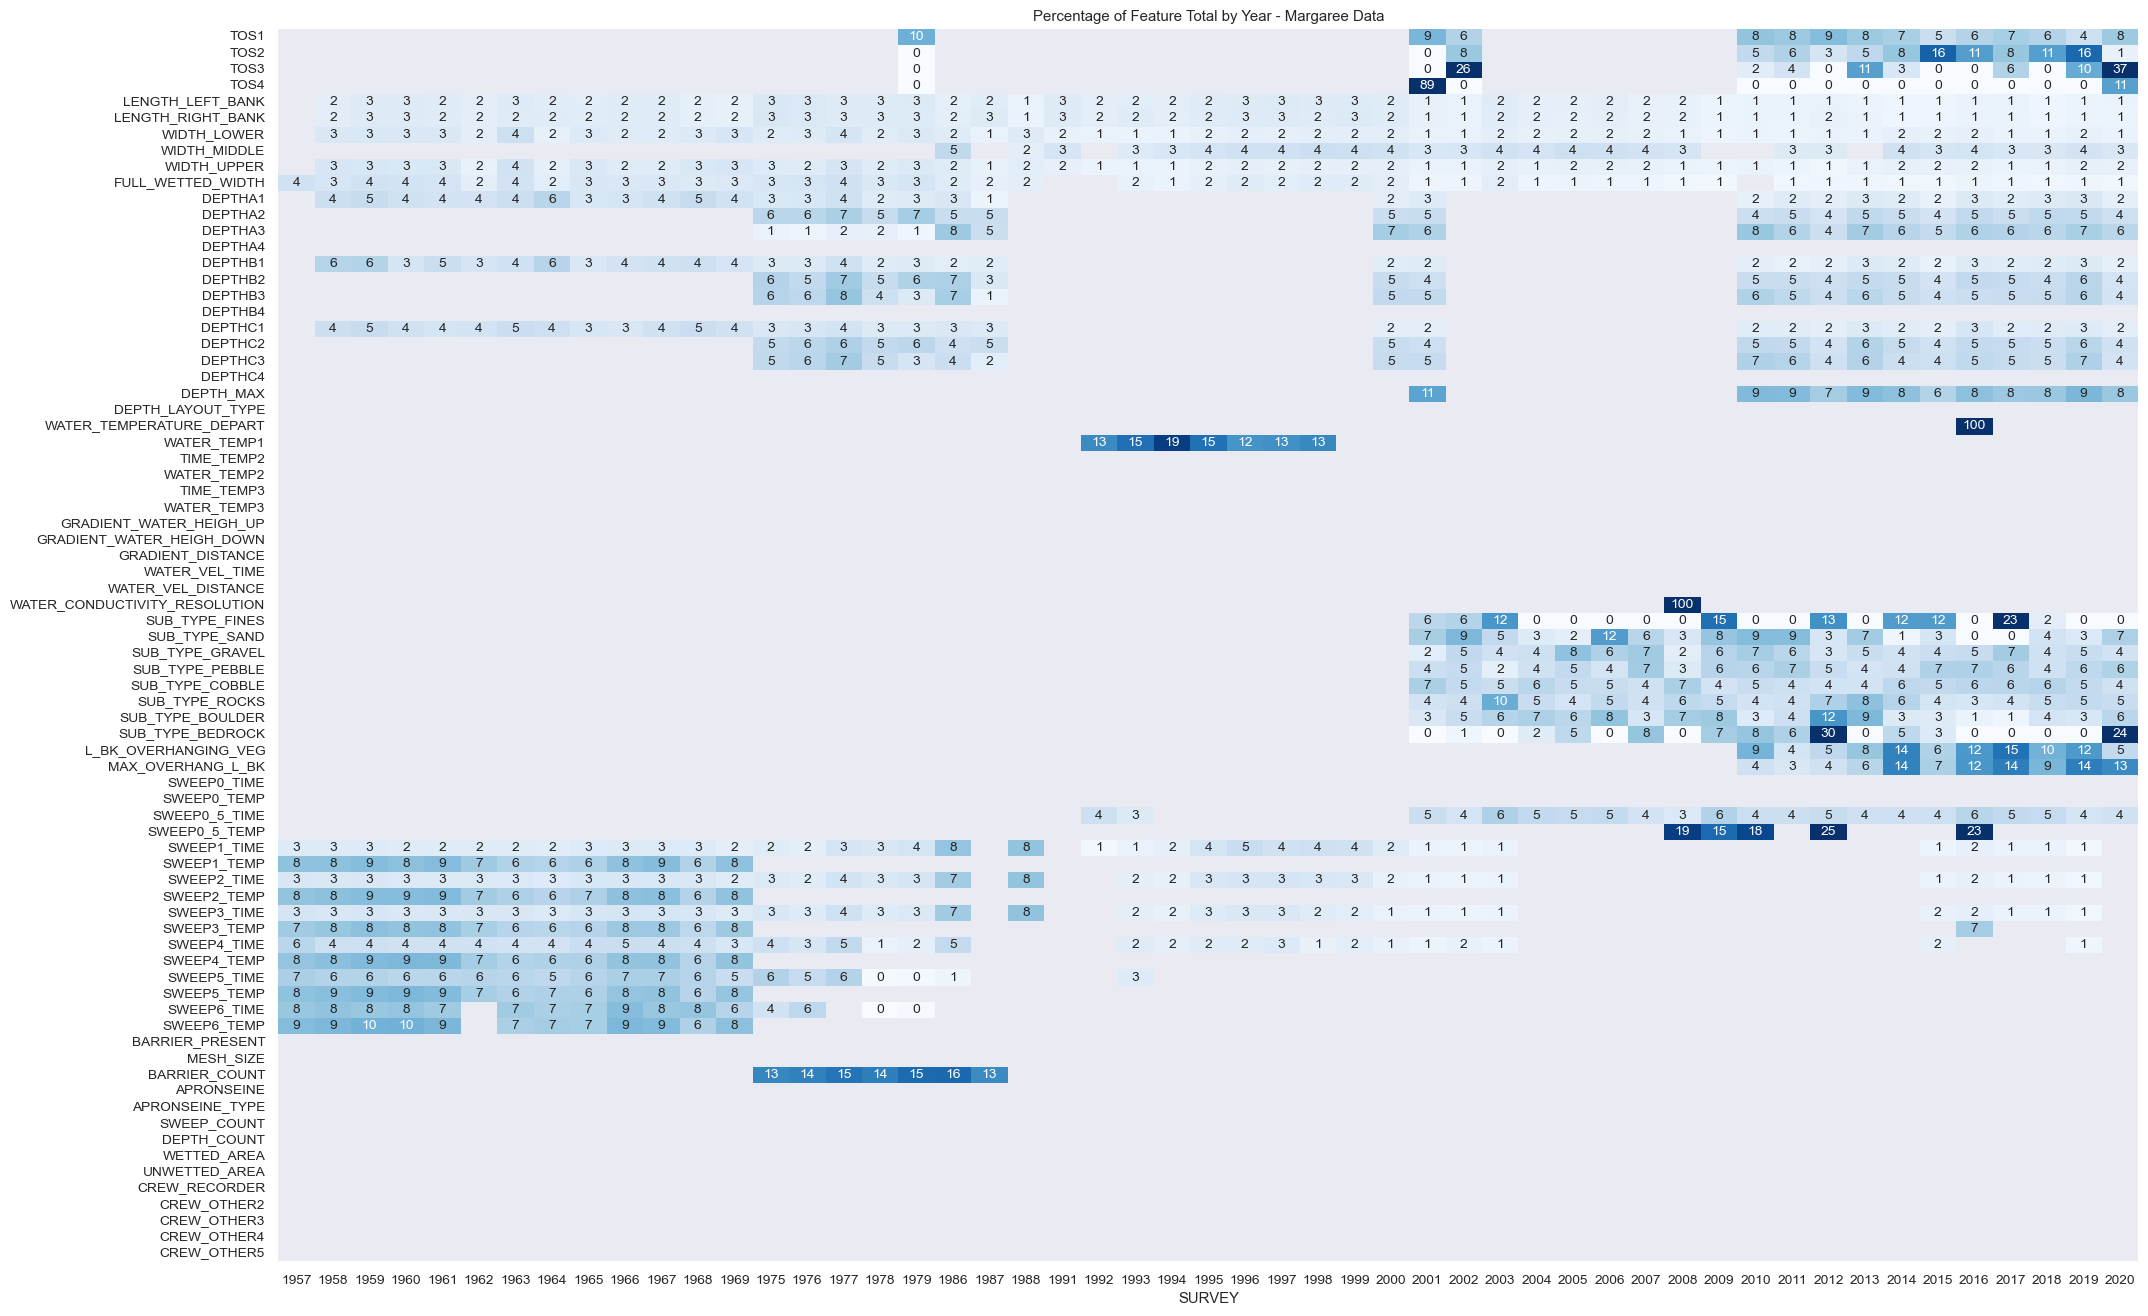

In [58]:
plt.figure(figsize=(24,16))
sns.heatmap(
    (100 * df_msite.groupby('SURVEY').mean() / df_msite.groupby('SURVEY').mean().sum()).drop('ID', axis=1).T, 
    cmap='Blues',
    cbar=False, 
    annot=True, 
    fmt='.0f', 
    annot_kws={"fontsize":10},
    vmax=20
)
plt.title('Percentage of Feature Total by Year - Margaree Data')
plt.show()

### unique values

In [59]:
print_unique(df_gsite)


ID
number of unique values: 244

SURVEY
[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

SITE
['.', 1, 10, '1A', 2, 3, '3A ', '3B', 4, '4(1 of 2)', '4(2of2)', '4B', 5, 6, '6B', 7, '7B', '7b', 8, '8A', '8B', '8b', 9, 98, 99, 997, 998, 999, '9A', 'P4', 'SP 1', 'SP1', nan]

RIVER_NAME
['Barney', "Barney's River", 'Barneys', 'Barneys River', 'East River Pictou', 'Mabou', 'NE Mabou', 'River John', 'River John East Branch', 'River Philip', 'Wallace', 'Wallace River', 'West River Antigonish', 'West River Pictou', 'West river antigonish']

SITE_EVENT_DATE
['2006-08-17', '2006-08-18', '2006-09-26', '2007-09-12', '2007-09-20', '2007-09-21', '2008-08-27', '2008-10-09', '2009-08-19', '2009-09-08', '2009-09-10', '2009-09-11', '2009-09-14', '2009-09-17', '2010-09-09', '2010-09-20', '2010-09-21', '2010-09-22', '2010-09-23', '2010-10-04', '2010-10-05', '2011-09-09', '2011-09-20', '2011-09-21', '2011-09-22', '2011-09-23', '2012-09-19', '2012-09-28', '2012-10-

In [60]:
print_unique(df_msite)


ID
number of unique values: 617

SURVEY
[1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1975, 1976, 1977, 1978, 1979, 1986, 1987, 1988, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

SITE
number of unique values: 105

CGNDB
[' ', 'CACZB', 'CAFTL', 'CAMNO', 'CANHO', 'CARKU', 'CATHP', 'CAWKZ', 'CAXMI', 'CBBOH', 'CBBOII', 'CBBWL', 'CBJVR', 'CBKNG', 'CBPVG', 'CBRCF', nan]

SITE_EVENT_DATE
number of unique values: 434

TOS1
[0.0, 10.0, 100.0, 20.0, 25.0, 30.0, 35.0, 40.0, 5.0, 50.0, 60.0, 65.0, 70.0, 75.0, 80.0, 90.0, 95.0, nan]

TOS2
[0.0, 10.0, 100.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 5.0, 50.0, 60.0, 70.0, 75.0, 80.0, 90.0, 95.0, nan]

TOS3
[0.0, 10.0, 100.0, 20.0, 25.0, 30.0, 40.0, 5.0, 55.0, 70.0, nan]

TOS4
[0.0, 10.0, 20.0, nan]

LENGTH_LEFT_BANK
number of unique values: 285

LENGTH_RIGHT_BANK
number of unique values: 

### Null Features

In [61]:
null_gsite_columns = list(df_gsite.loc[:, df_gsite.isnull().all()].columns)
null_msite_columns = list(df_msite.loc[:, df_msite.isnull().all()].columns)

In [62]:
# only empty columns
pd.merge(
    pd.DataFrame([[x, 'column empty'] for x in null_gsite_columns], columns=['feature', 'gns_site']),
    pd.DataFrame([[x, 'column empty'] for x in null_msite_columns], columns=['feature', 'mar_site']),
    on='feature',
    how='outer'
).fillna('')

feature      gns_site      mar_site
0                         DEPTHA4  column empty  column empty
1                         DEPTHB4  column empty  column empty
2                         DEPTHC4  column empty  column empty
3               DEPTH_LAYOUT_TYPE  column empty  column empty
4                 AIR_TEMPERATURE  column empty              
5        WATER_TEMPERATURE_DEPART  column empty              
6                      TIME_TEMP1  column empty              
7                     WATER_TEMP1  column empty              
8                      TIME_TEMP2  column empty  column empty
9                     WATER_TEMP2  column empty  column empty
10                     TIME_TEMP3  column empty  column empty
11                    WATER_TEMP3  column empty  column empty
12        GRADIENT_WATER_HEIGH_UP  column empty  column empty
13      GRADIENT_WATER_HEIGH_DOWN  column empty  column empty
14              GRADIENT_DISTANCE  column empty  column empty
15                 WATER_VEL_TIME  column empty  column empty
16             WATER_VEL_DISTANCE  column empty  column empty
17  WATER_CONDUCTIVITY_RESOLUTION  column empty              
18                    SWEEP0_TIME  column empty  column empty
19                    SWEEP0_TEMP  column empty  column empty
20                    SWEEP1_TIME  column empty              
21                    SWEEP1_TEMP  column empty              
22                    SWEEP2_TIME  column empty              
23                    SWEEP2_TEMP  column empty              
24                    SWEEP3_TIME  column empty              
25                    SWEEP3_TEMP  column empty              
26                    SWEEP4_TIME  column empty              
27                    SWEEP4_TEMP  column empty              
28                    SWEEP5_TIME  column empty              
29                    SWEEP5_TEMP  column empty              
30                    SWEEP6_TIME  column empty              
31                    SWEEP6_TEMP  column empty              
32                BARRIER_PRESENT  column empty  column empty
33                      MESH_SIZE  column empty  column empty
34                  BARRIER_COUNT  column empty              
35                     APRONSEINE  column empty  column empty
36                APRONSEINE_TYPE  column empty  column empty
37                    SWEEP_COUNT  column empty  column empty
38                    DEPTH_COUNT  column empty  column empty
39                    WETTED_AREA  column empty  column empty
40                  UNWETTED_AREA  column empty  column empty
41                    CREW_BUCKET  column empty              
42                  CREW_RECORDER  column empty  column empty
43                    CREW_OTHER1  column empty              
44                    CREW_OTHER2  column empty  column empty
45                    CREW_OTHER3  column empty  column empty
46                    CREW_OTHER4  column empty  column empty
47                    CREW_OTHER5  column empty  column empty

In [63]:
# including all columns
pd.DataFrame([[x] for x in df_msite.columns], columns=['feature']).merge(
    pd.merge(
        pd.DataFrame([[x, 'column empty'] for x in null_gsite_columns], columns=['feature', 'gns_site']),
        pd.DataFrame([[x, 'column empty'] for x in null_msite_columns], columns=['feature', 'mar_site']),
        on='feature',
        how='outer'
    ),
    on='feature',
    how='outer'
).fillna('')

feature      gns_site      mar_site
0                              ID                            
1                          SURVEY                            
2                            SITE                            
3                           CGNDB                            
4                 SITE_EVENT_DATE                            
5                            TOS1                            
6                            TOS2                            
7                            TOS3                            
8                            TOS4                            
9                LENGTH_LEFT_BANK                            
10              LENGTH_RIGHT_BANK                            
11                    WIDTH_LOWER                            
12                   WIDTH_MIDDLE                            
13                    WIDTH_UPPER                            
14              FULL_WETTED_WIDTH                            
15                        DEPTHA1                            
16                        DEPTHA2                            
17                        DEPTHA3                            
18                        DEPTHA4  column empty  column empty
19                        DEPTHB1                            
20                        DEPTHB2                            
21                        DEPTHB3                            
22                        DEPTHB4  column empty  column empty
23                        DEPTHC1                            
24                        DEPTHC2                            
25                        DEPTHC3                            
26                        DEPTHC4  column empty  column empty
27                      DEPTH_MAX                            
28              DEPTH_LAYOUT_TYPE  column empty  column empty
29                AIR_TEMPERATURE  column empty              
30      WATER_TEMPERATURE_ARRIVAL                            
31       WATER_TEMPERATURE_DEPART  column empty              
32                     TIME_TEMP1  column empty              
33                    WATER_TEMP1  column empty              
34                     TIME_TEMP2  column empty  column empty
35                    WATER_TEMP2  column empty  column empty
36                     TIME_TEMP3  column empty  column empty
37                    WATER_TEMP3  column empty  column empty
38        GRADIENT_WATER_HEIGH_UP  column empty  column empty
39      GRADIENT_WATER_HEIGH_DOWN  column empty  column empty
40              GRADIENT_DISTANCE  column empty  column empty
41                 WATER_VEL_TIME  column empty  column empty
42             WATER_VEL_DISTANCE  column empty  column empty
43                       WATER_PH                            
44             WATER_CONDUCTIVITY                            
45  WATER_CONDUCTIVITY_RESOLUTION  column empty              
46                 SUB_TYPE_FINES                            
47                  SUB_TYPE_SAND                            
48                SUB_TYPE_GRAVEL                            
49                SUB_TYPE_PEBBLE                            
50                SUB_TYPE_COBBLE                            
51                 SUB_TYPE_ROCKS                            
52               SUB_TYPE_BOULDER                            
53               SUB_TYPE_BEDROCK                            
54           L_BK_OVERHANGING_VEG                            
55           R_BK_OVERHANGING_VEG                            
56              MAX_OVERHANG_L_BK                            
57              MAX_OVERHANG_R_BK                            
58                    SWEEP0_TIME  column empty  column empty
59                    SWEEP0_TEMP  column empty  column empty
60                  SWEEP0_5_TIME                            
61                  SWEEP0_5_TEMP                            
62                    SWEEP1_TIME  column empty              
63                    SWEEP1_TEMP  column empty           

### Clean and Update Numeric Columns

##### MAR SITES

In [64]:
# not sure about imputing these ranges.
#  maybe someone was using European notation, but this is not clear
[str(x).replace(' ','') for x in df_msite['ELECTROFISHER_OUTPUT'].unique() if ',' in str(x)]

['0,09-0,12',
 '0,12-0,17',
 '0,10-0,27',
 '0,11-0,23',
 '0,26-0,33',
 '0,20-0,24',
 '0,15-0,26',
 '0,16-0,24',
 '0,14-0,54',
 '0,24-0,50',
 '0,13-0,24',
 '0,19-0,26',
 '0,18-0,28',
 '0,22-0,27',
 '0,10-0,25',
 '0,13-0,23',
 '0,15-0,25',
 '0,33-0.55',
 '0,15-0,35',
 '0,26-0,34',
 '0,26-0,40',
 '0,32-0,48',
 '0,25-0,38',
 '0,18-0,35',
 '0,30-0,45',
 '0,23-0,41']

In [65]:
# loop and look for ranges to impute / non-numeric data
numeric_columns = [
    'AIR_TEMPERATURE', 'WATER_TEMPERATURE_ARRIVAL',
    'WATER_PH', 'WATER_CONDUCTIVITY', 'R_BK_OVERHANGING_VEG',
    'MAX_OVERHANG_R_BK',
    'ELECTROFISHER_CURRENT', 'ELECTROFISHER_VOLTAGE'
]
for col in numeric_columns:
    print(col)
    temp = [x for x in df_msite[col].unique() if not str(x).replace('.','', 1).isnumeric() and not pd.isna(x)]
    print(temp)
    print()


AIR_TEMPERATURE
['11-21']

WATER_TEMPERATURE_ARRIVAL
['19-22', '17.2-21', '17-19', '17.5-19', '19-23', '16-18', '14-15', '17.9-20', '15.2-19.5', '17.8-20.9', '12-12.6', '18-19.8', '11.8-16.5', '12.9-18.5', '12-14', '13.5-13.6', '15.1-18', '13.3-16', '13.5-16.8', '16-17.5', '21.3-25.8', '9.4-14.5', '14-18', '11-17', '18.4-20', '15.5-14.5', '16.0-17.2', '12.5-13.0', '15-19', '17-18', '20-22', '10-14.5', '11.8-15', '16-16', '17.5-17.5', '13-14.5', '14.5-15.5', '20-20', '16-22.5', '15-20', '16.5-23', '14.5-15', '12-16', '21.5-21.5', '12.5-13.5', '13.5-13.5', '12-19', '12.5-18', '15.5-19', '11.6-15', '14-18.5', '15-16.5', '19.5-20', '13.5-20.2', '18.5-23', '15.5-17', '13.5-16', '12.5-16.5', '10-12.5', '11.5-12', '13-16']

WATER_PH
['6.0-7.0']

WATER_CONDUCTIVITY
['70-75', '400-450', '65-70', '90-92', '70-72', '82-89', '80-85', '82-92', '75-76', '65-66', '60-61', '70-78', '58-62', '185-200', '163-175', '255-310', '45-50', '55-65', '270-280', '155-160', '75-78', '200-220', '50-70', '48-65', '

In [66]:
# convert 'upstream 80%' to 80
# flag before fixing
df_msite.loc[df_msite['R_BK_OVERHANGING_VEG']=='upstream 80%', 'FLAG_R_BK_OVERHANGING_VEG'] = df_msite.loc[df_msite['R_BK_OVERHANGING_VEG']=='upstream 80%', 'R_BK_OVERHANGING_VEG']
df_msite.loc[df_msite['R_BK_OVERHANGING_VEG']=='upstream 80%', 'R_BK_OVERHANGING_VEG'] = 80

In [67]:
# no idea what this value should be!? probably either 0.5 or 5.
sorted(list(df_msite['MAX_OVERHANG_R_BK'].unique()), key=str)

[',,5', 0, 0.1, 0.2, 0.3, 0.5, 1, 1.5, 1.75, 10, 2, 2.5, 3, 4, 5, 6, 7, nan]

In [68]:
# convert ',,5' to pd.NA
# flag before nulling
df_msite.loc[df_msite['MAX_OVERHANG_R_BK']==',,5', 'FLAG_MAX_OVERHANG_R_BK'] = df_msite.loc[df_msite['MAX_OVERHANG_R_BK']==',,5', 'MAX_OVERHANG_R_BK']
df_msite.loc[df_msite['MAX_OVERHANG_R_BK']==',,5', 'MAX_OVERHANG_R_BK'] = pd.NA

In [69]:
# flag and convert numeric data
for col in numeric_columns:
    query = (~df_msite[col].astype(str).str.replace('.','', 1, regex=False).str.isnumeric()) & df_msite[col].notnull()
    
    # flag non numeric data
    df_msite.loc[query, f'FLAG_{col}'] = df_msite.loc[query, col]
    
    # impute all numeric - averaging ranges where required
    df_msite.loc[query, col] = df_msite.loc[query, col].apply(range_to_average)
    
    # convert to numeric and coerce errors
    df_msite[col] = pd.to_numeric(df_msite[col], errors='coerce')

In [70]:
# let's check it again...

# loop and look for ranges to impute / non-numeric data
for col in numeric_columns:
    print(col)
    temp = [x for x in df_msite[col].unique() if not str(x).replace('.','', 1).isnumeric() and not pd.isna(x)]
    print(temp)
    print()

AIR_TEMPERATURE
[]

WATER_TEMPERATURE_ARRIVAL
[]

WATER_PH
[]

WATER_CONDUCTIVITY
[]

R_BK_OVERHANGING_VEG
[]

MAX_OVERHANG_R_BK
[]

ELECTROFISHER_CURRENT
[]

ELECTROFISHER_VOLTAGE
[]



In [71]:
for col in [x for x in df_msite.columns if 'FLAG' in x]:
    display(df_msite[df_msite[col].notnull()][[col, f'{col.replace("FLAG_","")}']].sample(5 if 5 <= df_msite[col].notnull().sum() else df_msite[col].notnull().sum()))

FLAG_R_BK_OVERHANGING_VEG  R_BK_OVERHANGING_VEG
504              upstream 80%                  80.0

FLAG_MAX_OVERHANG_R_BK  MAX_OVERHANG_R_BK
535                    ,,5                NaN

FLAG_AIR_TEMPERATURE  AIR_TEMPERATURE
292                11-21             16.0

FLAG_WATER_TEMPERATURE_ARRIVAL  WATER_TEMPERATURE_ARRIVAL
249                          12-16                       14.0
214                        13.3-16                       14.7
252                          16-16                       16.0
271                      12.5-16.5                       14.5
174                          19-22                       20.5

FLAG_WATER_PH  WATER_PH
174       6.0-7.0       6.5

FLAG_WATER_CONDUCTIVITY  WATER_CONDUCTIVITY
200                   82-89                85.5
218                 255-310               282.5
181                 400-450               425.0
240                   85-88                86.5
256                   65-70                67.5

FLAG_ELECTROFISHER_CURRENT  ELECTROFISHER_CURRENT
215                    .45-1.0                    0.7
257                      .5-.8                    0.7
201                     .2-.48                    0.3
175                    .25-.50                    0.4
180                     .9-1.1                    1.0

FLAG_ELECTROFISHER_VOLTAGE  ELECTROFISHER_VOLTAGE
215                    175-220                  197.5
203                    130-200                  165.0
201                    200-250                  225.0
194                    275-350                  312.5
486                    325-350                  337.5

##### GNS SITES

In [72]:
# loop and look for ranges to impute / non-numeric data

numeric_columns = [
    'TOS1', 'TOS2', 'TOS3', 'TOS4', 'WIDTH_LOWER', 'WIDTH_MIDDLE', 
    'DEPTHA1', 'DEPTHA2', 'DEPTHA3', 'DEPTHB1', 'DEPTHB2', 'DEPTHB3', 'DEPTHC1', 'DEPTHC2', 'DEPTHC3', 
    'WATER_TEMPERATURE_ARRIVAL', 'WATER_PH', 
    'ELECTROFISHER_CURRENT'
]
for col in numeric_columns:
    temp = [x for x in df_gsite[col].unique() if not str(x).replace('.','', 1).isnumeric() and not pd.isna(x)]
    if temp:
        print(col)
        print(temp)
        print()

TOS1
['.']

TOS2
['.']

TOS3
['.']

TOS4
['.']

WIDTH_LOWER
['~6', '.']

WIDTH_MIDDLE
['.']

DEPTHA1
['.']

DEPTHA2
['.']

DEPTHA3
['.']

DEPTHB1
['.']

DEPTHB2
['.']

DEPTHB3
['.']

DEPTHC1
['.']

DEPTHC2
['.']

DEPTHC3
['.']

WATER_TEMPERATURE_ARRIVAL
['.']

WATER_PH
['.']

ELECTROFISHER_CURRENT
['0.2 - 0.8', '0.17 - 0.63', '0.15 - 0.55', '0.3 - 0.5', '0.12 - 0.48', '0.12 - 0.35', '0.2 - 0.5', '0.25 - 0.4', '0.1 - 0.25', '0.17 - 0.33', '0.1 - 0.2', '0.05 - 0.2', '0.07 - 0.2']



In [73]:
# WIDTH_LOWER should have '~6' converted to 6
# flag first
df_gsite.loc[df_gsite['WIDTH_LOWER'] == '~6', 'FLAG_WIDTH_LOWER'] = df_gsite.loc[df_gsite['WIDTH_LOWER'] == '~6', 'WIDTH_LOWER']
df_gsite.loc[df_gsite['WIDTH_LOWER'] == '~6', 'WIDTH_LOWER'] = 6

In [74]:
df_gsite[df_gsite['FLAG_WIDTH_LOWER'].notnull()][['FLAG_WIDTH_LOWER', 'WIDTH_LOWER']]

FLAG_WIDTH_LOWER WIDTH_LOWER
42               ~6           6

In [75]:
# flag and impute numeric data from ranges
for col in numeric_columns:
    # flag data to be imputed
    df_gsite.loc[(~df_gsite[col].astype(str).str.replace('.','', 1, regex=False).str.isnumeric()) & df_gsite[col].notnull(), f'FLAG_{col}'] = df_gsite.loc[(~df_gsite[col].astype(str).str.replace('.','', 1, regex=False).str.isnumeric()) & df_gsite[col].notnull(), col]
    # impute value from ranges
    df_gsite.loc[(~df_gsite[col].astype(str).str.replace('.','', 1, regex=False).str.isnumeric()) & df_gsite[col].notnull(), col] = df_gsite.loc[(~df_gsite[col].astype(str).str.replace('.','', 1, regex=False).str.isnumeric()) & df_gsite[col].notnull(), col].apply(range_to_average)
    # convert to numeric and coerce errors
    df_gsite[col] = pd.to_numeric(df_gsite[col], errors='coerce')

In [76]:
df_gsite[df_gsite['FLAG_WIDTH_LOWER'].notnull()][['FLAG_WIDTH_LOWER', 'WIDTH_LOWER']]

FLAG_WIDTH_LOWER  WIDTH_LOWER
42               ~6          6.0
56                .          NaN

In [77]:
for col in numeric_columns:
    temp = df_gsite[df_gsite[f'FLAG_{col}'].notnull()][[f'FLAG_{col}', col]]
    display(temp.sample(min(temp.shape[0],5)))

FLAG_TOS1  TOS1
31         .   NaN
36         .   NaN
38         .   NaN
30         .   NaN
34         .   NaN

FLAG_TOS2  TOS2
29         .   NaN
28         .   NaN
31         .   NaN
32         .   NaN
30         .   NaN

FLAG_TOS3  TOS3
32         .   NaN
31         .   NaN
27         .   NaN
26         .   NaN
33         .   NaN

FLAG_TOS4  TOS4
31         .   NaN
36         .   NaN
34         .   NaN
37         .   NaN
33         .   NaN

FLAG_WIDTH_LOWER  WIDTH_LOWER
42               ~6          6.0
56                .          NaN

FLAG_WIDTH_MIDDLE  WIDTH_MIDDLE
46                 .           NaN
29                 .           NaN
40                 .           NaN
30                 .           NaN
26                 .           NaN

FLAG_DEPTHA1  DEPTHA1
55            .      NaN

FLAG_DEPTHA2  DEPTHA2
55            .      NaN

FLAG_DEPTHA3  DEPTHA3
55            .      NaN

FLAG_DEPTHB1  DEPTHB1
55            .      NaN
53            .      NaN

FLAG_DEPTHB2  DEPTHB2
53            .      NaN
55            .      NaN

FLAG_DEPTHB3  DEPTHB3
53            .      NaN
55            .      NaN

FLAG_DEPTHC1  DEPTHC1
55            .      NaN

FLAG_DEPTHC2  DEPTHC2
55            .      NaN

FLAG_DEPTHC3  DEPTHC3
55            .      NaN

FLAG_WATER_TEMPERATURE_ARRIVAL  WATER_TEMPERATURE_ARRIVAL
56                              .                        NaN

FLAG_WATER_PH  WATER_PH
48             .       NaN
51             .       NaN
74             .       NaN
56             .       NaN
44             .       NaN

FLAG_ELECTROFISHER_CURRENT  ELECTROFISHER_CURRENT
222                 0.05 - 0.2                    0.1
219                  0.1 - 0.2                    0.2
223                 0.07 - 0.2                    0.1
217                 0.1 - 0.25                    0.2
214                  0.2 - 0.5                    0.3

In [78]:
for col in numeric_columns:
    temp = [x for x in df_gsite[col].unique() if not str(x).replace('.','', 1).isnumeric() and not pd.isna(x)]
    if temp != ['.']:
        print(col)
        print(temp)
        print()

TOS1
[]

TOS2
[]

TOS3
[]

TOS4
[]

WIDTH_LOWER
[]

WIDTH_MIDDLE
[]

DEPTHA1
[]

DEPTHA2
[]

DEPTHA3
[]

DEPTHB1
[]

DEPTHB2
[]

DEPTHB3
[]

DEPTHC1
[]

DEPTHC2
[]

DEPTHC3
[]

WATER_TEMPERATURE_ARRIVAL
[]

WATER_PH
[]

ELECTROFISHER_CURRENT
[]



### Site Tables EDA

In [79]:
[x for x in df_gsite.columns if x[0:4]=='FLAG']

['FLAG_WIDTH_LOWER',
 'FLAG_TOS1',
 'FLAG_TOS2',
 'FLAG_TOS3',
 'FLAG_TOS4',
 'FLAG_WIDTH_MIDDLE',
 'FLAG_DEPTHA1',
 'FLAG_DEPTHA2',
 'FLAG_DEPTHA3',
 'FLAG_DEPTHB1',
 'FLAG_DEPTHB2',
 'FLAG_DEPTHB3',
 'FLAG_DEPTHC1',
 'FLAG_DEPTHC2',
 'FLAG_DEPTHC3',
 'FLAG_WATER_TEMPERATURE_ARRIVAL',
 'FLAG_WATER_PH',
 'FLAG_ELECTROFISHER_CURRENT']





=========================== FLAG_AIR_TEMPERATURE ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
COLUMN MISSING OR NULL: FLAG_AIR_TEMPERATURE

		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: FLAG_AIR_TEMPERATURE 

UNIQUE numbers, strings, blanks, null = (0, 1, 0, 1)
number of numeric = 0
number of strings = 1
number of blanks = 0
number of null =  616




=========================== FLAG_DEPTHA1 ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: FLAG_DEPTHA1 

UNIQUE numbers, strings, blanks, null = (0, 1, 0, 1)
number of numeric = 0
number of strings = 1
number of blanks = 0
number of null =  243

		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
COLUMN MISSING OR NULL: FLAG_DEPTHA1




=========================== FLAG_DEPTHA2 ===========================


		<<<<<  GNS  >>>>>

------------------------

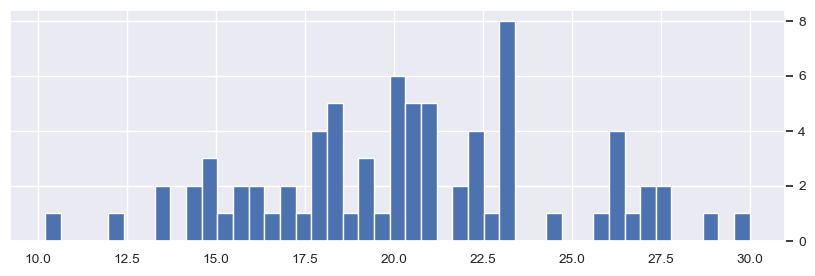


------------------------------------------------
Time Series:AIR_TEMPERATURE
NUMERICAL


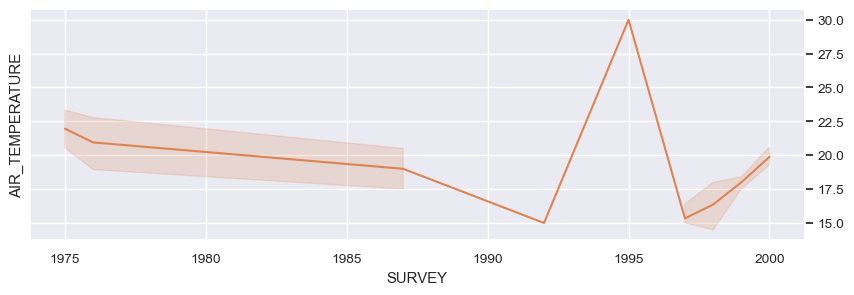





=========================== BARRIER_COUNT ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
COLUMN MISSING OR NULL: BARRIER_COUNT

		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: BARRIER_COUNT 

UNIQUE numbers, strings, blanks, null = (3, 0, 0, 1)
number of numeric = 119
number of strings = 0
number of blanks = 0
number of null =  498

--------------------------------------------------
Histogram: BARRIER_COUNT
NUMERICAL


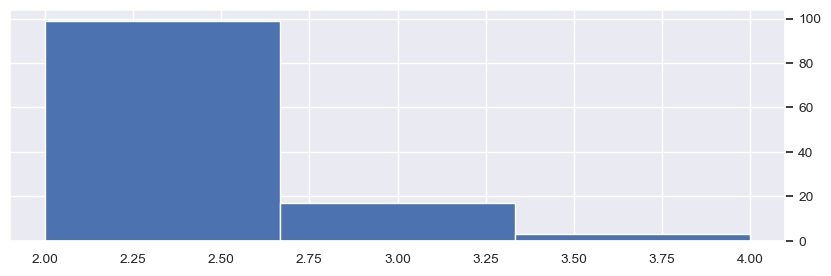


------------------------------------------------
Time Series:BARRIER_COUNT
NUMERICAL


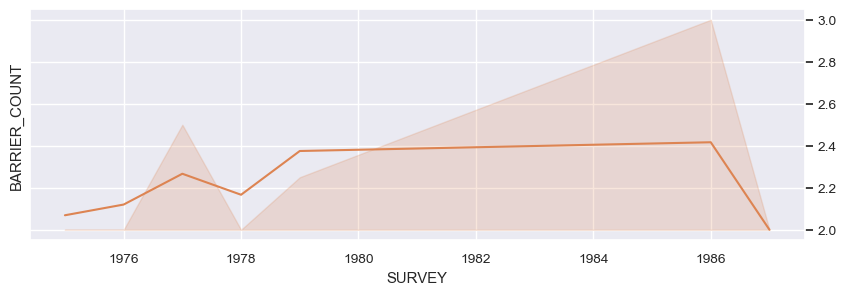





=========================== CGNDB ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
COLUMN MISSING OR NULL: CGNDB

		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: CGNDB 

UNIQUE numbers, strings, blanks, null = (0, 16, 1, 1)
number of numeric = 0
number of strings = 223
number of blanks = 1
number of null =  394

--------------------------------------------------
Histogram: CGNDB
CATEGORICAL


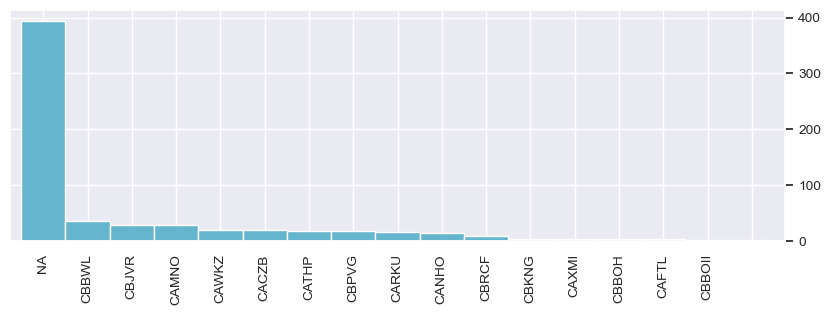


------------------------------------------------
Time Series:CGNDB
CATEGORICAL


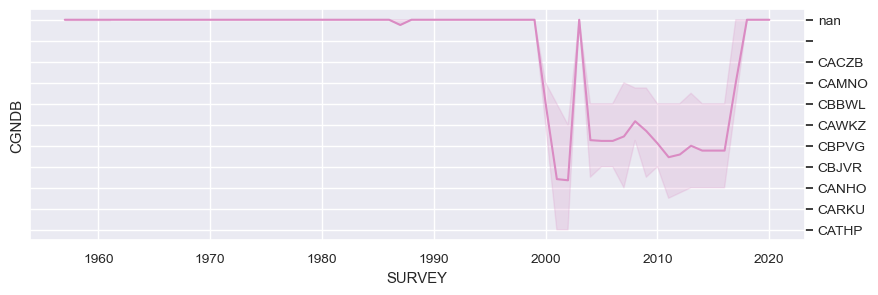





=========================== CREW_BUCKET ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
COLUMN MISSING OR NULL: CREW_BUCKET

		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: CREW_BUCKET 

UNIQUE numbers, strings, blanks, null = (0, 9, 0, 1)
number of numeric = 0
number of strings = 21
number of blanks = 0
number of null =  596

--------------------------------------------------
Histogram: CREW_BUCKET
CATEGORICAL


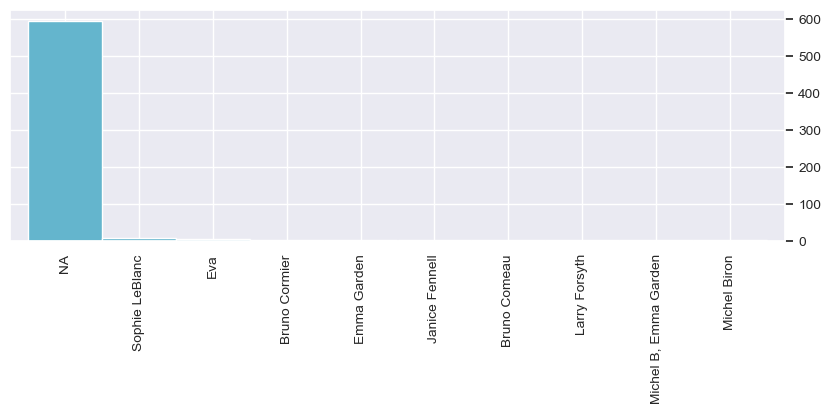


------------------------------------------------
Time Series:CREW_BUCKET
CATEGORICAL


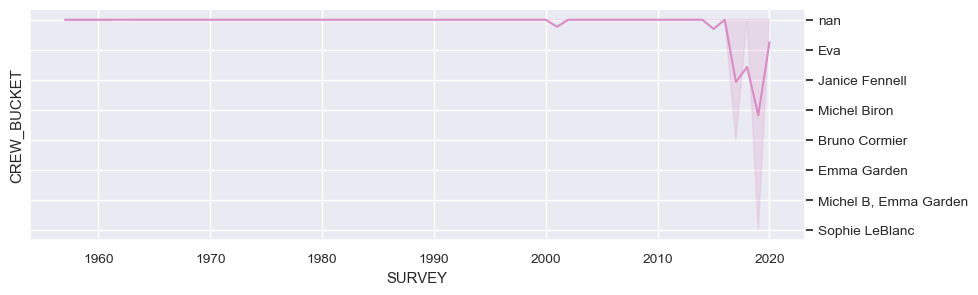





=========================== CREW_DIPNET ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: CREW_DIPNET 

UNIQUE numbers, strings, blanks, null = (0, 15, 0, 1)
number of numeric = 0
number of strings = 128
number of blanks = 0
number of null =  116

--------------------------------------------------
Histogram: CREW_DIPNET
CATEGORICAL


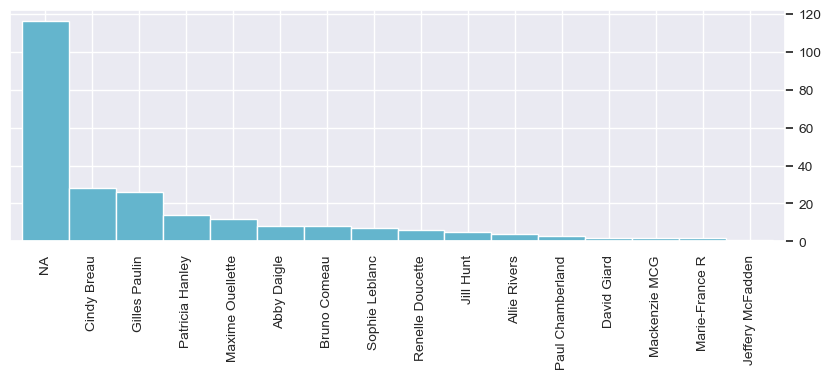


------------------------------------------------
Time Series:CREW_DIPNET
CATEGORICAL


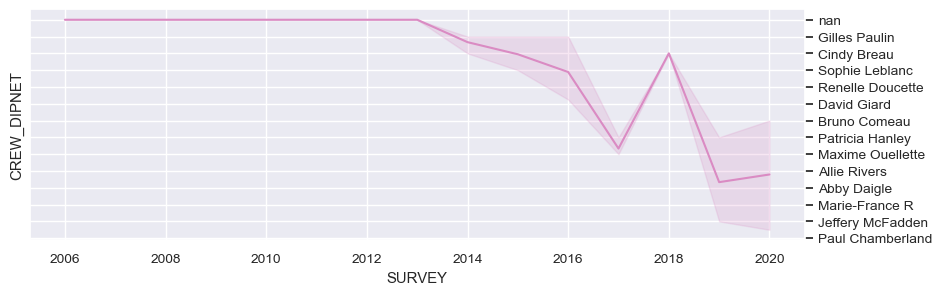


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: CREW_DIPNET 

UNIQUE numbers, strings, blanks, null = (0, 34, 0, 1)
number of numeric = 0
number of strings = 286
number of blanks = 0
number of null =  331

--------------------------------------------------
Histogram: CREW_DIPNET
CATEGORICAL


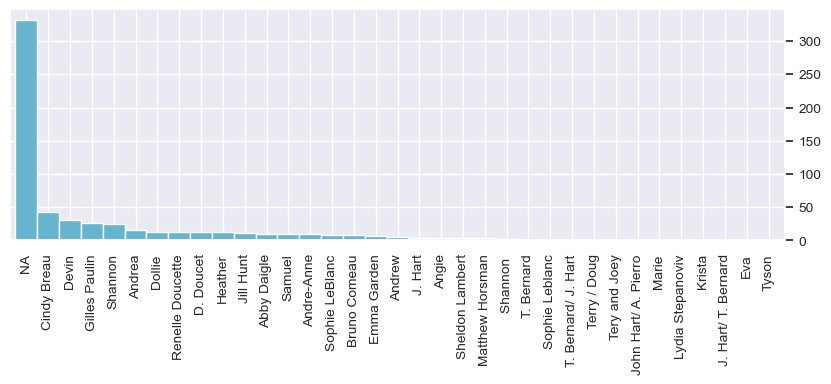


------------------------------------------------
Time Series:CREW_DIPNET
CATEGORICAL


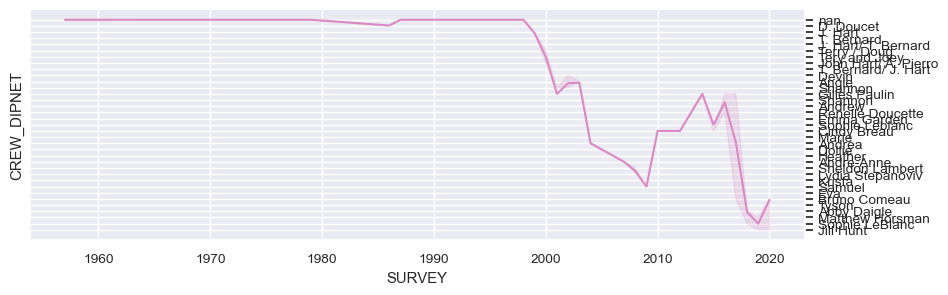





=========================== CREW_OTHER1 ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
COLUMN MISSING OR NULL: CREW_OTHER1

		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: CREW_OTHER1 

UNIQUE numbers, strings, blanks, null = (0, 4, 0, 1)
number of numeric = 0
number of strings = 16
number of blanks = 0
number of null =  601

--------------------------------------------------
Histogram: CREW_OTHER1
CATEGORICAL


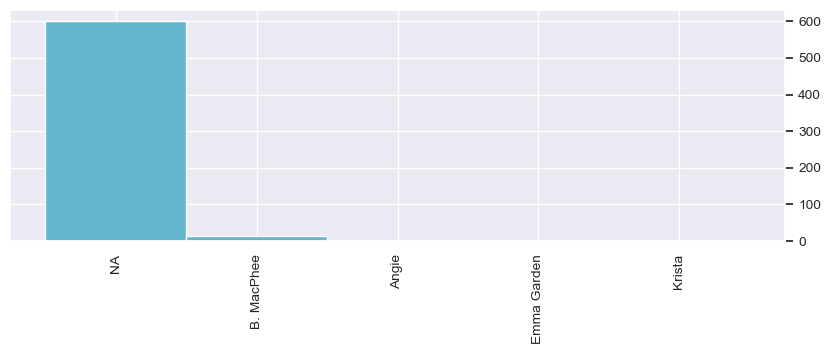


------------------------------------------------
Time Series:CREW_OTHER1
CATEGORICAL


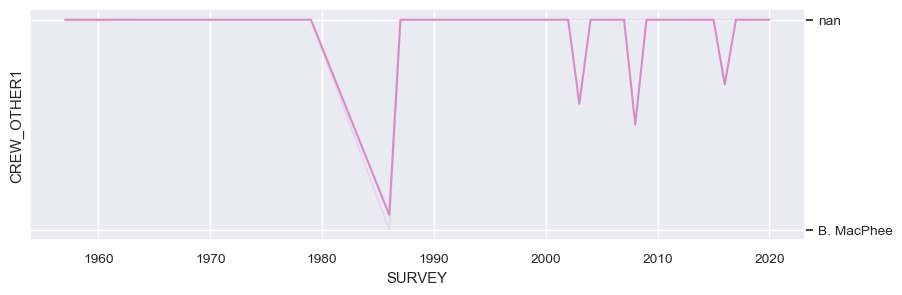





=========================== CREW_PROBE ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: CREW_PROBE 

UNIQUE numbers, strings, blanks, null = (0, 8, 0, 1)
number of numeric = 0
number of strings = 128
number of blanks = 0
number of null =  116

--------------------------------------------------
Histogram: CREW_PROBE
CATEGORICAL


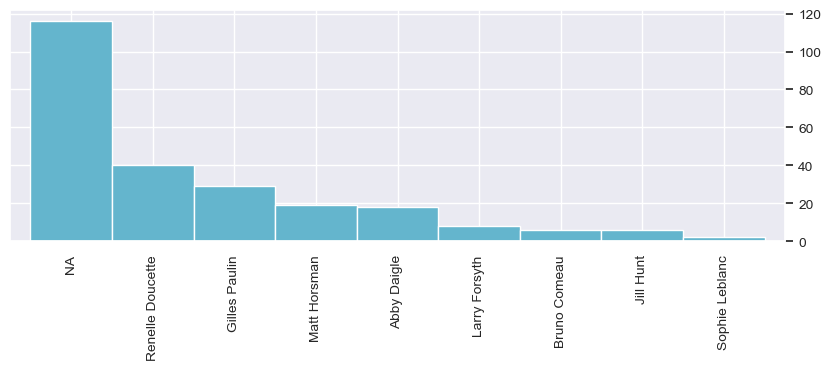


------------------------------------------------
Time Series:CREW_PROBE
CATEGORICAL


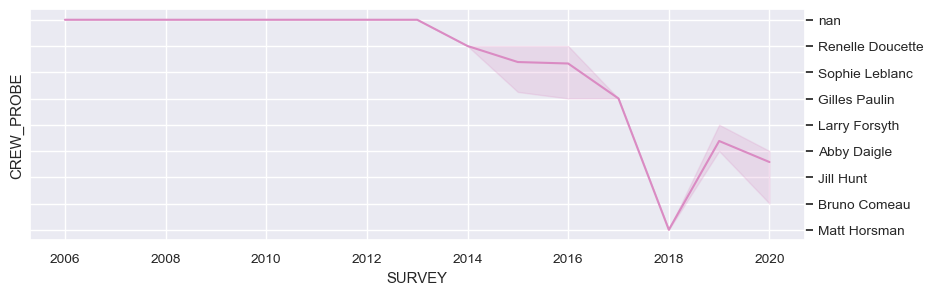


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: CREW_PROBE 

UNIQUE numbers, strings, blanks, null = (0, 31, 0, 1)
number of numeric = 0
number of strings = 420
number of blanks = 0
number of null =  197

--------------------------------------------------
Histogram: CREW_PROBE
CATEGORICAL


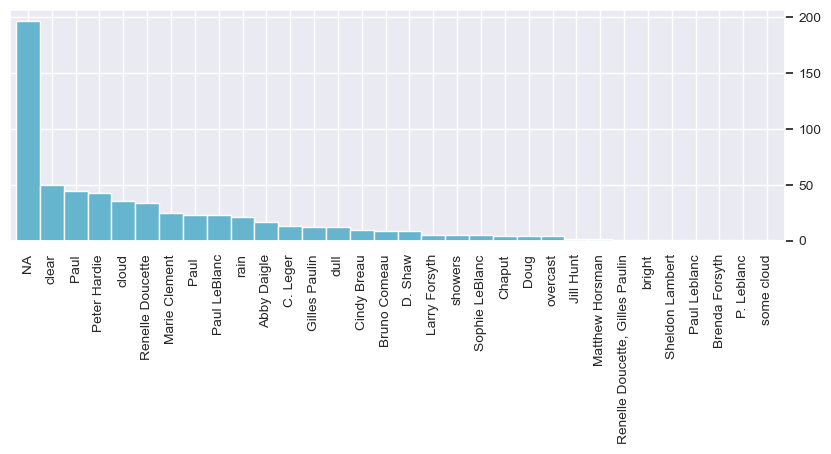


------------------------------------------------
Time Series:CREW_PROBE
CATEGORICAL


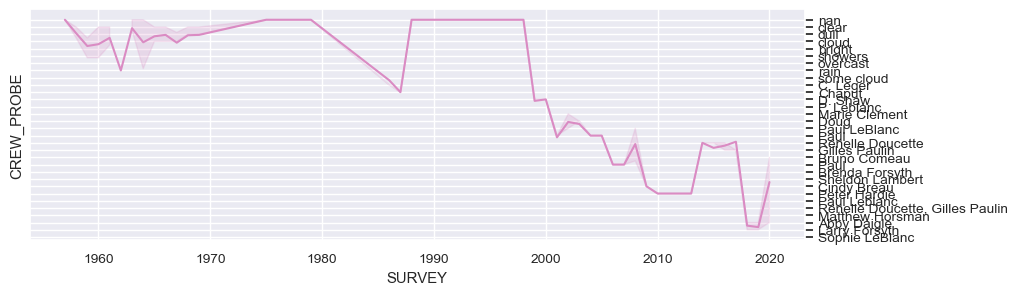





=========================== CREW_SEINE ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: CREW_SEINE 

UNIQUE numbers, strings, blanks, null = (0, 15, 0, 1)
number of numeric = 0
number of strings = 128
number of blanks = 0
number of null =  116

--------------------------------------------------
Histogram: CREW_SEINE
CATEGORICAL


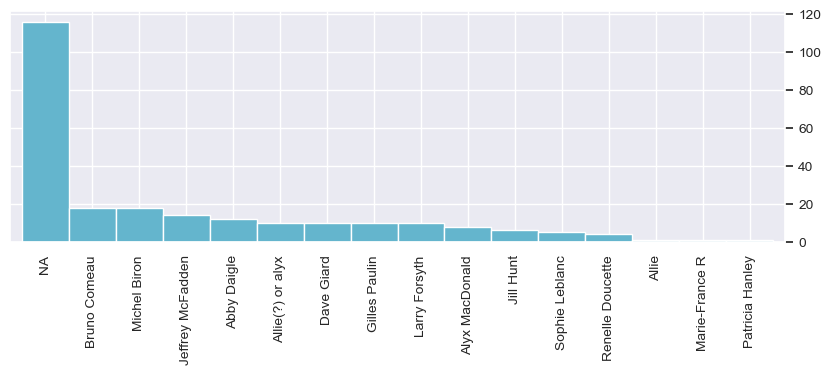


------------------------------------------------
Time Series:CREW_SEINE
CATEGORICAL


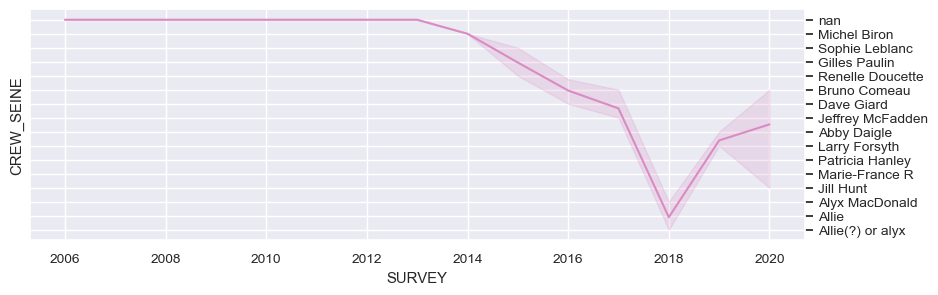


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: CREW_SEINE 

UNIQUE numbers, strings, blanks, null = (0, 39, 0, 1)
number of numeric = 0
number of strings = 285
number of blanks = 0
number of null =  332

--------------------------------------------------
Histogram: CREW_SEINE
CATEGORICAL


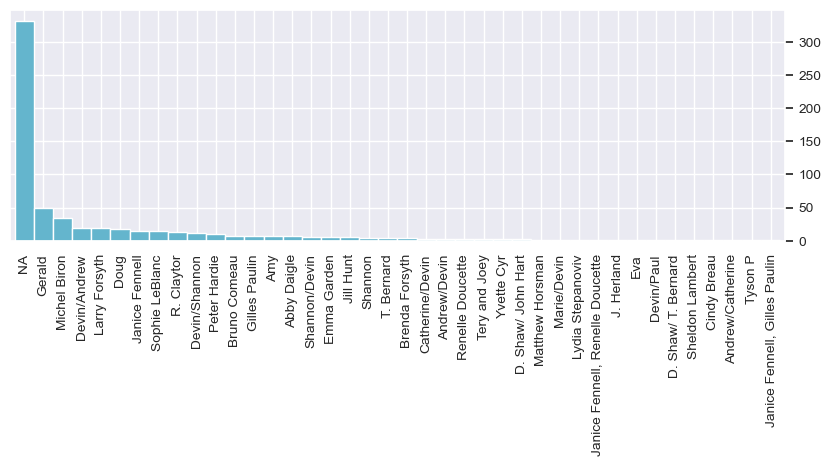


------------------------------------------------
Time Series:CREW_SEINE
CATEGORICAL


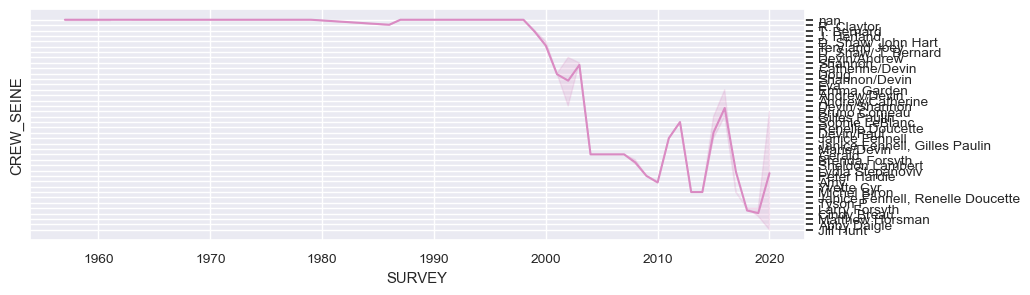





=========================== DEPTHA1 ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: DEPTHA1 

UNIQUE numbers, strings, blanks, null = (45, 0, 0, 1)
number of numeric = 201
number of strings = 0
number of blanks = 0
number of null =  43

--------------------------------------------------
Histogram: DEPTHA1
NUMERICAL


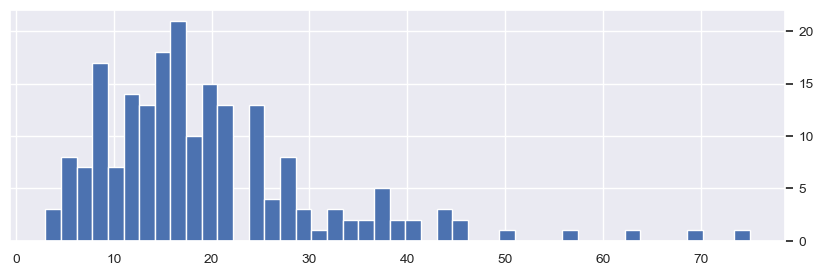


------------------------------------------------
Time Series:DEPTHA1
NUMERICAL


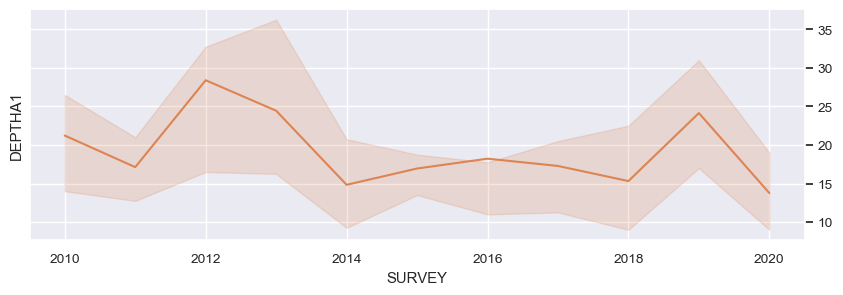


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: DEPTHA1 

UNIQUE numbers, strings, blanks, null = (91, 0, 0, 1)
number of numeric = 371
number of strings = 0
number of blanks = 0
number of null =  246

--------------------------------------------------
Histogram: DEPTHA1
NUMERICAL


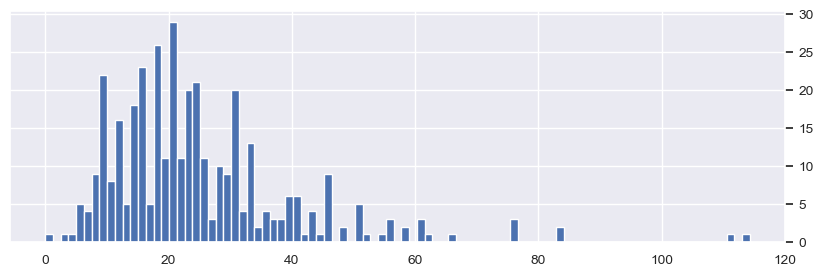


------------------------------------------------
Time Series:DEPTHA1
NUMERICAL


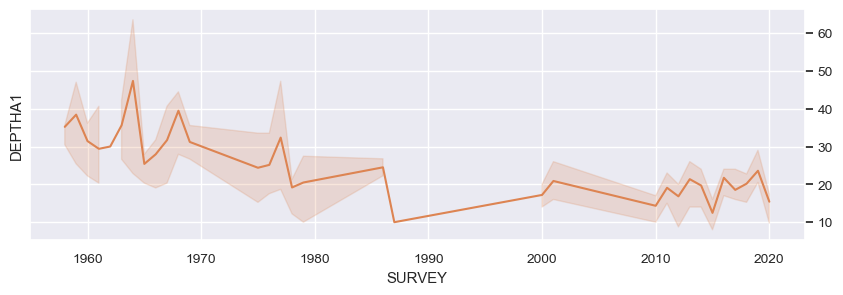





=========================== DEPTHA2 ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: DEPTHA2 

UNIQUE numbers, strings, blanks, null = (47, 0, 0, 1)
number of numeric = 201
number of strings = 0
number of blanks = 0
number of null =  43

--------------------------------------------------
Histogram: DEPTHA2
NUMERICAL


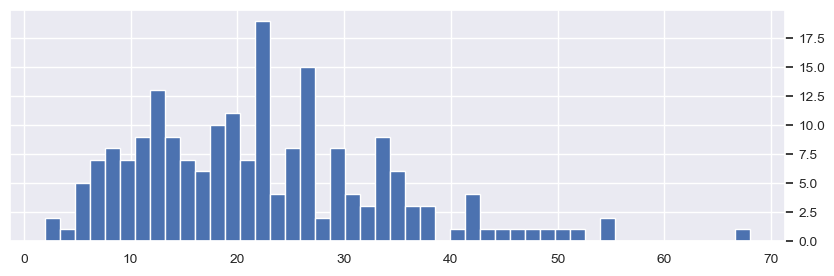


------------------------------------------------
Time Series:DEPTHA2
NUMERICAL


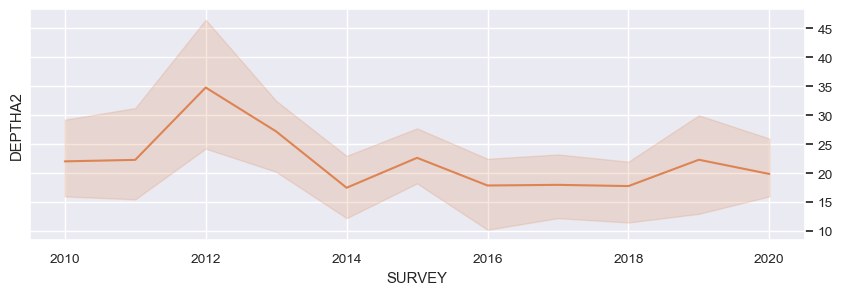


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: DEPTHA2 

UNIQUE numbers, strings, blanks, null = (80, 0, 0, 1)
number of numeric = 254
number of strings = 0
number of blanks = 0
number of null =  363

--------------------------------------------------
Histogram: DEPTHA2
NUMERICAL


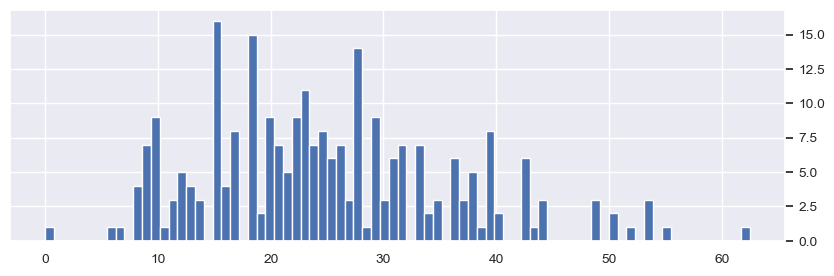


------------------------------------------------
Time Series:DEPTHA2
NUMERICAL


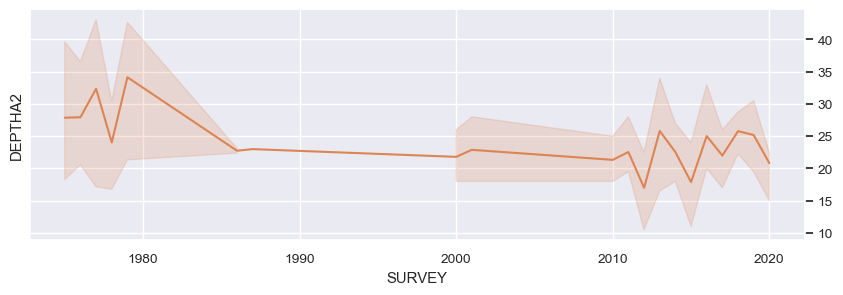





=========================== DEPTHA3 ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: DEPTHA3 

UNIQUE numbers, strings, blanks, null = (50, 0, 0, 1)
number of numeric = 201
number of strings = 0
number of blanks = 0
number of null =  43

--------------------------------------------------
Histogram: DEPTHA3
NUMERICAL


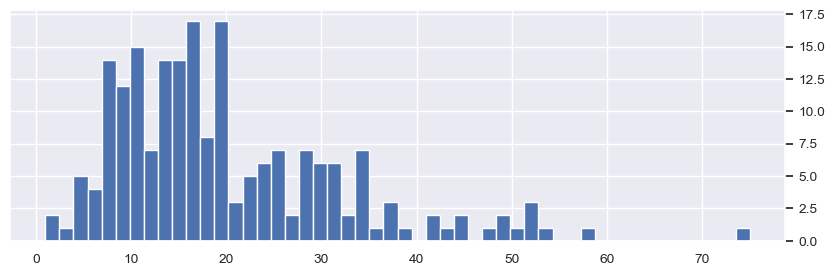


------------------------------------------------
Time Series:DEPTHA3
NUMERICAL


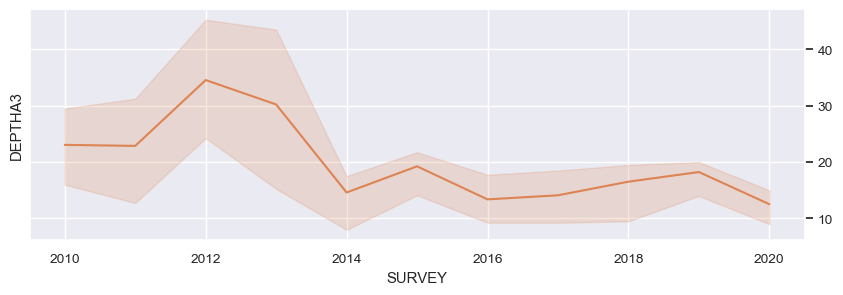


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: DEPTHA3 

UNIQUE numbers, strings, blanks, null = (83, 0, 0, 1)
number of numeric = 253
number of strings = 0
number of blanks = 0
number of null =  364

--------------------------------------------------
Histogram: DEPTHA3
NUMERICAL


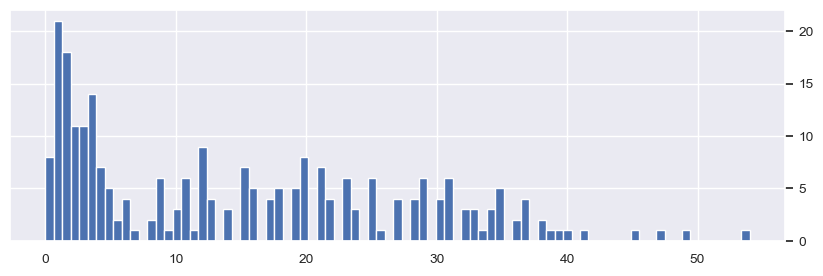


------------------------------------------------
Time Series:DEPTHA3
NUMERICAL


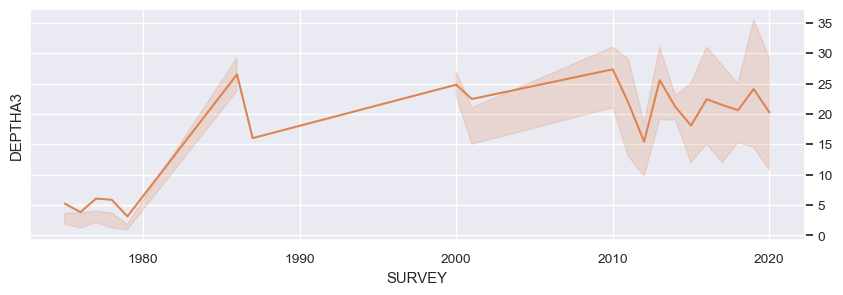





=========================== DEPTHB1 ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: DEPTHB1 

UNIQUE numbers, strings, blanks, null = (40, 0, 0, 1)
number of numeric = 198
number of strings = 0
number of blanks = 0
number of null =  46

--------------------------------------------------
Histogram: DEPTHB1
NUMERICAL


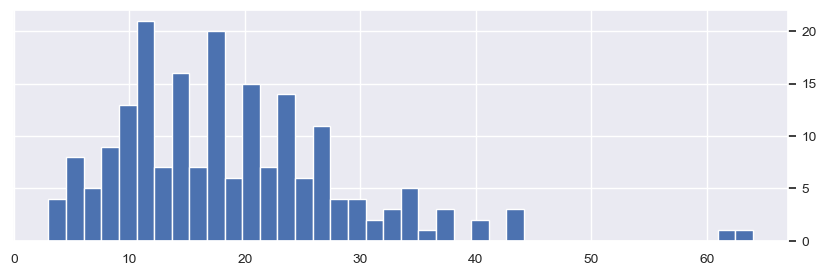


------------------------------------------------
Time Series:DEPTHB1
NUMERICAL


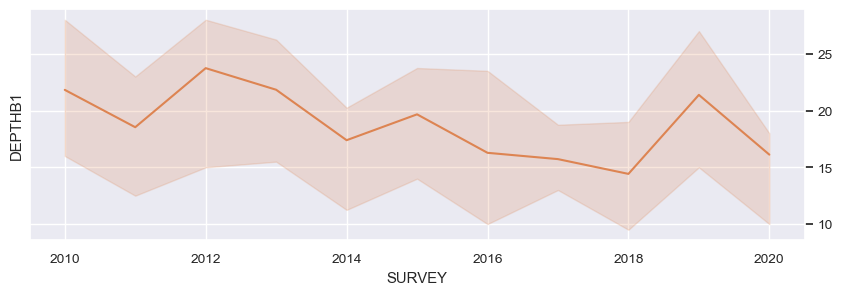


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: DEPTHB1 

UNIQUE numbers, strings, blanks, null = (96, 0, 0, 1)
number of numeric = 374
number of strings = 0
number of blanks = 0
number of null =  243

--------------------------------------------------
Histogram: DEPTHB1
NUMERICAL


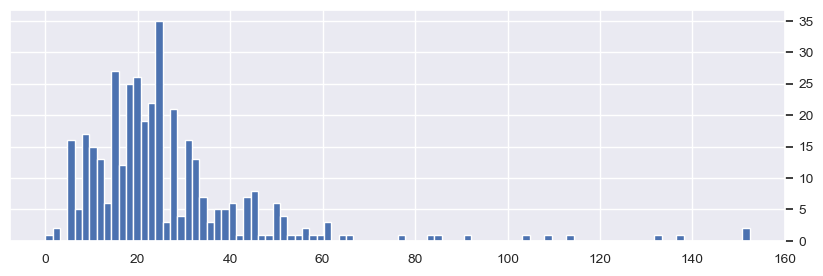


------------------------------------------------
Time Series:DEPTHB1
NUMERICAL


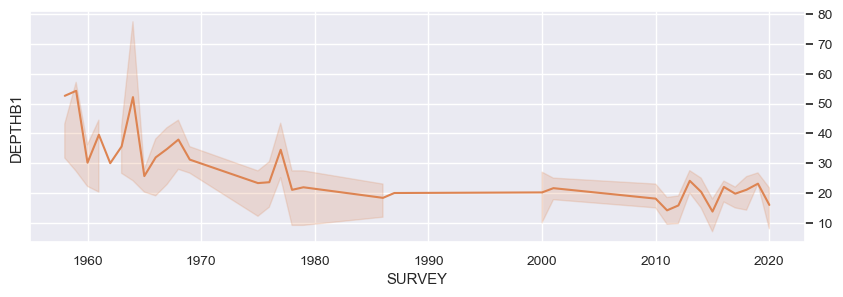





=========================== DEPTHB2 ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: DEPTHB2 

UNIQUE numbers, strings, blanks, null = (43, 0, 0, 1)
number of numeric = 198
number of strings = 0
number of blanks = 0
number of null =  46

--------------------------------------------------
Histogram: DEPTHB2
NUMERICAL


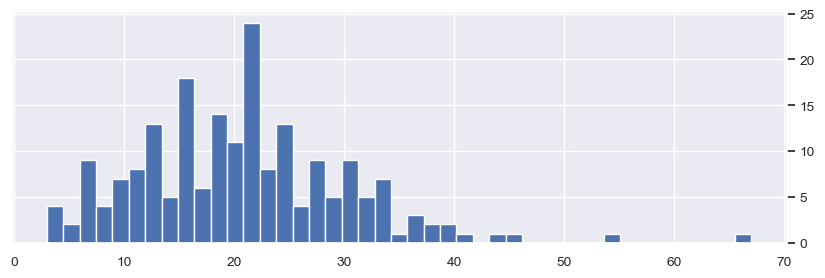


------------------------------------------------
Time Series:DEPTHB2
NUMERICAL


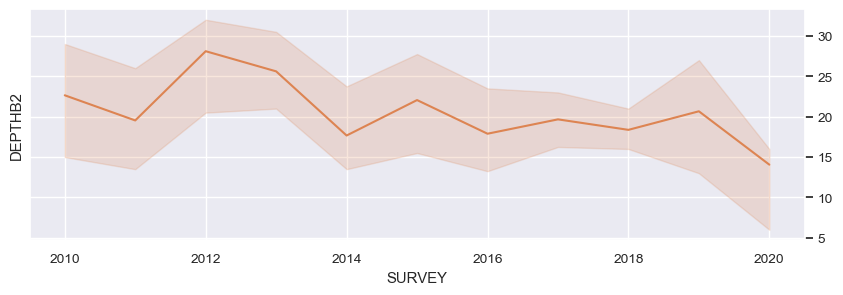


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: DEPTHB2 

UNIQUE numbers, strings, blanks, null = (81, 0, 0, 1)
number of numeric = 255
number of strings = 0
number of blanks = 0
number of null =  362

--------------------------------------------------
Histogram: DEPTHB2
NUMERICAL


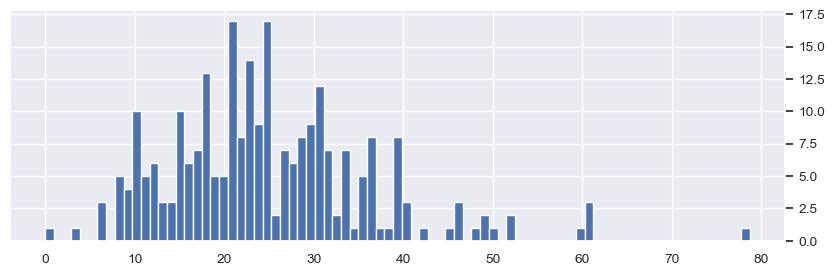


------------------------------------------------
Time Series:DEPTHB2
NUMERICAL


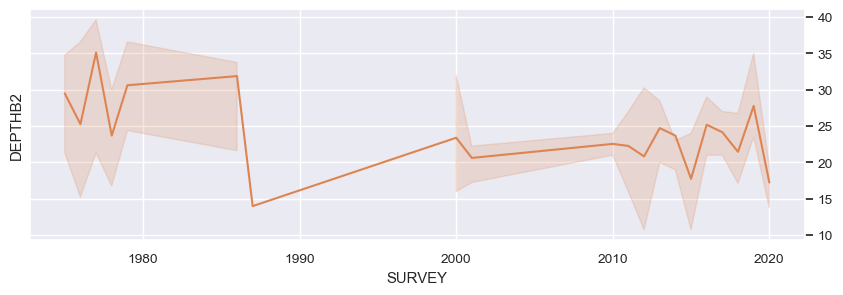





=========================== DEPTHB3 ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: DEPTHB3 

UNIQUE numbers, strings, blanks, null = (45, 0, 0, 1)
number of numeric = 198
number of strings = 0
number of blanks = 0
number of null =  46

--------------------------------------------------
Histogram: DEPTHB3
NUMERICAL


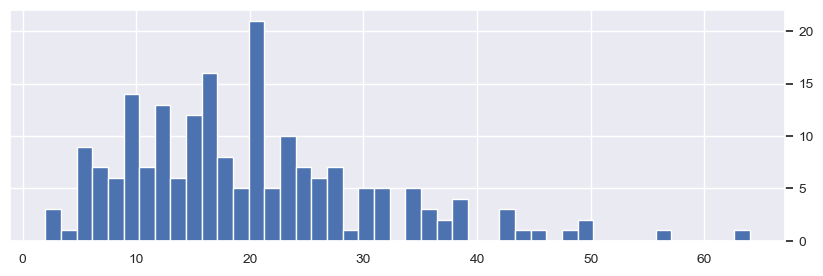


------------------------------------------------
Time Series:DEPTHB3
NUMERICAL


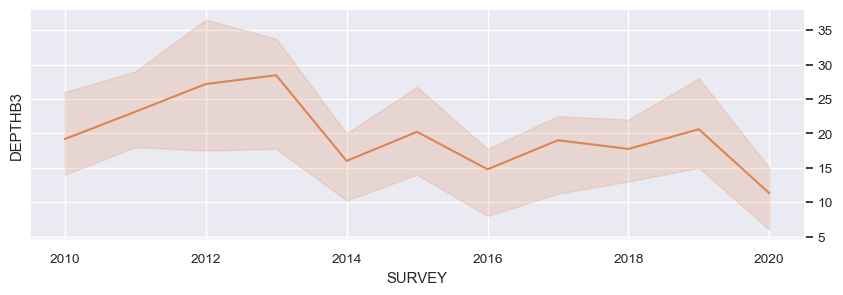


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: DEPTHB3 

UNIQUE numbers, strings, blanks, null = (73, 0, 0, 1)
number of numeric = 255
number of strings = 0
number of blanks = 0
number of null =  362

--------------------------------------------------
Histogram: DEPTHB3
NUMERICAL


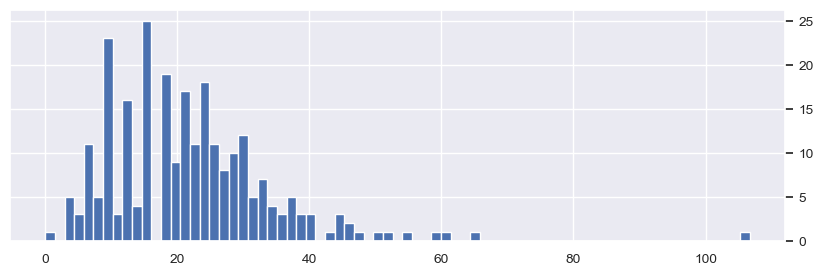


------------------------------------------------
Time Series:DEPTHB3
NUMERICAL


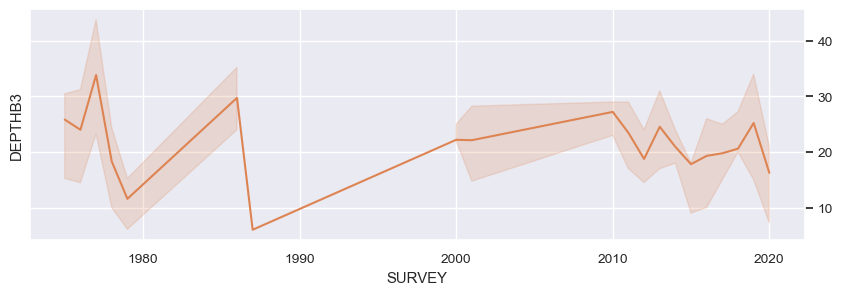





=========================== DEPTHC1 ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: DEPTHC1 

UNIQUE numbers, strings, blanks, null = (43, 0, 0, 1)
number of numeric = 200
number of strings = 0
number of blanks = 0
number of null =  44

--------------------------------------------------
Histogram: DEPTHC1
NUMERICAL


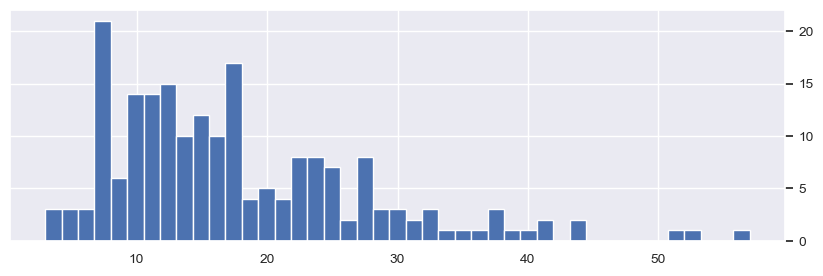


------------------------------------------------
Time Series:DEPTHC1
NUMERICAL


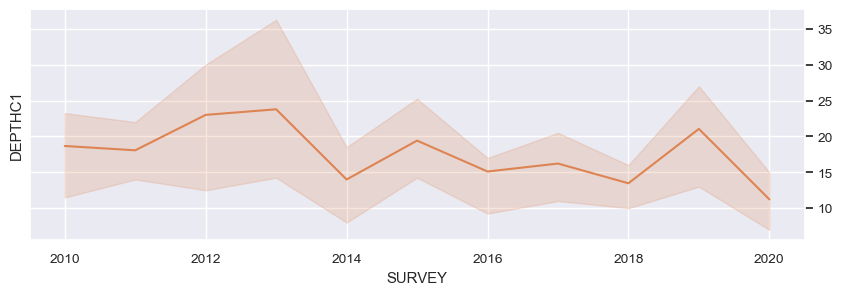


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: DEPTHC1 

UNIQUE numbers, strings, blanks, null = (85, 0, 0, 1)
number of numeric = 370
number of strings = 0
number of blanks = 0
number of null =  247

--------------------------------------------------
Histogram: DEPTHC1
NUMERICAL


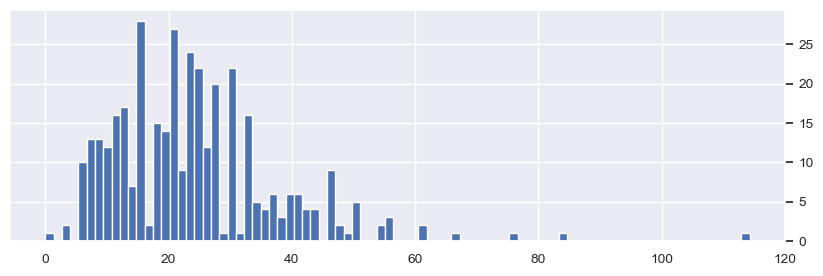


------------------------------------------------
Time Series:DEPTHC1
NUMERICAL


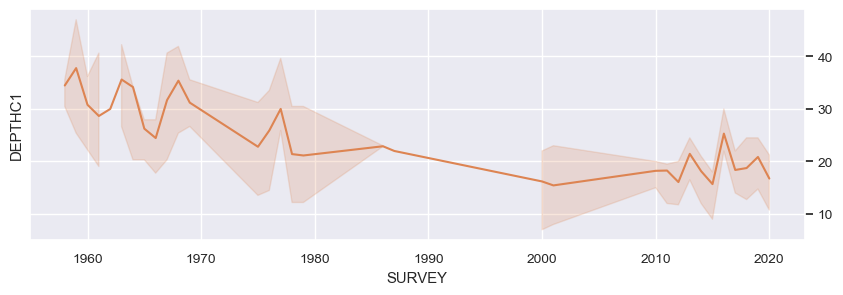





=========================== DEPTHC2 ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: DEPTHC2 

UNIQUE numbers, strings, blanks, null = (40, 0, 0, 1)
number of numeric = 200
number of strings = 0
number of blanks = 0
number of null =  44

--------------------------------------------------
Histogram: DEPTHC2
NUMERICAL


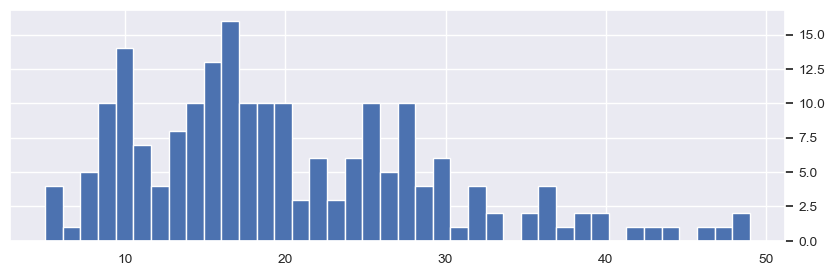


------------------------------------------------
Time Series:DEPTHC2
NUMERICAL


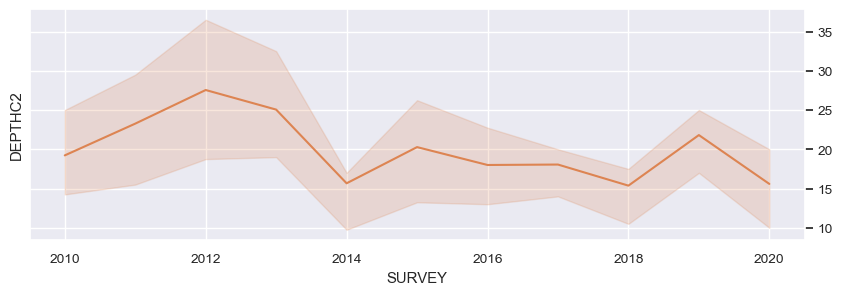


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: DEPTHC2 

UNIQUE numbers, strings, blanks, null = (75, 0, 0, 1)
number of numeric = 253
number of strings = 0
number of blanks = 0
number of null =  364

--------------------------------------------------
Histogram: DEPTHC2
NUMERICAL


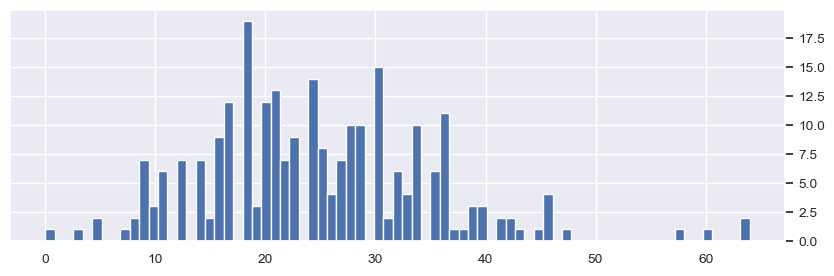


------------------------------------------------
Time Series:DEPTHC2
NUMERICAL


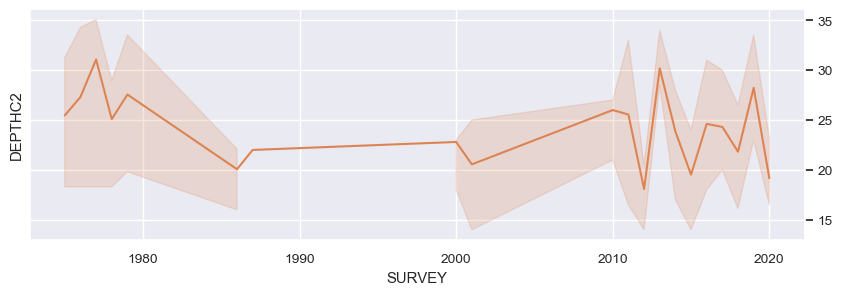





=========================== DEPTHC3 ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: DEPTHC3 

UNIQUE numbers, strings, blanks, null = (40, 0, 0, 1)
number of numeric = 200
number of strings = 0
number of blanks = 0
number of null =  44

--------------------------------------------------
Histogram: DEPTHC3
NUMERICAL


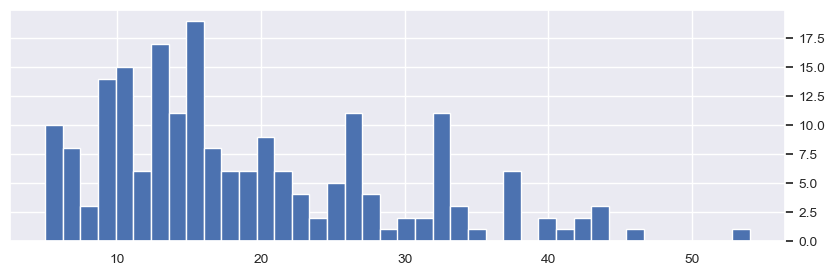


------------------------------------------------
Time Series:DEPTHC3
NUMERICAL


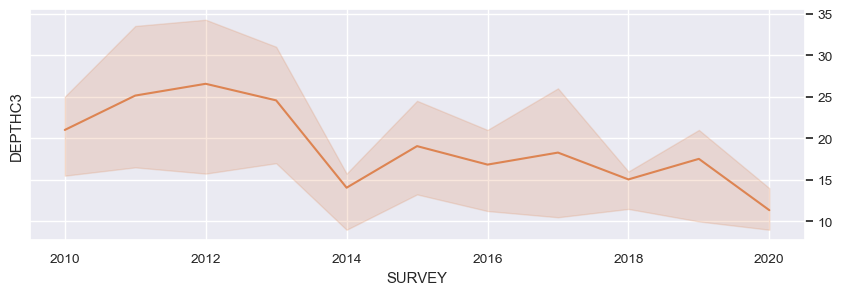


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: DEPTHC3 

UNIQUE numbers, strings, blanks, null = (76, 0, 0, 1)
number of numeric = 253
number of strings = 0
number of blanks = 0
number of null =  364

--------------------------------------------------
Histogram: DEPTHC3
NUMERICAL


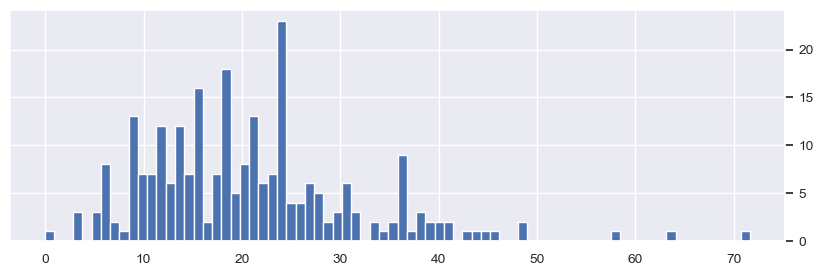


------------------------------------------------
Time Series:DEPTHC3
NUMERICAL


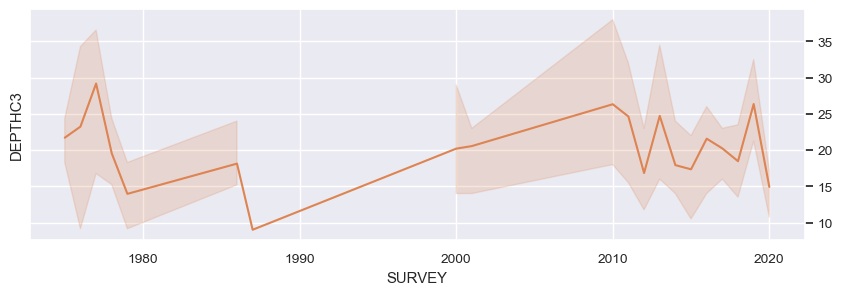





=========================== DEPTH_MAX ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: DEPTH_MAX 

UNIQUE numbers, strings, blanks, null = (40, 0, 0, 1)
number of numeric = 127
number of strings = 0
number of blanks = 0
number of null =  117

--------------------------------------------------
Histogram: DEPTH_MAX
NUMERICAL


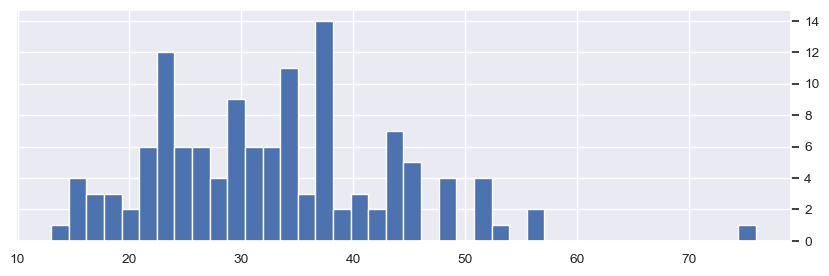


------------------------------------------------
Time Series:DEPTH_MAX
NUMERICAL


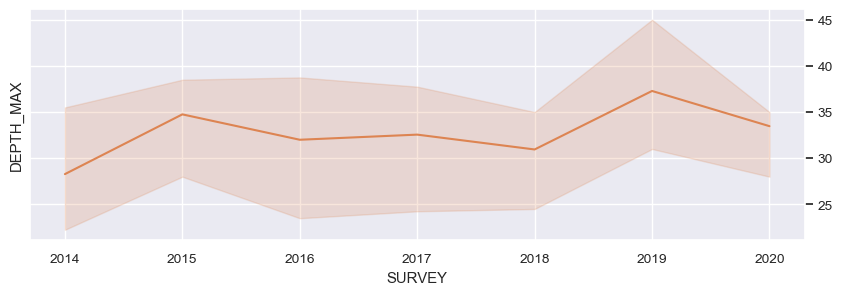


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: DEPTH_MAX 

UNIQUE numbers, strings, blanks, null = (39, 0, 0, 1)
number of numeric = 133
number of strings = 0
number of blanks = 0
number of null =  484

--------------------------------------------------
Histogram: DEPTH_MAX
NUMERICAL


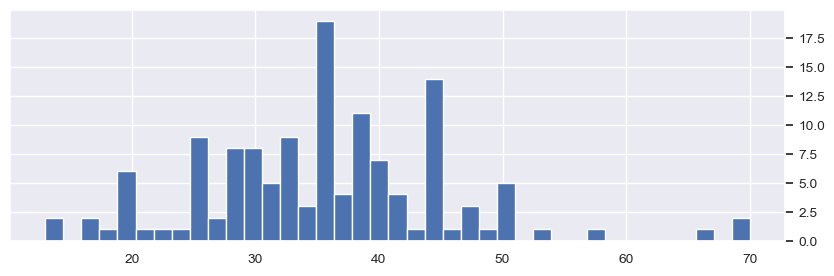


------------------------------------------------
Time Series:DEPTH_MAX
NUMERICAL


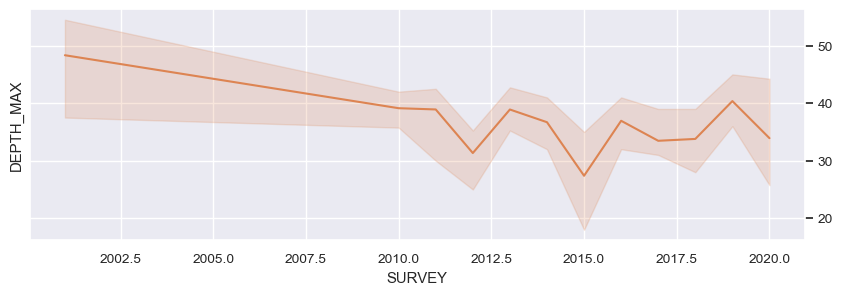





=========================== ELECTROFISHER_CURRENT ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: ELECTROFISHER_CURRENT 

UNIQUE numbers, strings, blanks, null = (14, 0, 0, 1)
number of numeric = 17
number of strings = 0
number of blanks = 0
number of null =  227

--------------------------------------------------
Histogram: ELECTROFISHER_CURRENT
NUMERICAL


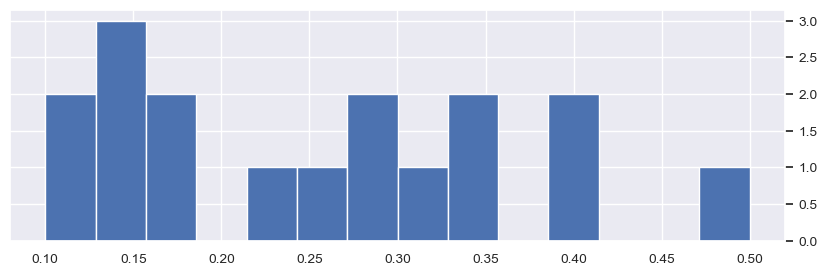


------------------------------------------------
Time Series:ELECTROFISHER_CURRENT
NUMERICAL


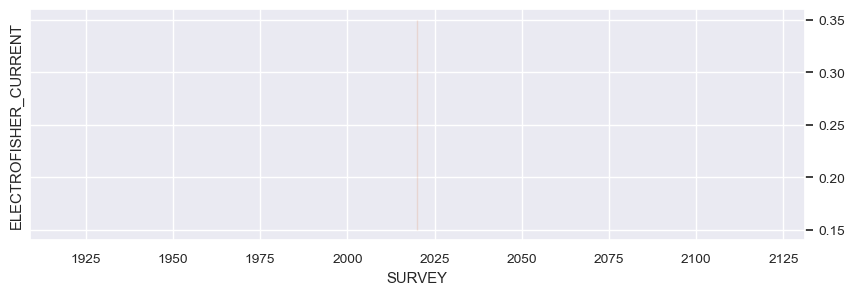


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: ELECTROFISHER_CURRENT 

UNIQUE numbers, strings, blanks, null = (43, 0, 0, 1)
number of numeric = 99
number of strings = 0
number of blanks = 0
number of null =  518

--------------------------------------------------
Histogram: ELECTROFISHER_CURRENT
NUMERICAL


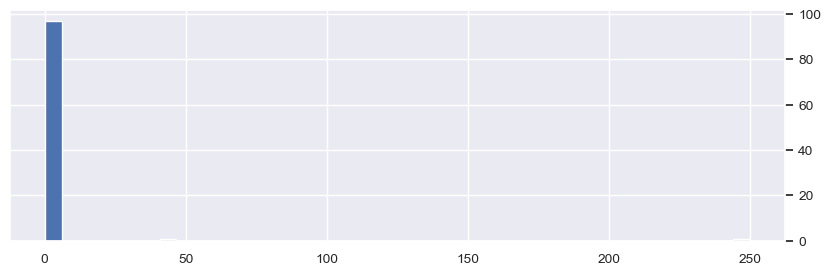


------------------------------------------------
Time Series:ELECTROFISHER_CURRENT
NUMERICAL


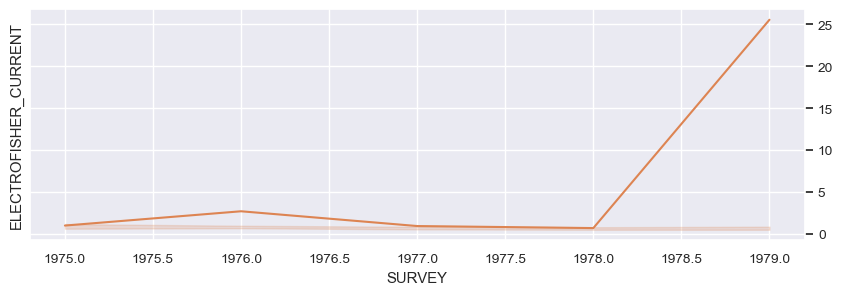





=========================== ELECTROFISHER_FREQUENCY ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: ELECTROFISHER_FREQUENCY 

UNIQUE numbers, strings, blanks, null = (1, 0, 0, 1)
number of numeric = 73
number of strings = 0
number of blanks = 0
number of null =  171

--------------------------------------------------
Histogram: ELECTROFISHER_FREQUENCY
NUMERICAL


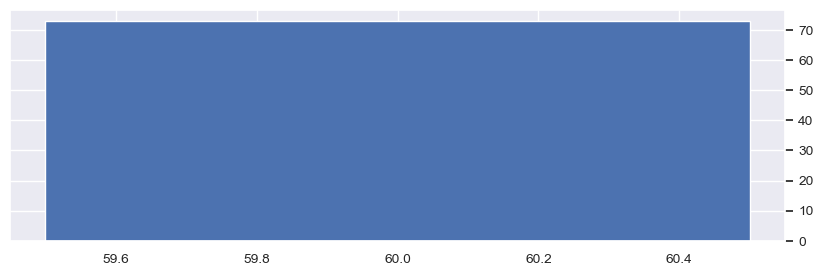


------------------------------------------------
Time Series:ELECTROFISHER_FREQUENCY
NUMERICAL


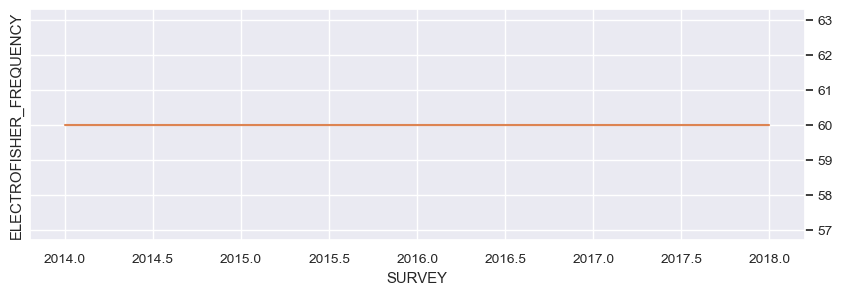


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: ELECTROFISHER_FREQUENCY 

UNIQUE numbers, strings, blanks, null = (20, 14, 0, 1)
number of numeric = 197
number of strings = 137
number of blanks = 0
number of null =  283

--------------------------------------------------
Histogram: ELECTROFISHER_FREQUENCY
CATEGORICAL


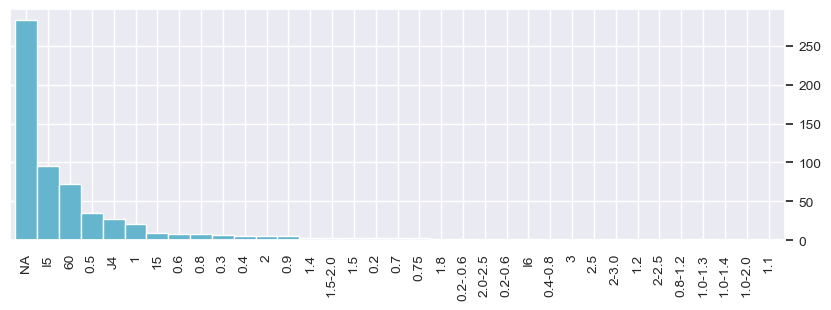


------------------------------------------------
Time Series:ELECTROFISHER_FREQUENCY
CATEGORICAL


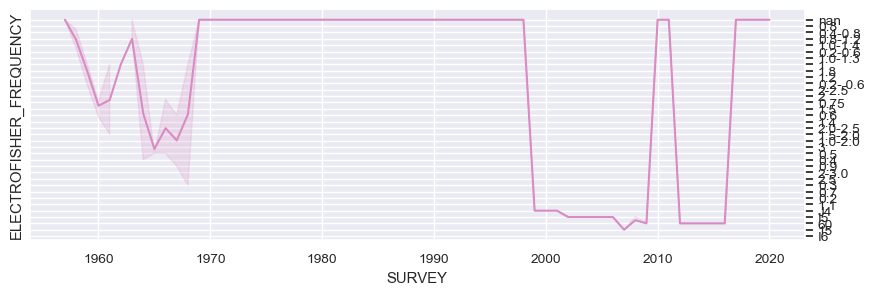





=========================== ELECTROFISHER_OUTPUT ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: ELECTROFISHER_OUTPUT 

UNIQUE numbers, strings, blanks, null = (0, 32, 0, 1)
number of numeric = 0
number of strings = 34
number of blanks = 0
number of null =  210

--------------------------------------------------
Histogram: ELECTROFISHER_OUTPUT
CATEGORICAL


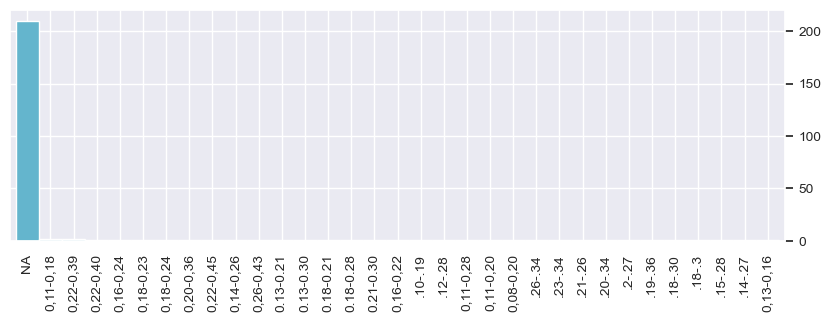


------------------------------------------------
Time Series:ELECTROFISHER_OUTPUT
CATEGORICAL


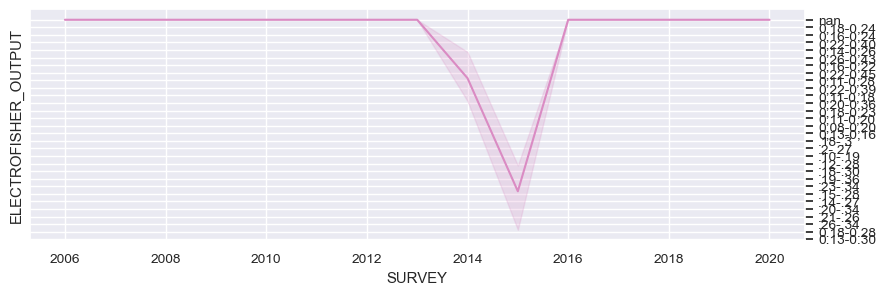


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: ELECTROFISHER_OUTPUT 

UNIQUE numbers, strings, blanks, null = (34, 75, 0, 1)
number of numeric = 172
number of strings = 85
number of blanks = 0
number of null =  360

--------------------------------------------------
Histogram: ELECTROFISHER_OUTPUT
CATEGORICAL


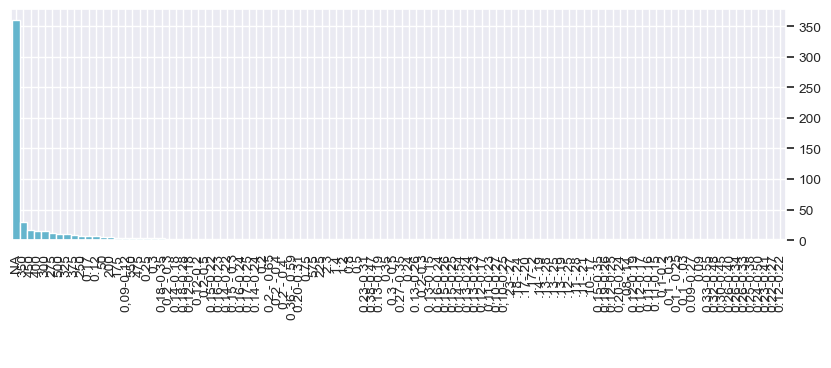


------------------------------------------------
Time Series:ELECTROFISHER_OUTPUT
CATEGORICAL


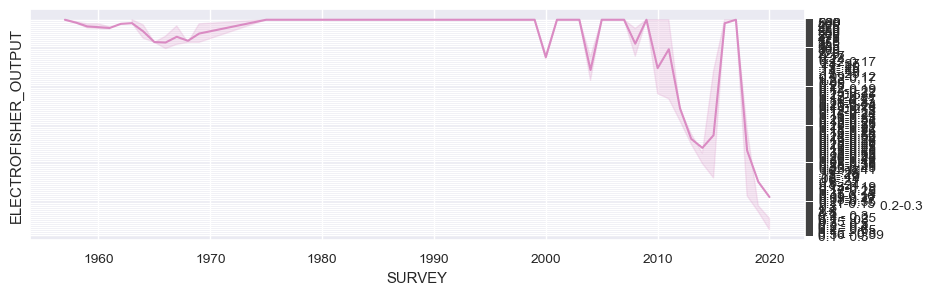





=========================== ELECTROFISHER_TYPE ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: ELECTROFISHER_TYPE 

UNIQUE numbers, strings, blanks, null = (0, 1, 0, 1)
number of numeric = 0
number of strings = 112
number of blanks = 0
number of null =  132

--------------------------------------------------
Histogram: ELECTROFISHER_TYPE
CATEGORICAL


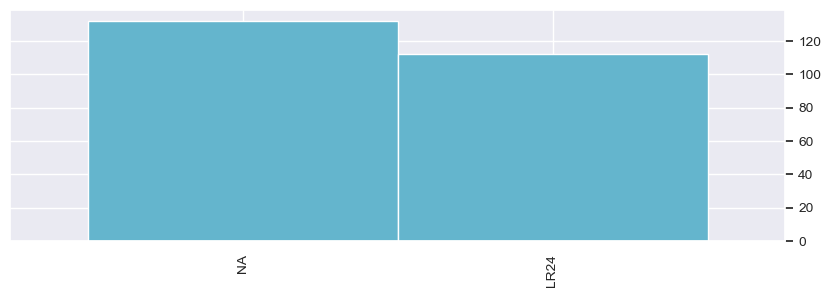


------------------------------------------------
Time Series:ELECTROFISHER_TYPE
CATEGORICAL


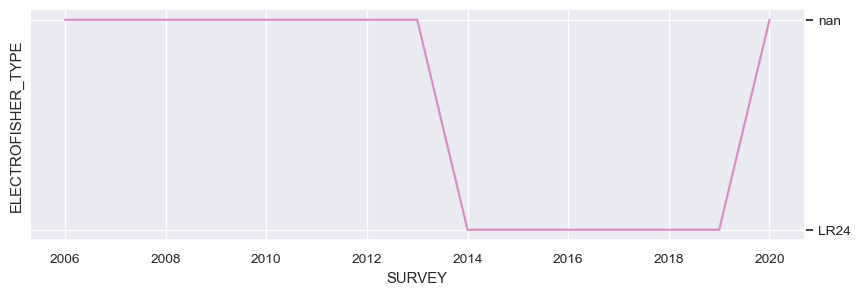


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: ELECTROFISHER_TYPE 

UNIQUE numbers, strings, blanks, null = (0, 2, 0, 1)
number of numeric = 0
number of strings = 109
number of blanks = 0
number of null =  508

--------------------------------------------------
Histogram: ELECTROFISHER_TYPE
CATEGORICAL


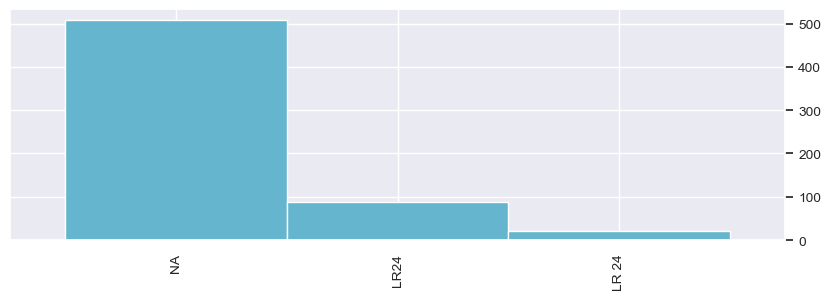


------------------------------------------------
Time Series:ELECTROFISHER_TYPE
CATEGORICAL


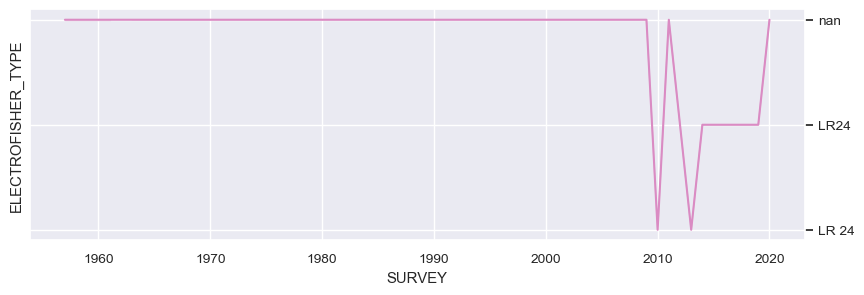





=========================== ELECTROFISHER_VOLTAGE ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: ELECTROFISHER_VOLTAGE 

UNIQUE numbers, strings, blanks, null = (16, 0, 0, 1)
number of numeric = 128
number of strings = 0
number of blanks = 0
number of null =  116

--------------------------------------------------
Histogram: ELECTROFISHER_VOLTAGE
NUMERICAL


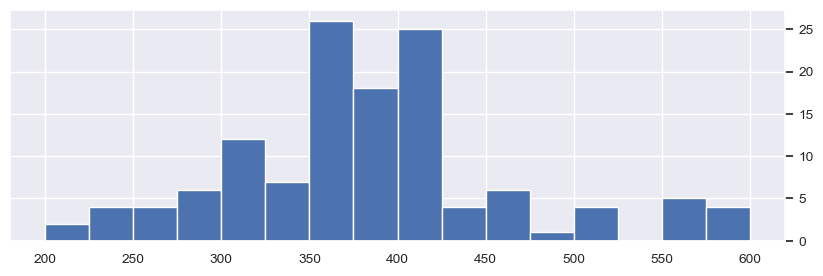


------------------------------------------------
Time Series:ELECTROFISHER_VOLTAGE
NUMERICAL


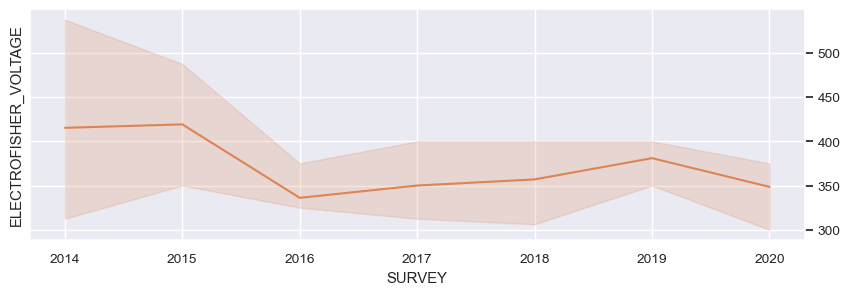


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: ELECTROFISHER_VOLTAGE 

UNIQUE numbers, strings, blanks, null = (51, 0, 0, 1)
number of numeric = 377
number of strings = 0
number of blanks = 0
number of null =  240

--------------------------------------------------
Histogram: ELECTROFISHER_VOLTAGE
NUMERICAL


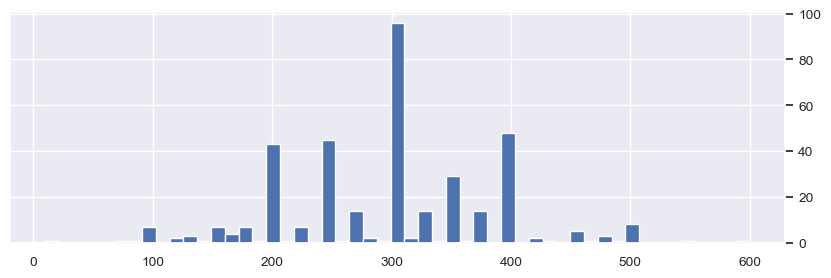


------------------------------------------------
Time Series:ELECTROFISHER_VOLTAGE
NUMERICAL


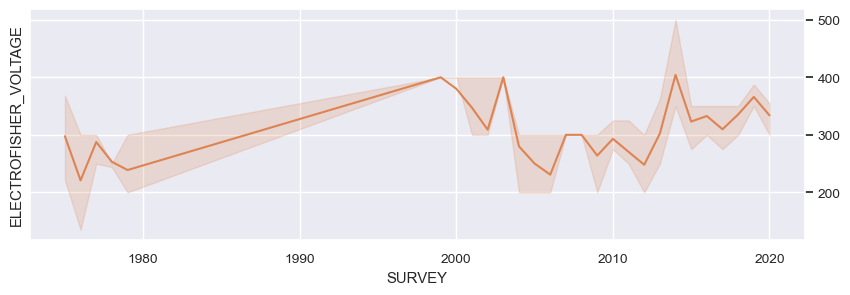





=========================== FULL_WETTED_WIDTH ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: FULL_WETTED_WIDTH 

UNIQUE numbers, strings, blanks, null = (91, 0, 0, 1)
number of numeric = 93
number of strings = 0
number of blanks = 0
number of null =  151

--------------------------------------------------
Histogram: FULL_WETTED_WIDTH
NUMERICAL


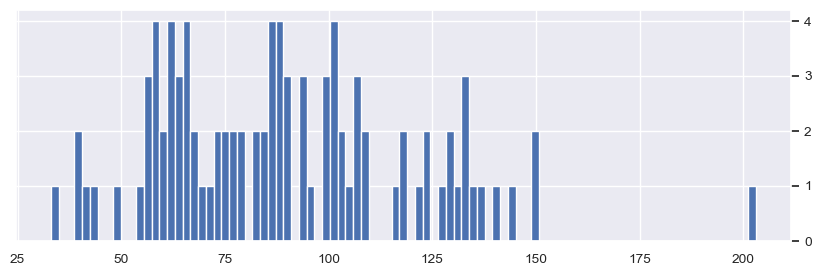


------------------------------------------------
Time Series:FULL_WETTED_WIDTH
NUMERICAL


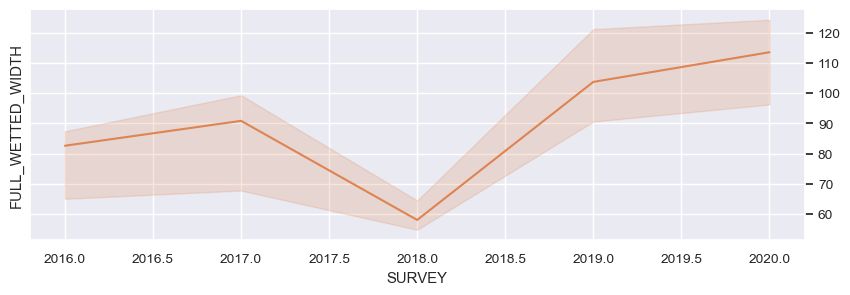


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: FULL_WETTED_WIDTH 

UNIQUE numbers, strings, blanks, null = (485, 0, 0, 1)
number of numeric = 515
number of strings = 0
number of blanks = 0
number of null =  102

--------------------------------------------------
Histogram: FULL_WETTED_WIDTH
NUMERICAL


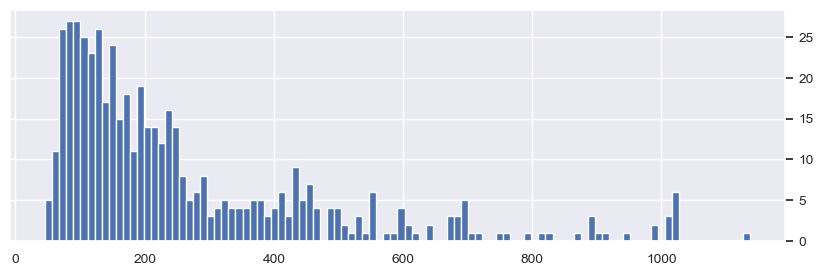


------------------------------------------------
Time Series:FULL_WETTED_WIDTH
NUMERICAL


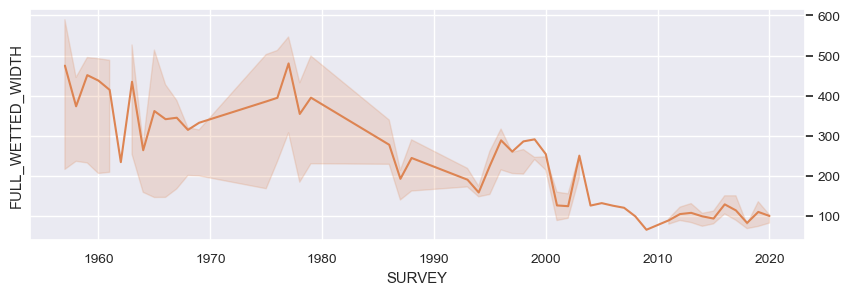





=========================== ID ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: ID 

UNIQUE numbers, strings, blanks, null = (244, 0, 0, 0)
number of numeric = 244
number of strings = 0
number of blanks = 0
number of null =  0

--------------------------------------------------
Histogram: ID
NUMERICAL


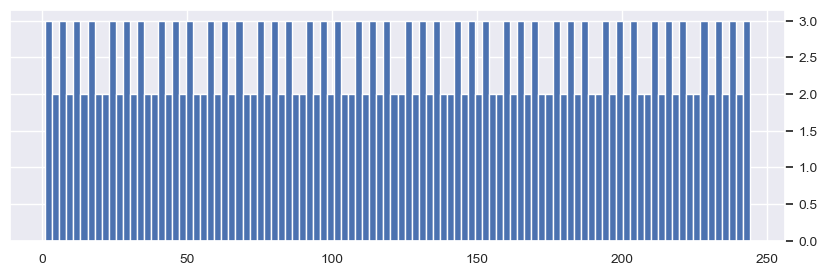


------------------------------------------------
Time Series:ID
NUMERICAL


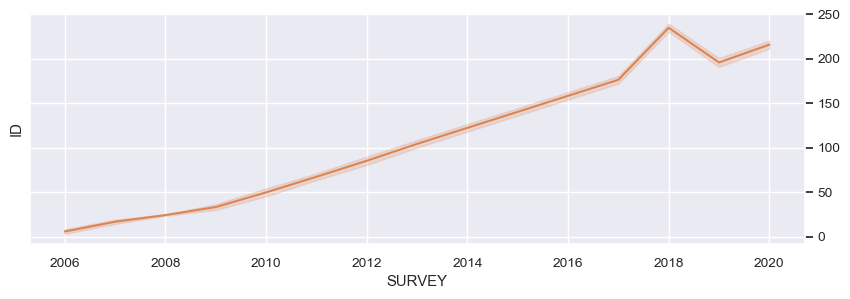


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: ID 

UNIQUE numbers, strings, blanks, null = (617, 0, 0, 0)
number of numeric = 617
number of strings = 0
number of blanks = 0
number of null =  0

--------------------------------------------------
Histogram: ID
NUMERICAL


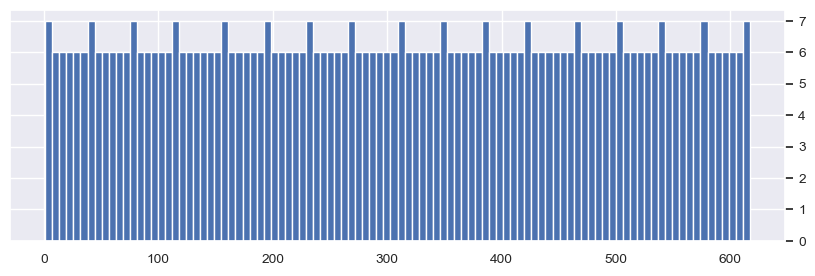


------------------------------------------------
Time Series:ID
NUMERICAL


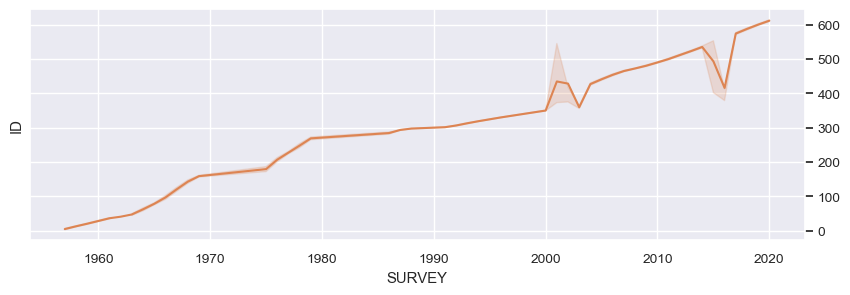





=========================== LENGTH_LEFT_BANK ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: LENGTH_LEFT_BANK 

UNIQUE numbers, strings, blanks, null = (120, 0, 0, 1)
number of numeric = 238
number of strings = 0
number of blanks = 0
number of null =  6

--------------------------------------------------
Histogram: LENGTH_LEFT_BANK
NUMERICAL


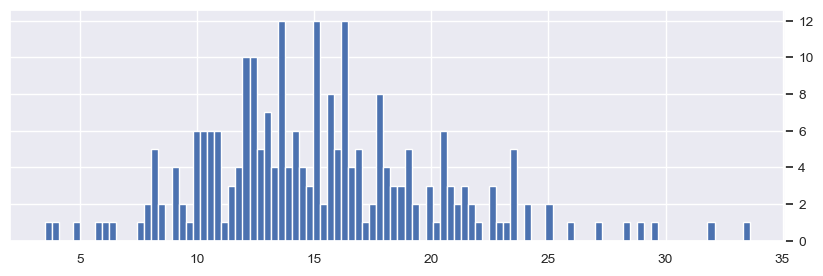


------------------------------------------------
Time Series:LENGTH_LEFT_BANK
NUMERICAL


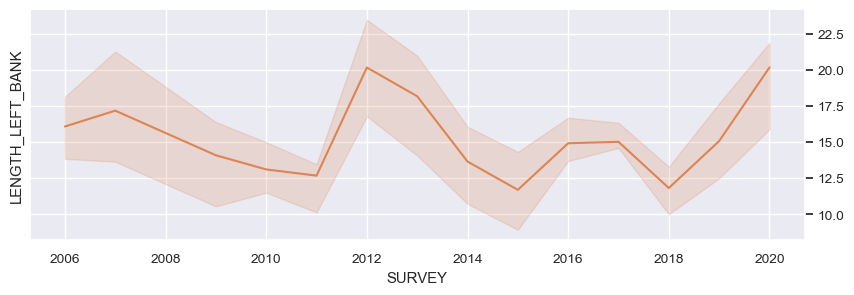


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: LENGTH_LEFT_BANK 

UNIQUE numbers, strings, blanks, null = (285, 0, 0, 1)
number of numeric = 579
number of strings = 0
number of blanks = 0
number of null =  38

--------------------------------------------------
Histogram: LENGTH_LEFT_BANK
NUMERICAL


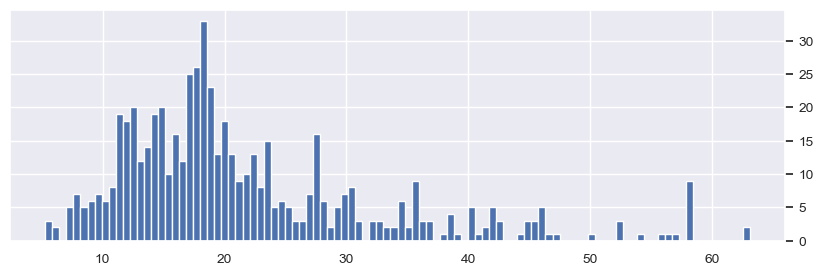


------------------------------------------------
Time Series:LENGTH_LEFT_BANK
NUMERICAL


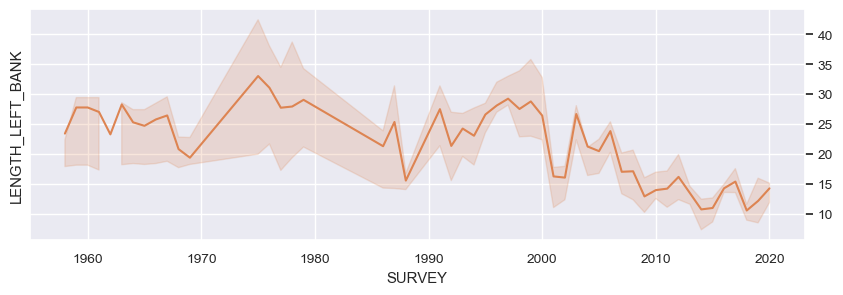





=========================== LENGTH_RIGHT_BANK ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: LENGTH_RIGHT_BANK 

UNIQUE numbers, strings, blanks, null = (130, 0, 0, 1)
number of numeric = 238
number of strings = 0
number of blanks = 0
number of null =  6

--------------------------------------------------
Histogram: LENGTH_RIGHT_BANK
NUMERICAL


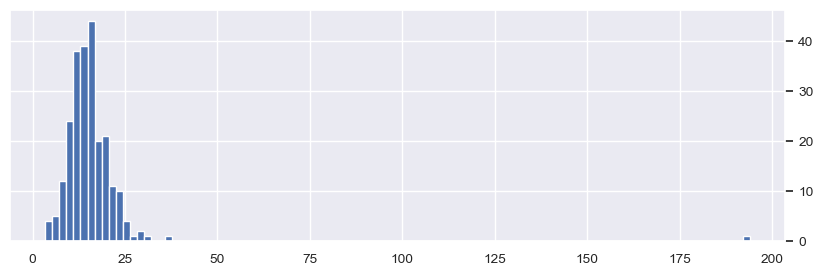


------------------------------------------------
Time Series:LENGTH_RIGHT_BANK
NUMERICAL


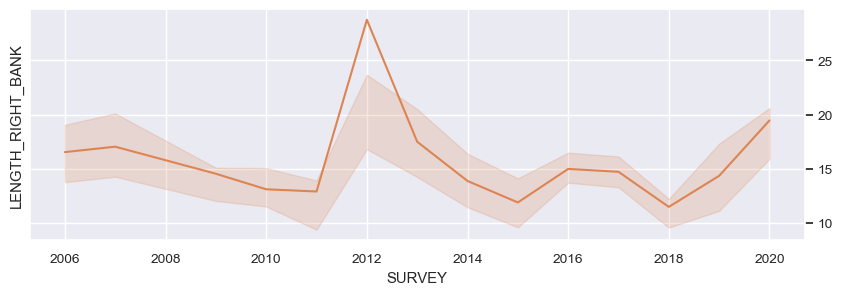


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: LENGTH_RIGHT_BANK 

UNIQUE numbers, strings, blanks, null = (281, 0, 0, 1)
number of numeric = 579
number of strings = 0
number of blanks = 0
number of null =  38

--------------------------------------------------
Histogram: LENGTH_RIGHT_BANK
NUMERICAL


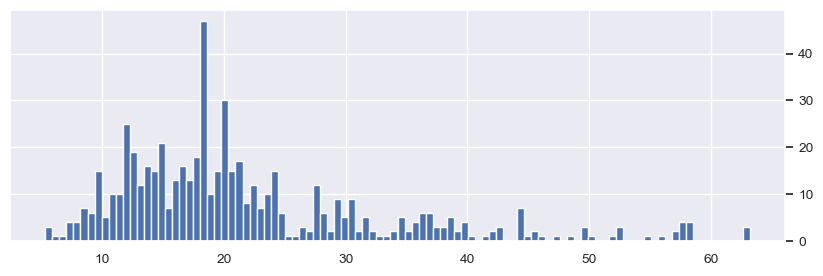


------------------------------------------------
Time Series:LENGTH_RIGHT_BANK
NUMERICAL


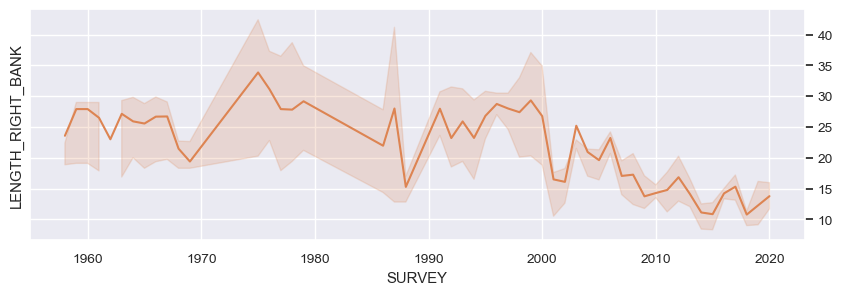





=========================== L_BK_OVERHANGING_VEG ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: L_BK_OVERHANGING_VEG 

UNIQUE numbers, strings, blanks, null = (16, 0, 0, 1)
number of numeric = 197
number of strings = 0
number of blanks = 0
number of null =  47

--------------------------------------------------
Histogram: L_BK_OVERHANGING_VEG
NUMERICAL


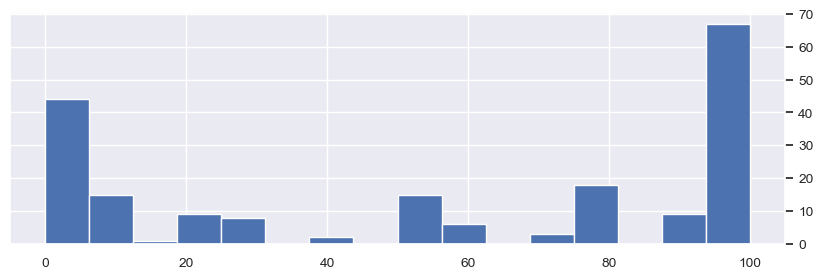


------------------------------------------------
Time Series:L_BK_OVERHANGING_VEG
NUMERICAL


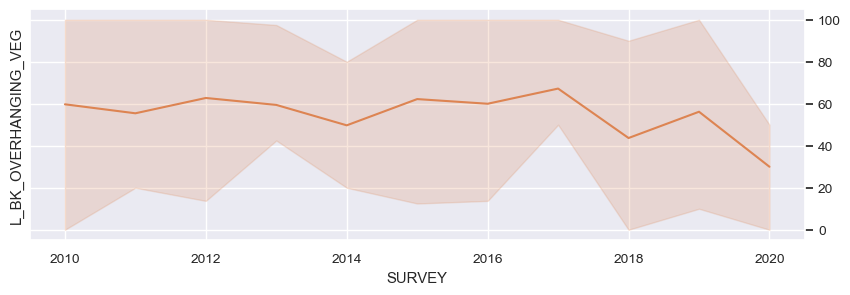


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: L_BK_OVERHANGING_VEG 

UNIQUE numbers, strings, blanks, null = (16, 0, 0, 1)
number of numeric = 129
number of strings = 0
number of blanks = 0
number of null =  488

--------------------------------------------------
Histogram: L_BK_OVERHANGING_VEG
NUMERICAL


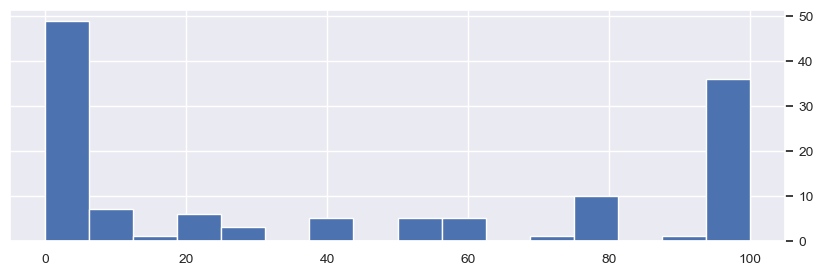


------------------------------------------------
Time Series:L_BK_OVERHANGING_VEG
NUMERICAL


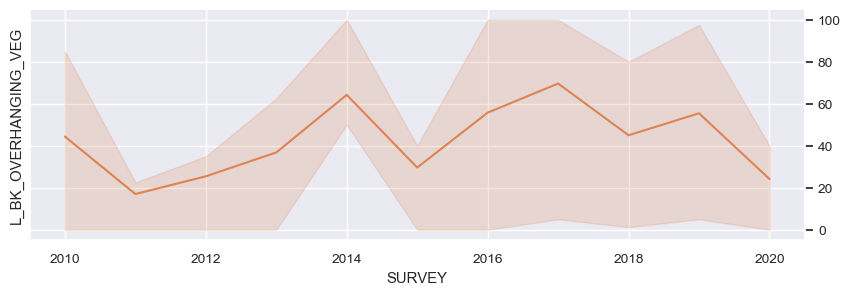





=========================== MAX_OVERHANG_L_BK ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: MAX_OVERHANG_L_BK 

UNIQUE numbers, strings, blanks, null = (22, 0, 0, 1)
number of numeric = 198
number of strings = 0
number of blanks = 0
number of null =  46

--------------------------------------------------
Histogram: MAX_OVERHANG_L_BK
NUMERICAL


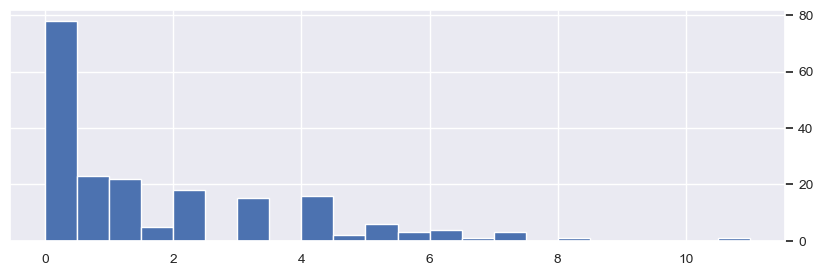


------------------------------------------------
Time Series:MAX_OVERHANG_L_BK
NUMERICAL


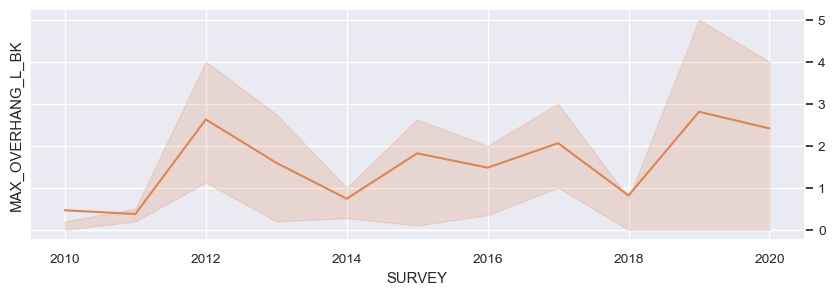


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: MAX_OVERHANG_L_BK 

UNIQUE numbers, strings, blanks, null = (19, 0, 0, 1)
number of numeric = 129
number of strings = 0
number of blanks = 0
number of null =  488

--------------------------------------------------
Histogram: MAX_OVERHANG_L_BK
NUMERICAL


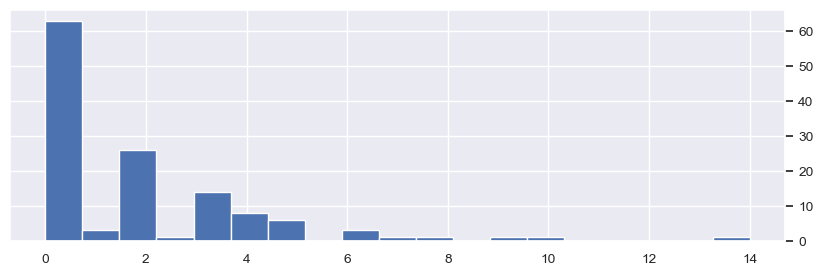


------------------------------------------------
Time Series:MAX_OVERHANG_L_BK
NUMERICAL


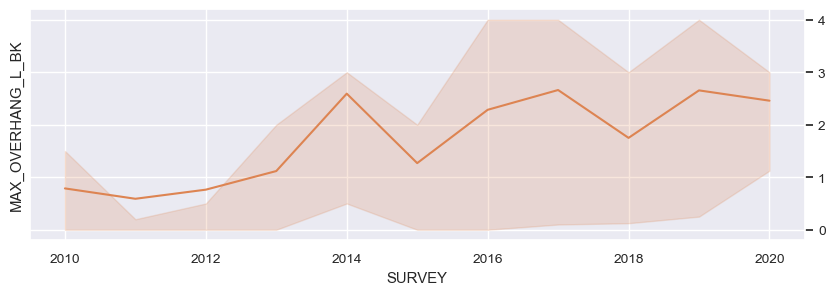





=========================== MAX_OVERHANG_R_BK ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: MAX_OVERHANG_R_BK 

UNIQUE numbers, strings, blanks, null = (22, 0, 0, 1)
number of numeric = 196
number of strings = 0
number of blanks = 0
number of null =  48

--------------------------------------------------
Histogram: MAX_OVERHANG_R_BK
NUMERICAL


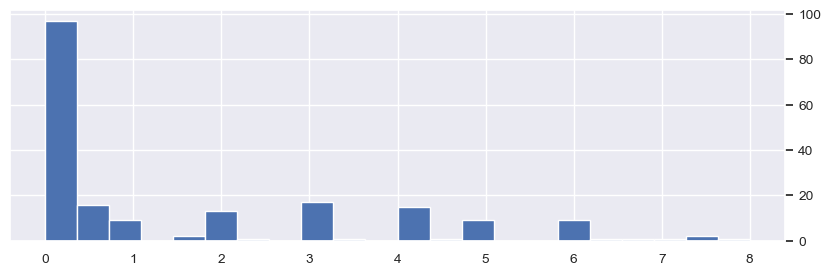


------------------------------------------------
Time Series:MAX_OVERHANG_R_BK
NUMERICAL


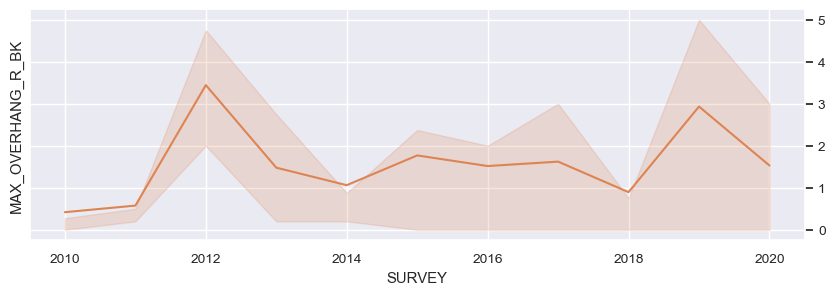


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: MAX_OVERHANG_R_BK 

UNIQUE numbers, strings, blanks, null = (16, 0, 0, 1)
number of numeric = 131
number of strings = 0
number of blanks = 0
number of null =  486

--------------------------------------------------
Histogram: MAX_OVERHANG_R_BK
NUMERICAL


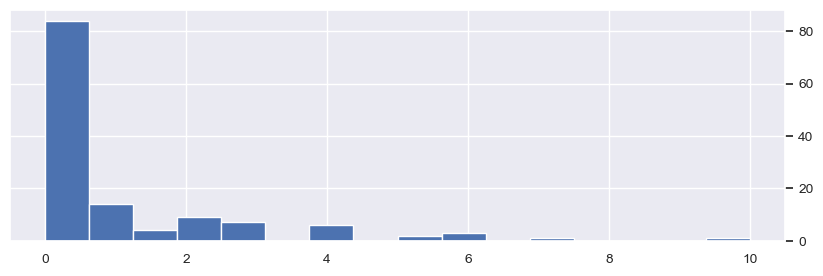


------------------------------------------------
Time Series:MAX_OVERHANG_R_BK
NUMERICAL


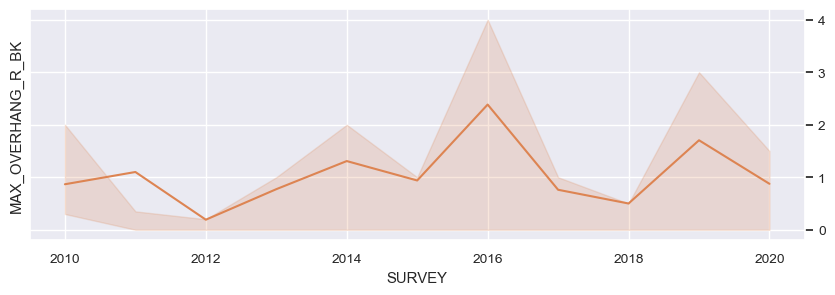





=========================== RIVER_NAME ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: RIVER_NAME 

UNIQUE numbers, strings, blanks, null = (0, 15, 0, 0)
number of numeric = 0
number of strings = 244
number of blanks = 0
number of null =  0

--------------------------------------------------
Histogram: RIVER_NAME
CATEGORICAL


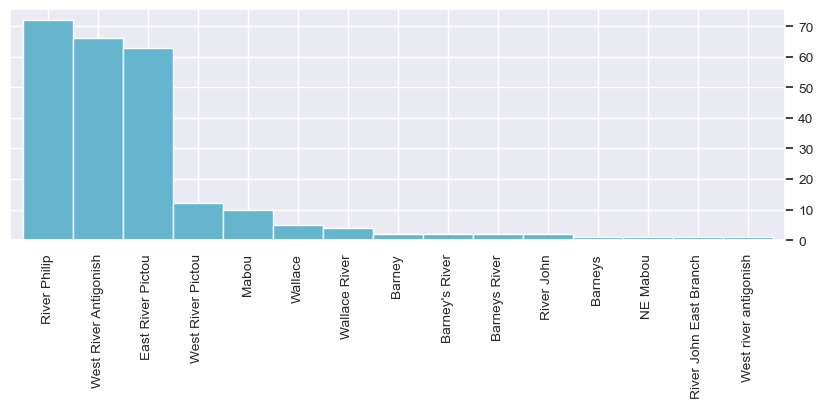


------------------------------------------------
Time Series:RIVER_NAME
CATEGORICAL


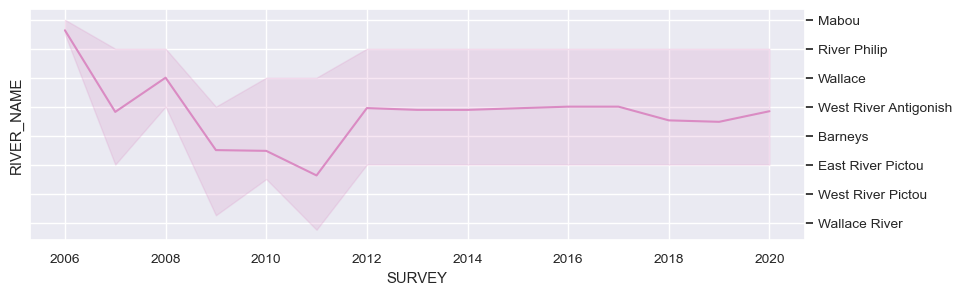


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
COLUMN MISSING OR NULL: RIVER_NAME




=========================== R_BK_OVERHANGING_VEG ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: R_BK_OVERHANGING_VEG 

UNIQUE numbers, strings, blanks, null = (16, 0, 0, 1)
number of numeric = 198
number of strings = 0
number of blanks = 0
number of null =  46

--------------------------------------------------
Histogram: R_BK_OVERHANGING_VEG
NUMERICAL


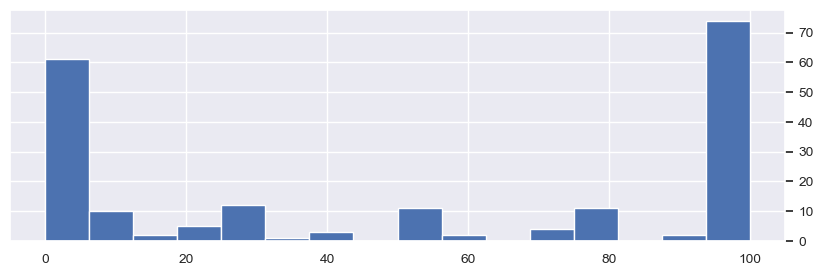


------------------------------------------------
Time Series:R_BK_OVERHANGING_VEG
NUMERICAL


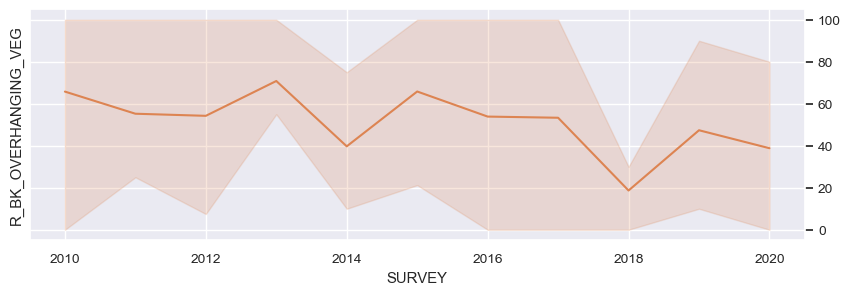


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: R_BK_OVERHANGING_VEG 

UNIQUE numbers, strings, blanks, null = (15, 0, 0, 1)
number of numeric = 131
number of strings = 0
number of blanks = 0
number of null =  486

--------------------------------------------------
Histogram: R_BK_OVERHANGING_VEG
NUMERICAL


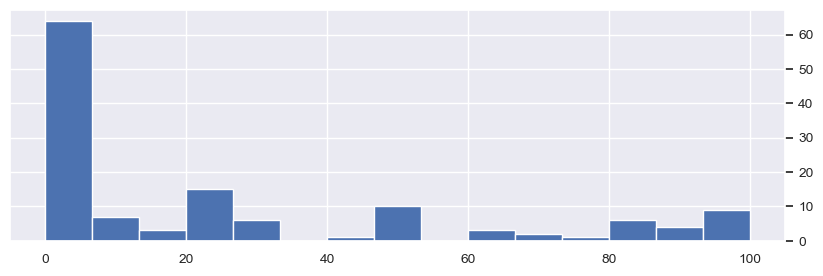


------------------------------------------------
Time Series:R_BK_OVERHANGING_VEG
NUMERICAL


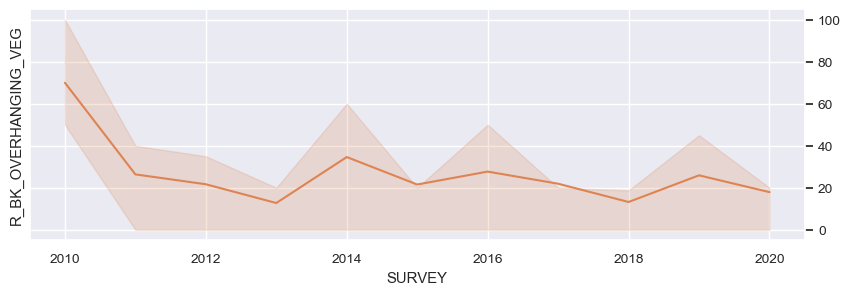





=========================== SITE ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: SITE 

UNIQUE numbers, strings, blanks, null = (15, 17, 0, 1)
number of numeric = 208
number of strings = 34
number of blanks = 0
number of null =  2

--------------------------------------------------
Histogram: SITE
CATEGORICAL


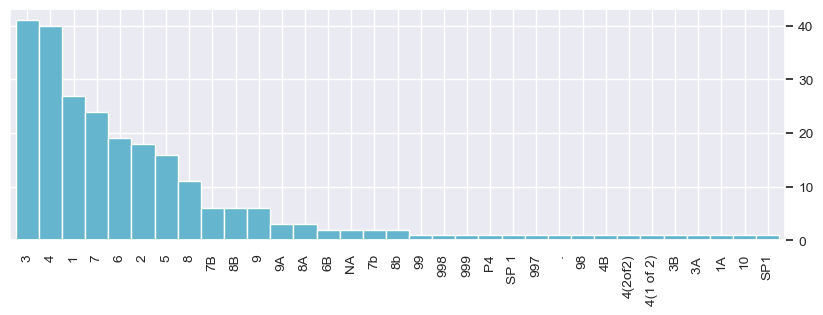


------------------------------------------------
Time Series:SITE
CATEGORICAL


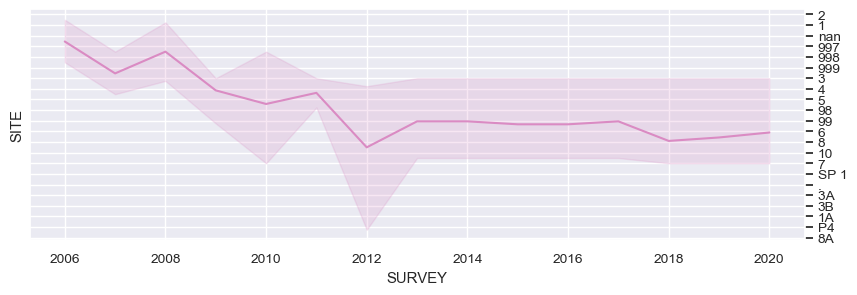


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: SITE 

UNIQUE numbers, strings, blanks, null = (49, 56, 0, 0)
number of numeric = 488
number of strings = 129
number of blanks = 0
number of null =  0

--------------------------------------------------
Histogram: SITE
CATEGORICAL


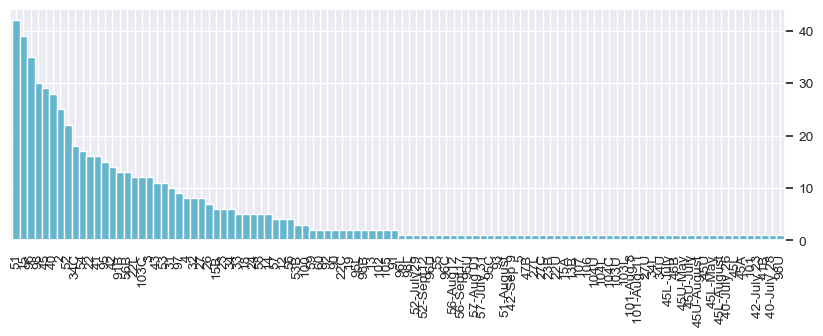


------------------------------------------------
Time Series:SITE
CATEGORICAL


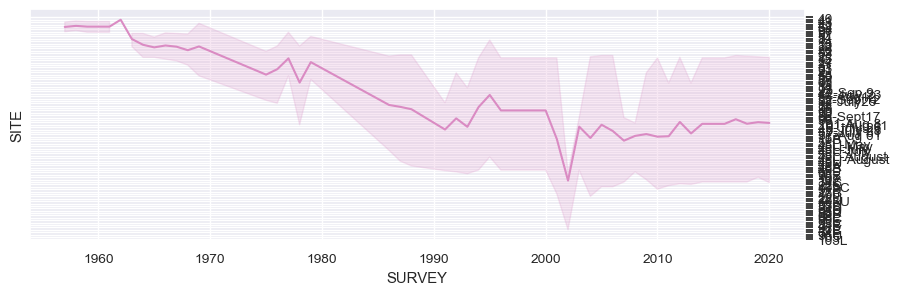





=========================== SUB_TYPE_BEDROCK ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: SUB_TYPE_BEDROCK 

UNIQUE numbers, strings, blanks, null = (12, 1, 0, 1)
number of numeric = 240
number of strings = 1
number of blanks = 0
number of null =  3

--------------------------------------------------
Histogram: SUB_TYPE_BEDROCK
CATEGORICAL


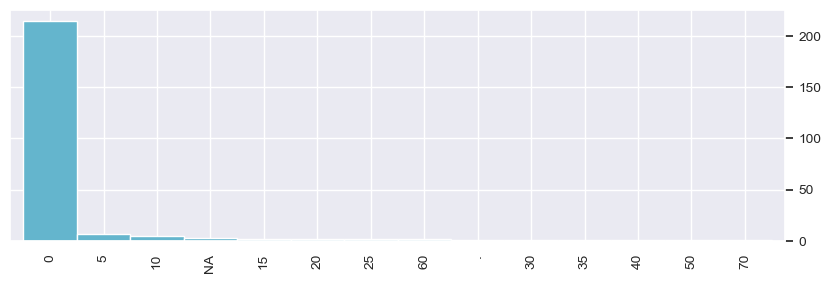


------------------------------------------------
Time Series:SUB_TYPE_BEDROCK
CATEGORICAL


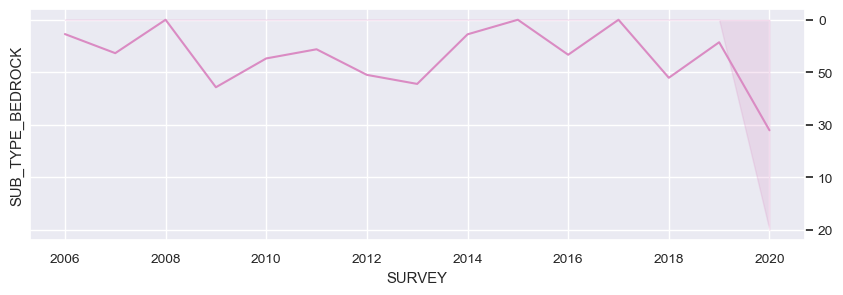


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: SUB_TYPE_BEDROCK 

UNIQUE numbers, strings, blanks, null = (5, 0, 0, 1)
number of numeric = 258
number of strings = 0
number of blanks = 0
number of null =  359

--------------------------------------------------
Histogram: SUB_TYPE_BEDROCK
NUMERICAL


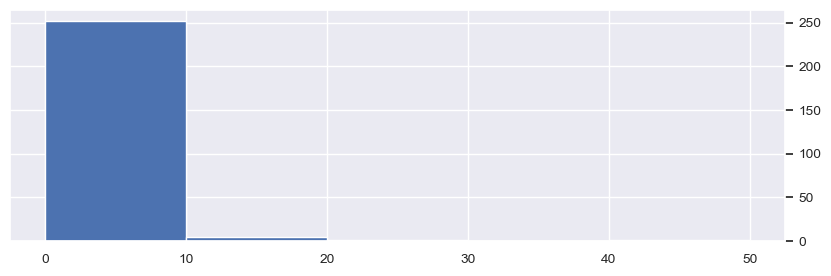


------------------------------------------------
Time Series:SUB_TYPE_BEDROCK
NUMERICAL


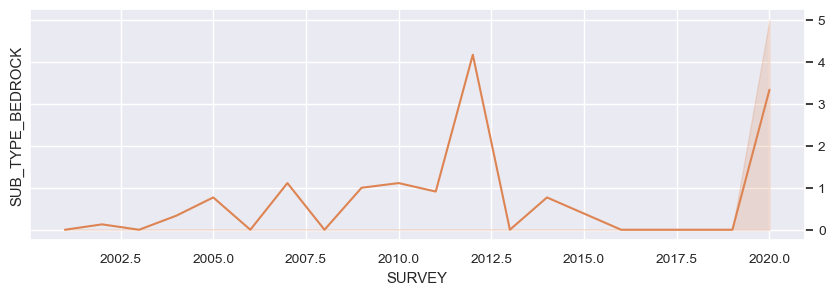





=========================== SUB_TYPE_BOULDER ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: SUB_TYPE_BOULDER 

UNIQUE numbers, strings, blanks, null = (9, 1, 0, 1)
number of numeric = 240
number of strings = 1
number of blanks = 0
number of null =  3

--------------------------------------------------
Histogram: SUB_TYPE_BOULDER
CATEGORICAL


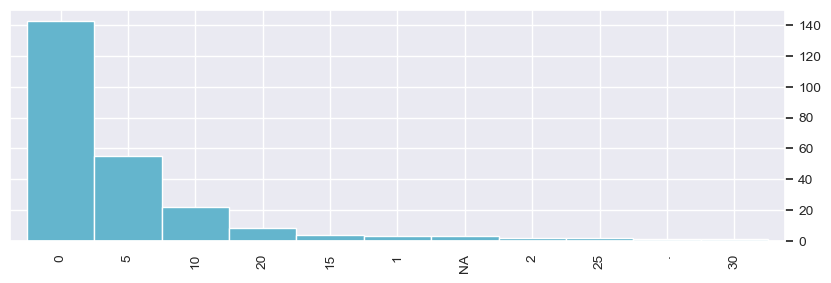


------------------------------------------------
Time Series:SUB_TYPE_BOULDER
CATEGORICAL


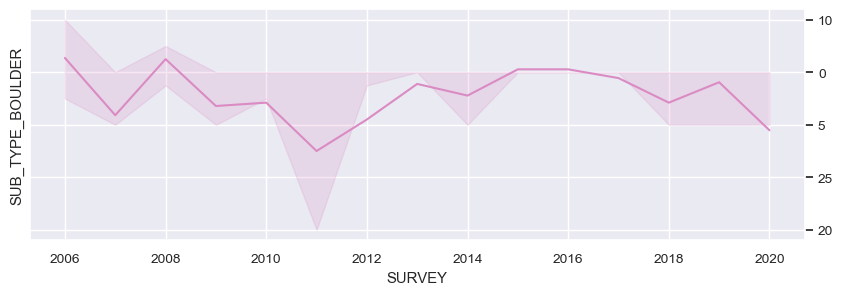


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: SUB_TYPE_BOULDER 

UNIQUE numbers, strings, blanks, null = (10, 0, 0, 1)
number of numeric = 257
number of strings = 0
number of blanks = 0
number of null =  360

--------------------------------------------------
Histogram: SUB_TYPE_BOULDER
NUMERICAL


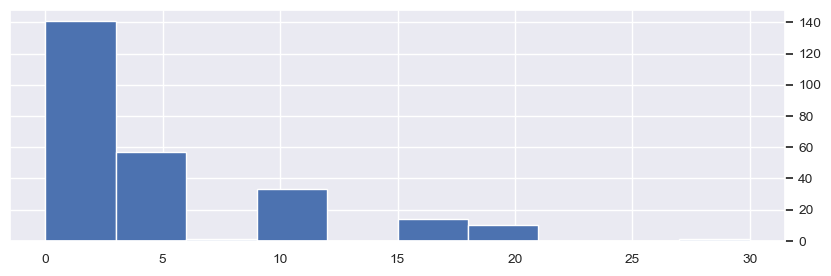


------------------------------------------------
Time Series:SUB_TYPE_BOULDER
NUMERICAL


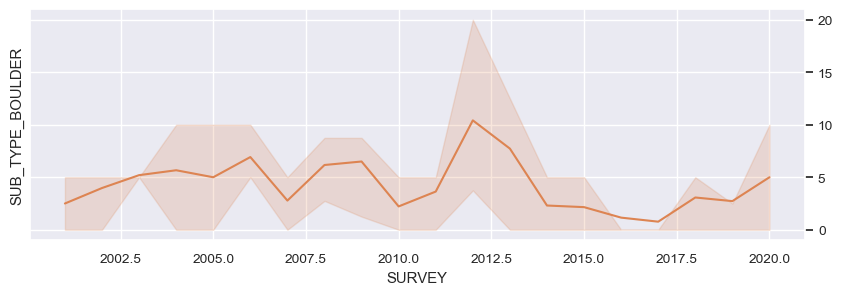





=========================== SUB_TYPE_COBBLE ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: SUB_TYPE_COBBLE 

UNIQUE numbers, strings, blanks, null = (18, 1, 0, 1)
number of numeric = 239
number of strings = 1
number of blanks = 0
number of null =  4

--------------------------------------------------
Histogram: SUB_TYPE_COBBLE
CATEGORICAL


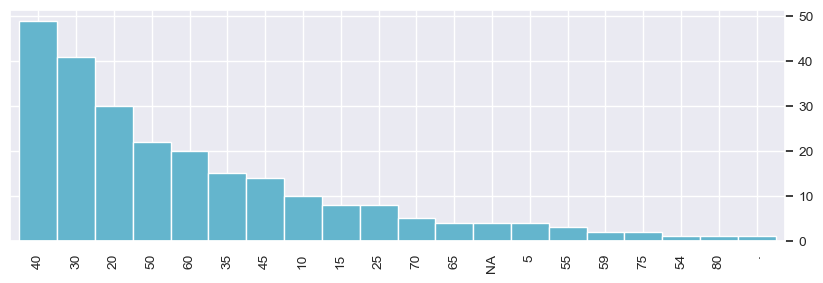


------------------------------------------------
Time Series:SUB_TYPE_COBBLE
CATEGORICAL


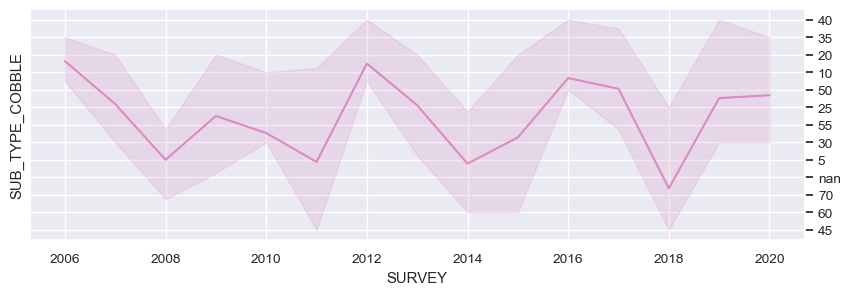


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: SUB_TYPE_COBBLE 

UNIQUE numbers, strings, blanks, null = (22, 0, 0, 1)
number of numeric = 258
number of strings = 0
number of blanks = 0
number of null =  359

--------------------------------------------------
Histogram: SUB_TYPE_COBBLE
NUMERICAL


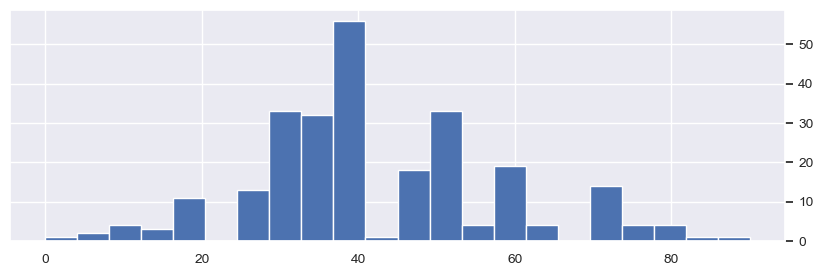


------------------------------------------------
Time Series:SUB_TYPE_COBBLE
NUMERICAL


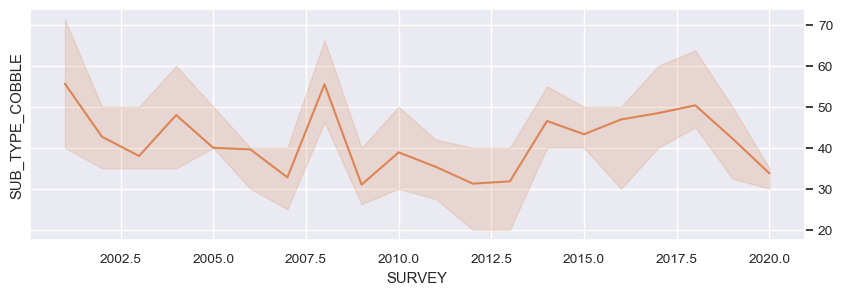





=========================== SUB_TYPE_FINES ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: SUB_TYPE_FINES 

UNIQUE numbers, strings, blanks, null = (4, 3, 0, 1)
number of numeric = 237
number of strings = 4
number of blanks = 0
number of null =  3

--------------------------------------------------
Histogram: SUB_TYPE_FINES
CATEGORICAL


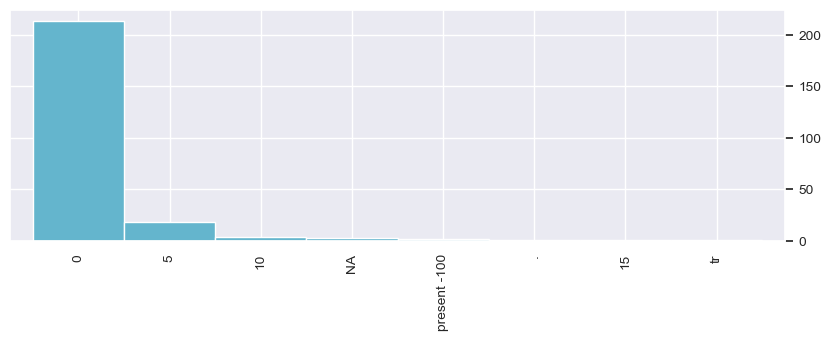


------------------------------------------------
Time Series:SUB_TYPE_FINES
CATEGORICAL


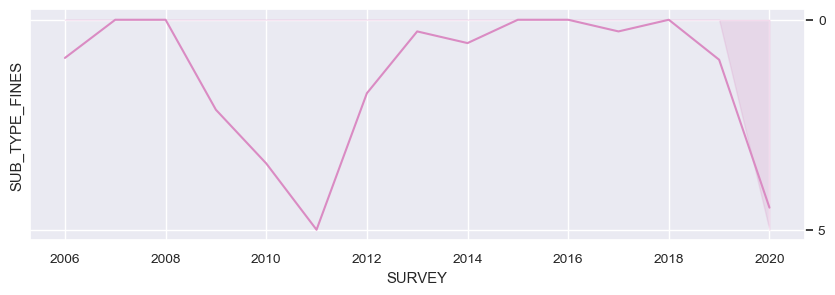


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: SUB_TYPE_FINES 

UNIQUE numbers, strings, blanks, null = (6, 0, 0, 1)
number of numeric = 258
number of strings = 0
number of blanks = 0
number of null =  359

--------------------------------------------------
Histogram: SUB_TYPE_FINES
NUMERICAL


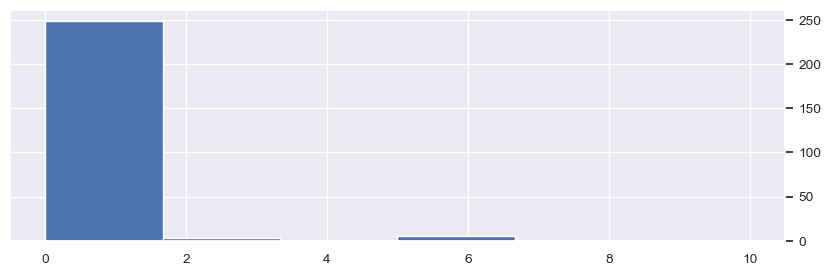


------------------------------------------------
Time Series:SUB_TYPE_FINES
NUMERICAL


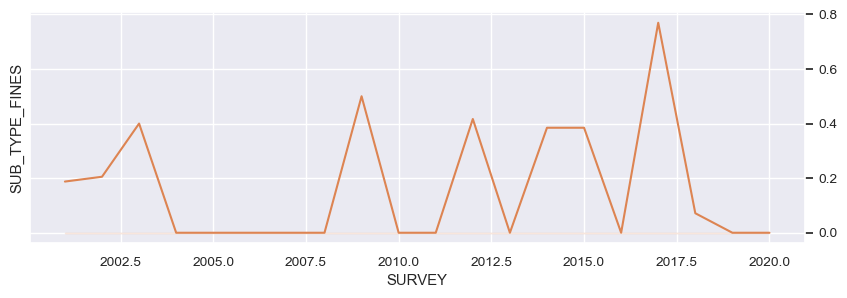





=========================== SUB_TYPE_GRAVEL ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: SUB_TYPE_GRAVEL 

UNIQUE numbers, strings, blanks, null = (11, 1, 0, 1)
number of numeric = 240
number of strings = 1
number of blanks = 0
number of null =  3

--------------------------------------------------
Histogram: SUB_TYPE_GRAVEL
CATEGORICAL


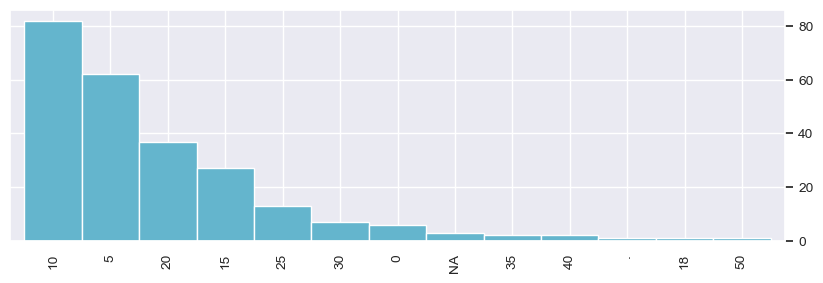


------------------------------------------------
Time Series:SUB_TYPE_GRAVEL
CATEGORICAL


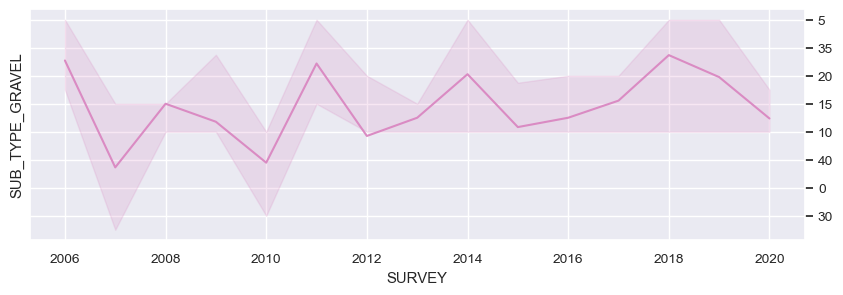


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: SUB_TYPE_GRAVEL 

UNIQUE numbers, strings, blanks, null = (16, 0, 0, 1)
number of numeric = 258
number of strings = 0
number of blanks = 0
number of null =  359

--------------------------------------------------
Histogram: SUB_TYPE_GRAVEL
NUMERICAL


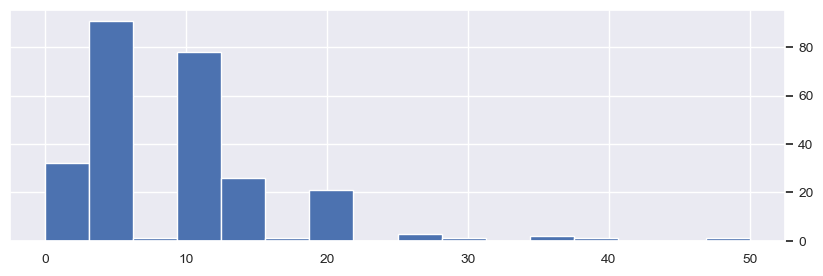


------------------------------------------------
Time Series:SUB_TYPE_GRAVEL
NUMERICAL


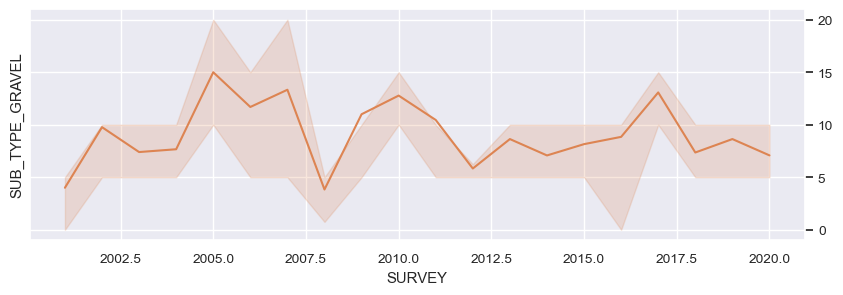





=========================== SUB_TYPE_PEBBLE ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: SUB_TYPE_PEBBLE 

UNIQUE numbers, strings, blanks, null = (17, 1, 0, 1)
number of numeric = 240
number of strings = 1
number of blanks = 0
number of null =  3

--------------------------------------------------
Histogram: SUB_TYPE_PEBBLE
CATEGORICAL


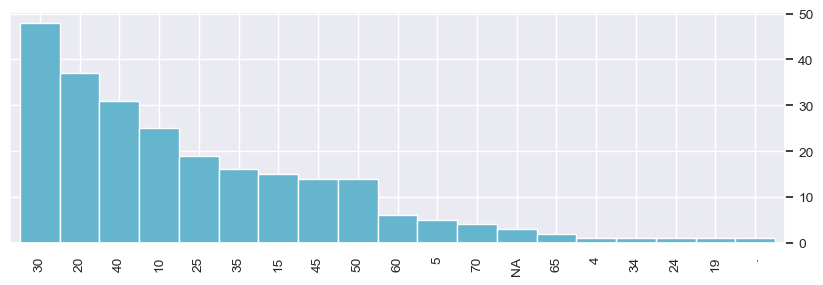


------------------------------------------------
Time Series:SUB_TYPE_PEBBLE
CATEGORICAL


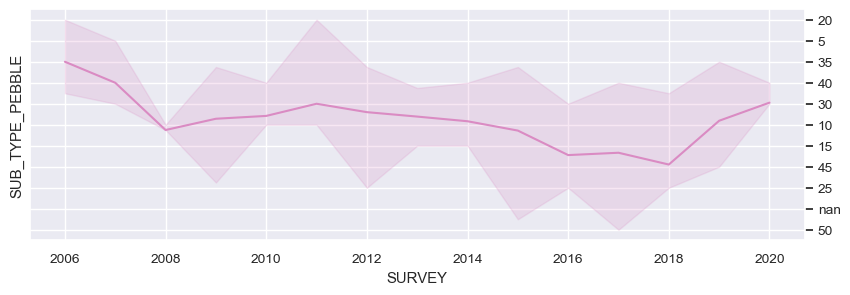


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: SUB_TYPE_PEBBLE 

UNIQUE numbers, strings, blanks, null = (18, 0, 0, 1)
number of numeric = 257
number of strings = 0
number of blanks = 0
number of null =  360

--------------------------------------------------
Histogram: SUB_TYPE_PEBBLE
NUMERICAL


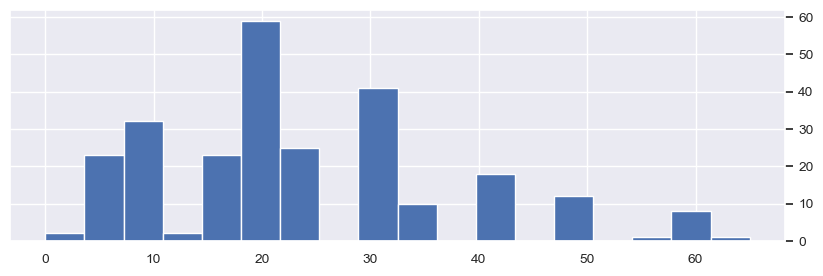


------------------------------------------------
Time Series:SUB_TYPE_PEBBLE
NUMERICAL


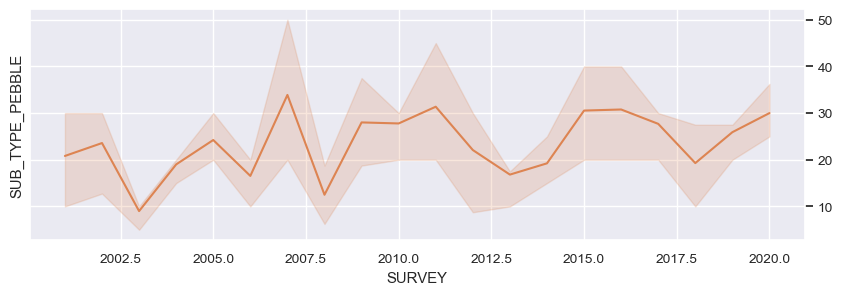





=========================== SUB_TYPE_ROCKS ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: SUB_TYPE_ROCKS 

UNIQUE numbers, strings, blanks, null = (13, 1, 0, 1)
number of numeric = 240
number of strings = 1
number of blanks = 0
number of null =  3

--------------------------------------------------
Histogram: SUB_TYPE_ROCKS
CATEGORICAL


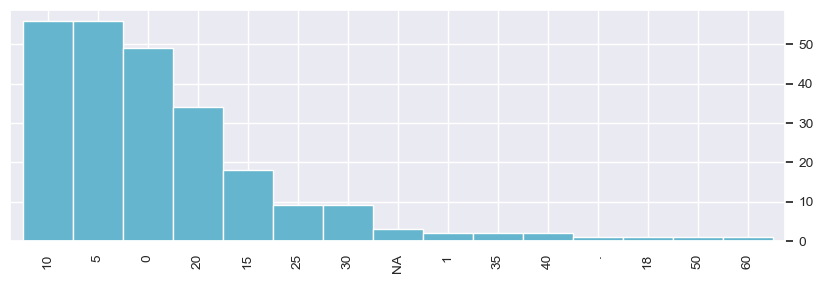


------------------------------------------------
Time Series:SUB_TYPE_ROCKS
CATEGORICAL


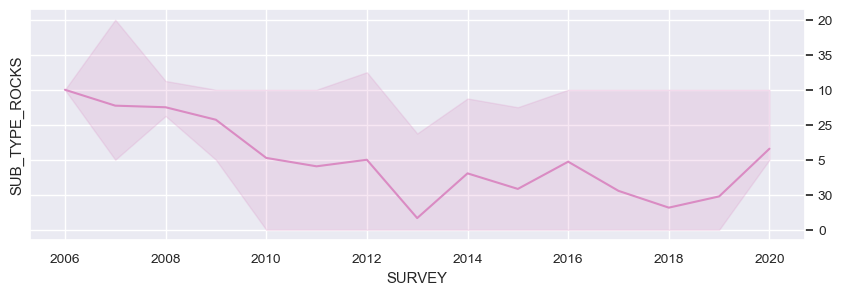


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: SUB_TYPE_ROCKS 

UNIQUE numbers, strings, blanks, null = (19, 0, 0, 1)
number of numeric = 257
number of strings = 0
number of blanks = 0
number of null =  360

--------------------------------------------------
Histogram: SUB_TYPE_ROCKS
NUMERICAL


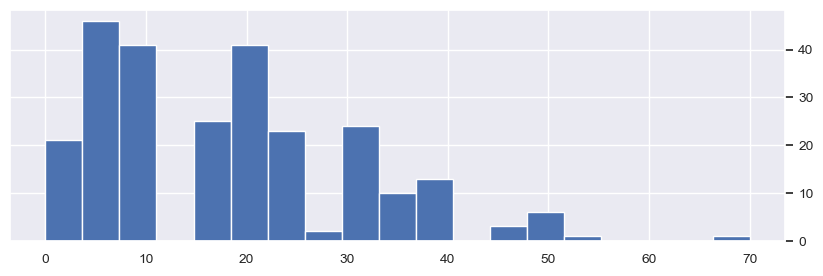


------------------------------------------------
Time Series:SUB_TYPE_ROCKS
NUMERICAL


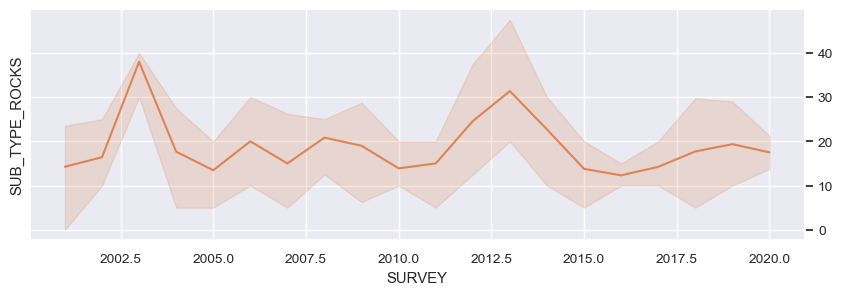





=========================== SUB_TYPE_SAND ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: SUB_TYPE_SAND 

UNIQUE numbers, strings, blanks, null = (10, 1, 0, 1)
number of numeric = 240
number of strings = 1
number of blanks = 0
number of null =  3

--------------------------------------------------
Histogram: SUB_TYPE_SAND
CATEGORICAL


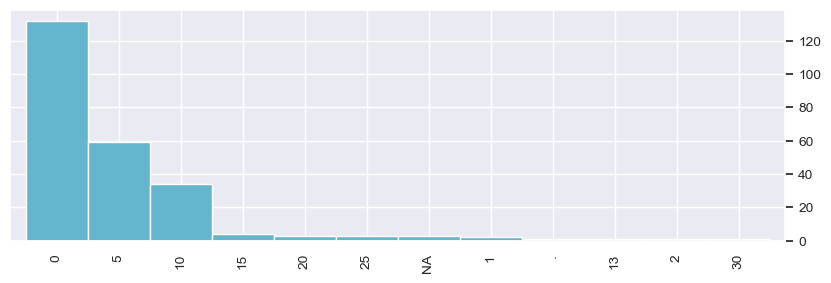


------------------------------------------------
Time Series:SUB_TYPE_SAND
CATEGORICAL


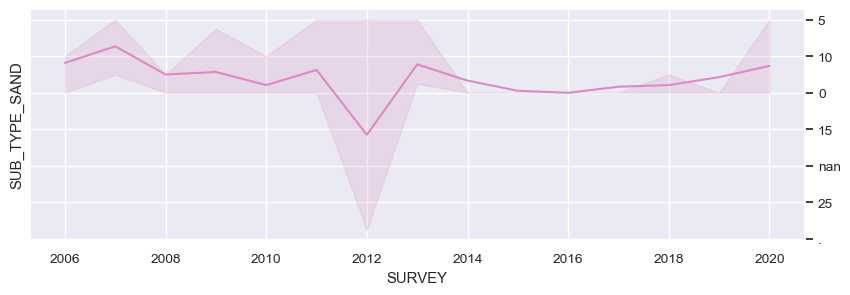


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: SUB_TYPE_SAND 

UNIQUE numbers, strings, blanks, null = (9, 0, 0, 1)
number of numeric = 258
number of strings = 0
number of blanks = 0
number of null =  359

--------------------------------------------------
Histogram: SUB_TYPE_SAND
NUMERICAL


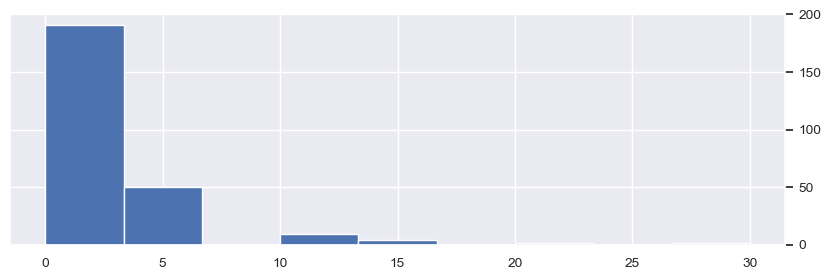


------------------------------------------------
Time Series:SUB_TYPE_SAND
NUMERICAL


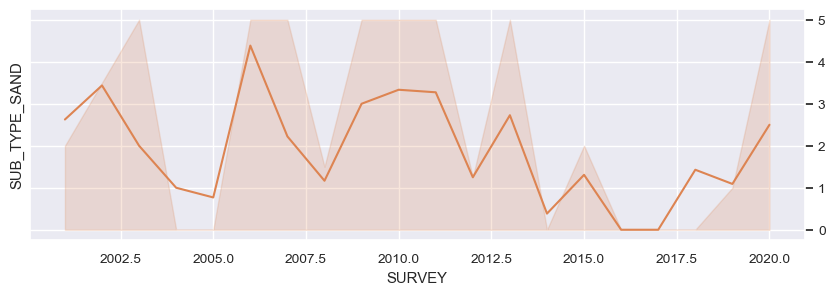





=========================== SURVEY ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: SURVEY 

UNIQUE numbers, strings, blanks, null = (15, 0, 0, 0)
number of numeric = 244
number of strings = 0
number of blanks = 0
number of null =  0

--------------------------------------------------
Histogram: SURVEY
NUMERICAL


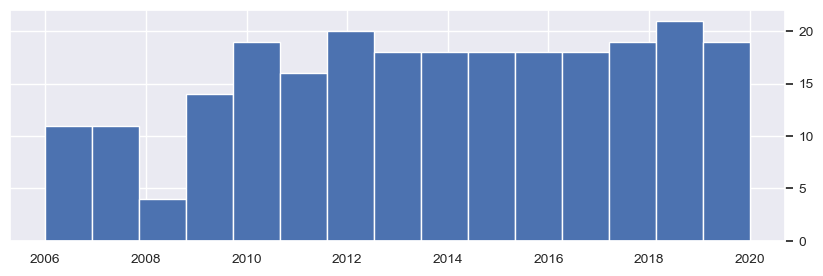


------------------------------------------------
Time Series:SURVEY
NUMERICAL


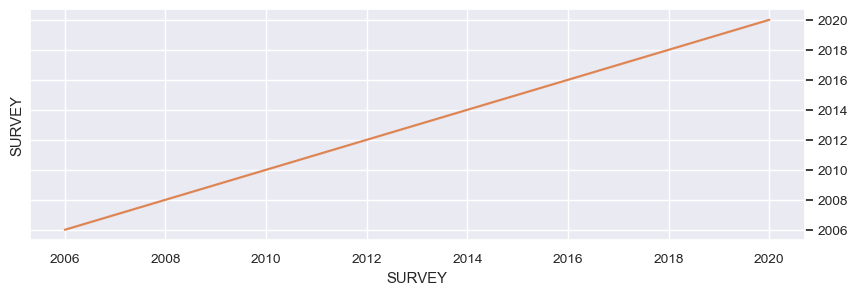


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: SURVEY 

UNIQUE numbers, strings, blanks, null = (51, 0, 0, 0)
number of numeric = 617
number of strings = 0
number of blanks = 0
number of null =  0

--------------------------------------------------
Histogram: SURVEY
NUMERICAL


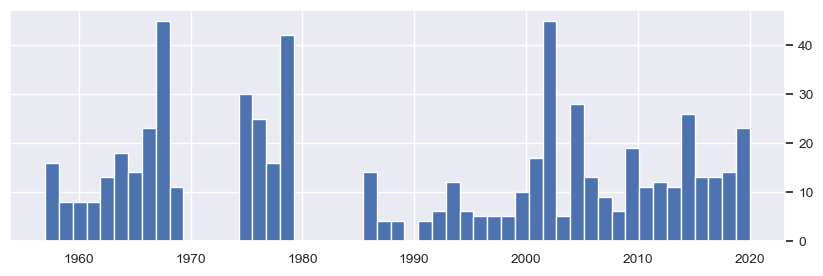


------------------------------------------------
Time Series:SURVEY
NUMERICAL


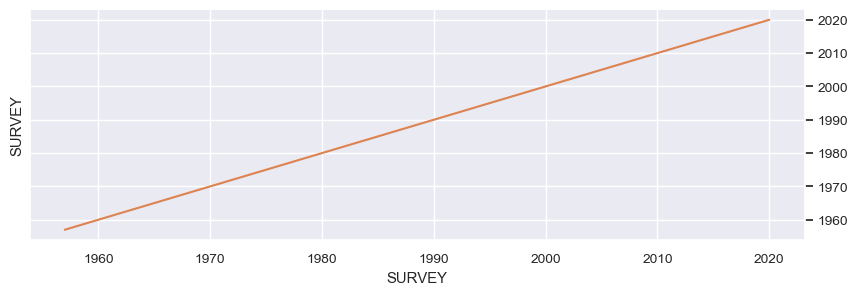





=========================== SWEEP0_5_TEMP ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: SWEEP0_5_TEMP 

UNIQUE numbers, strings, blanks, null = (40, 0, 0, 1)
number of numeric = 47
number of strings = 0
number of blanks = 0
number of null =  197

--------------------------------------------------
Histogram: SWEEP0_5_TEMP
NUMERICAL


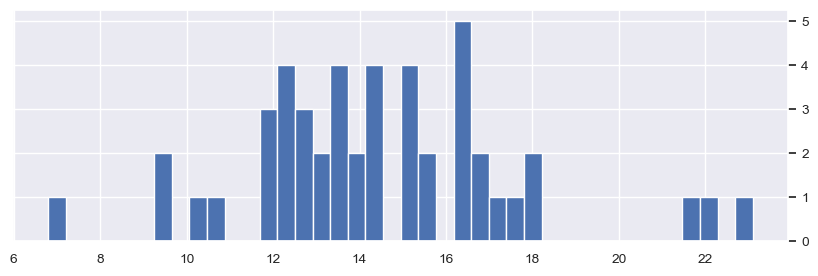


------------------------------------------------
Time Series:SWEEP0_5_TEMP
NUMERICAL


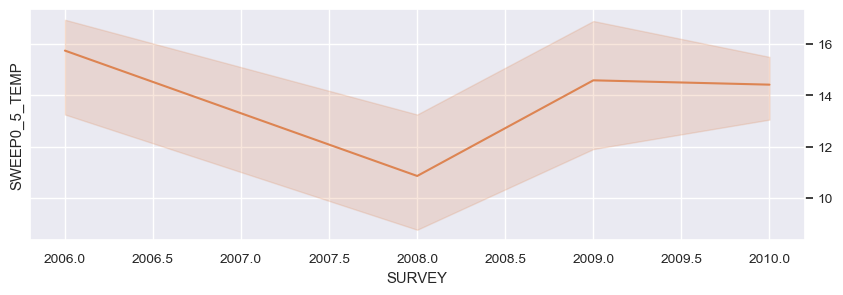


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: SWEEP0_5_TEMP 

UNIQUE numbers, strings, blanks, null = (34, 0, 0, 1)
number of numeric = 40
number of strings = 0
number of blanks = 0
number of null =  577

--------------------------------------------------
Histogram: SWEEP0_5_TEMP
NUMERICAL


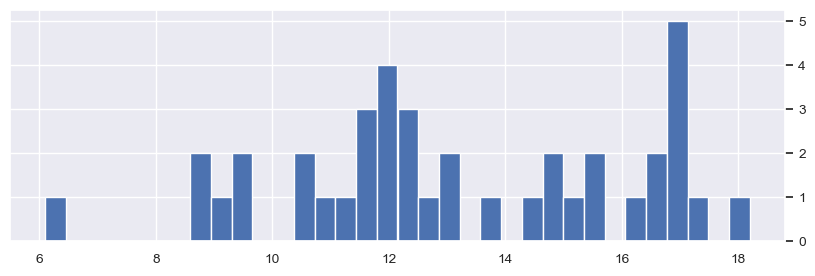


------------------------------------------------
Time Series:SWEEP0_5_TEMP
NUMERICAL


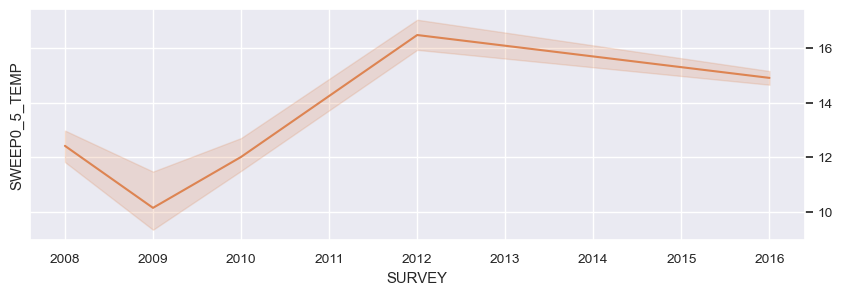





=========================== SWEEP0_5_TIME ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: SWEEP0_5_TIME 

UNIQUE numbers, strings, blanks, null = (161, 0, 0, 1)
number of numeric = 238
number of strings = 0
number of blanks = 0
number of null =  6

--------------------------------------------------
Histogram: SWEEP0_5_TIME
NUMERICAL


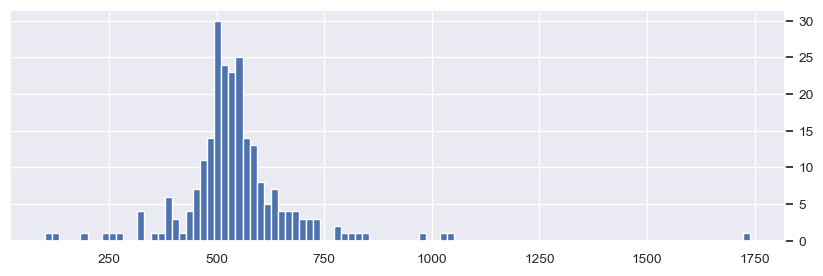


------------------------------------------------
Time Series:SWEEP0_5_TIME
NUMERICAL


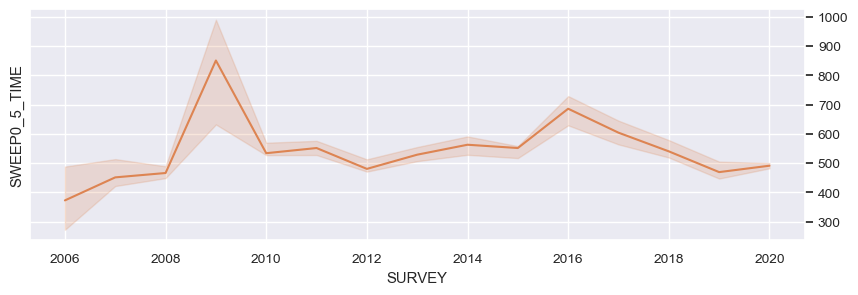


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: SWEEP0_5_TIME 

UNIQUE numbers, strings, blanks, null = (215, 0, 0, 1)
number of numeric = 271
number of strings = 0
number of blanks = 0
number of null =  346

--------------------------------------------------
Histogram: SWEEP0_5_TIME
NUMERICAL


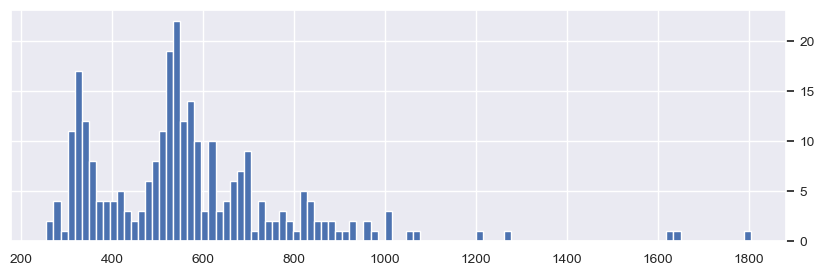


------------------------------------------------
Time Series:SWEEP0_5_TIME
NUMERICAL


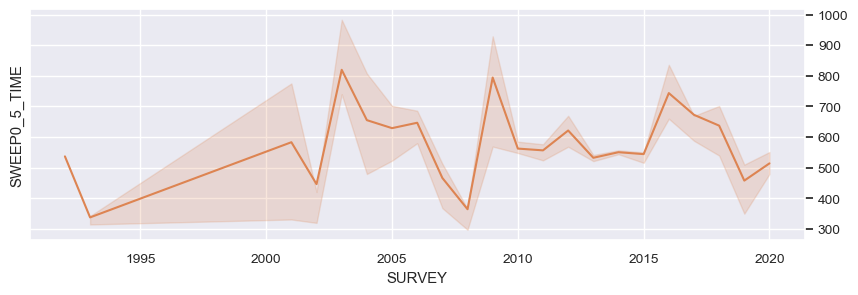





=========================== SWEEP1_TEMP ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
COLUMN MISSING OR NULL: SWEEP1_TEMP

		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: SWEEP1_TEMP 

UNIQUE numbers, strings, blanks, null = (69, 0, 0, 1)
number of numeric = 162
number of strings = 0
number of blanks = 0
number of null =  455

--------------------------------------------------
Histogram: SWEEP1_TEMP
NUMERICAL


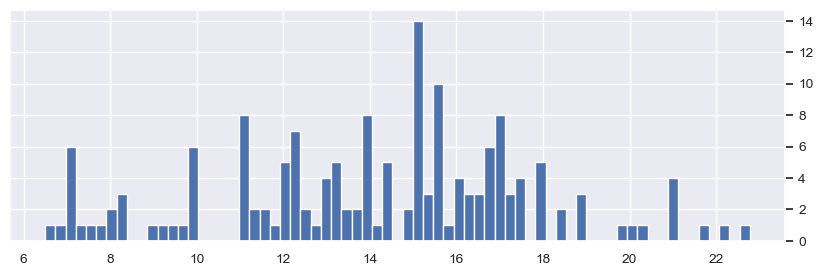


------------------------------------------------
Time Series:SWEEP1_TEMP
NUMERICAL


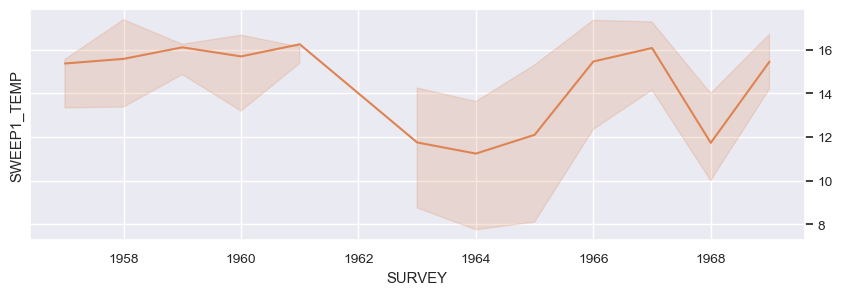





=========================== SWEEP1_TIME ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
COLUMN MISSING OR NULL: SWEEP1_TIME

		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: SWEEP1_TIME 

UNIQUE numbers, strings, blanks, null = (126, 0, 0, 1)
number of numeric = 376
number of strings = 0
number of blanks = 0
number of null =  241

--------------------------------------------------
Histogram: SWEEP1_TIME
NUMERICAL


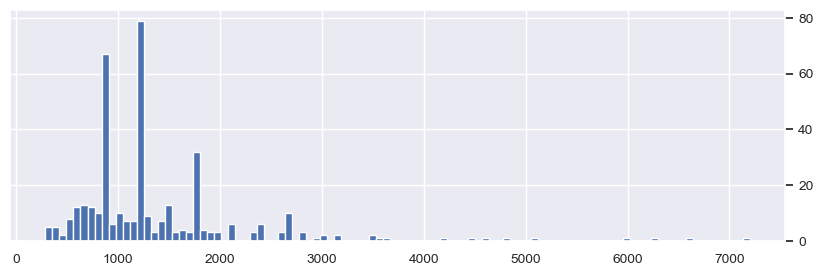


------------------------------------------------
Time Series:SWEEP1_TIME
NUMERICAL


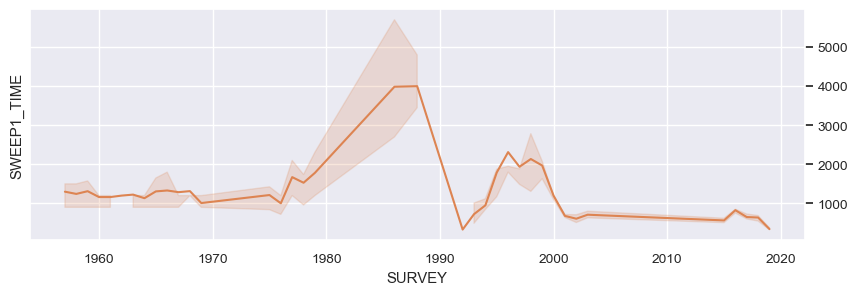





=========================== SWEEP2_TEMP ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
COLUMN MISSING OR NULL: SWEEP2_TEMP

		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: SWEEP2_TEMP 

UNIQUE numbers, strings, blanks, null = (76, 0, 0, 1)
number of numeric = 162
number of strings = 0
number of blanks = 0
number of null =  455

--------------------------------------------------
Histogram: SWEEP2_TEMP
NUMERICAL


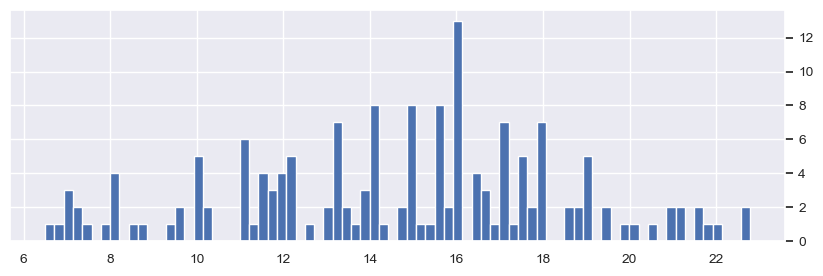


------------------------------------------------
Time Series:SWEEP2_TEMP
NUMERICAL


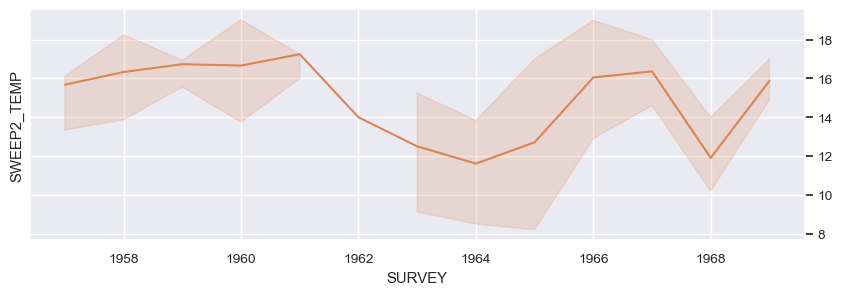





=========================== SWEEP2_TIME ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
COLUMN MISSING OR NULL: SWEEP2_TIME

		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: SWEEP2_TIME 

UNIQUE numbers, strings, blanks, null = (114, 0, 0, 1)
number of numeric = 374
number of strings = 0
number of blanks = 0
number of null =  243

--------------------------------------------------
Histogram: SWEEP2_TIME
NUMERICAL


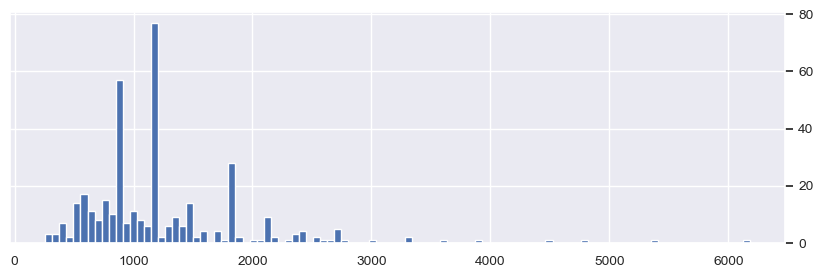


------------------------------------------------
Time Series:SWEEP2_TIME
NUMERICAL


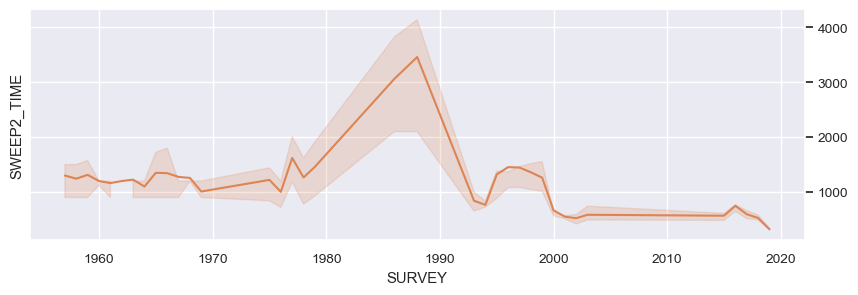





=========================== SWEEP3_TEMP ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
COLUMN MISSING OR NULL: SWEEP3_TEMP

		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: SWEEP3_TEMP 

UNIQUE numbers, strings, blanks, null = (81, 0, 0, 1)
number of numeric = 160
number of strings = 0
number of blanks = 0
number of null =  457

--------------------------------------------------
Histogram: SWEEP3_TEMP
NUMERICAL


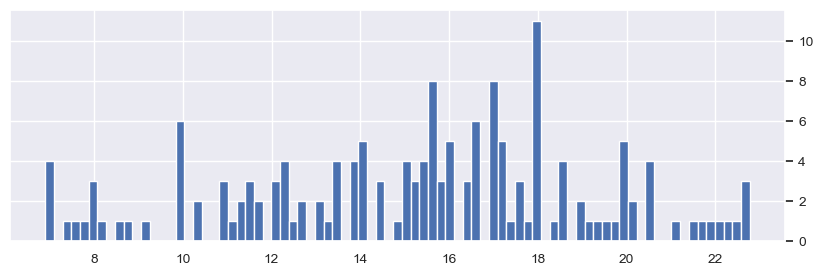


------------------------------------------------
Time Series:SWEEP3_TEMP
NUMERICAL


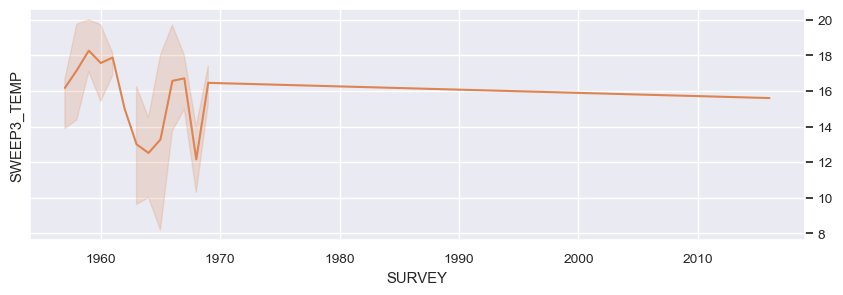





=========================== SWEEP3_TIME ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
COLUMN MISSING OR NULL: SWEEP3_TIME

		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: SWEEP3_TIME 

UNIQUE numbers, strings, blanks, null = (111, 0, 0, 1)
number of numeric = 365
number of strings = 0
number of blanks = 0
number of null =  252

--------------------------------------------------
Histogram: SWEEP3_TIME
NUMERICAL


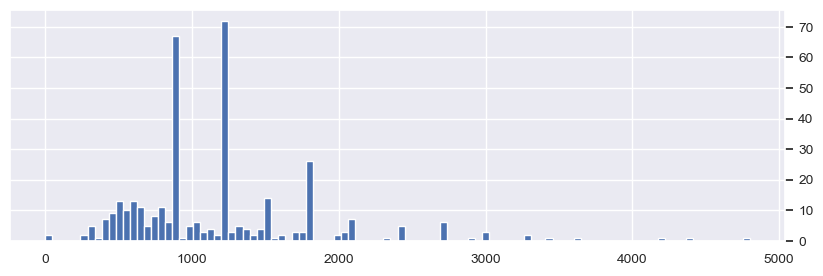


------------------------------------------------
Time Series:SWEEP3_TIME
NUMERICAL


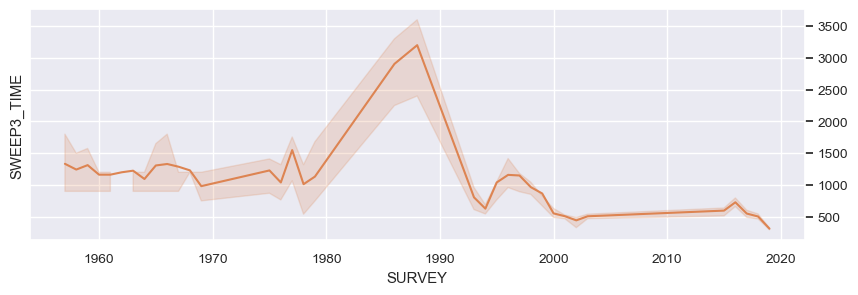





=========================== SWEEP4_TEMP ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
COLUMN MISSING OR NULL: SWEEP4_TEMP

		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: SWEEP4_TEMP 

UNIQUE numbers, strings, blanks, null = (75, 0, 0, 1)
number of numeric = 156
number of strings = 0
number of blanks = 0
number of null =  461

--------------------------------------------------
Histogram: SWEEP4_TEMP
NUMERICAL


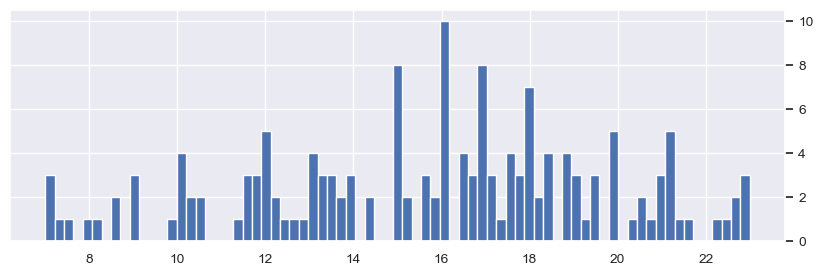


------------------------------------------------
Time Series:SWEEP4_TEMP
NUMERICAL


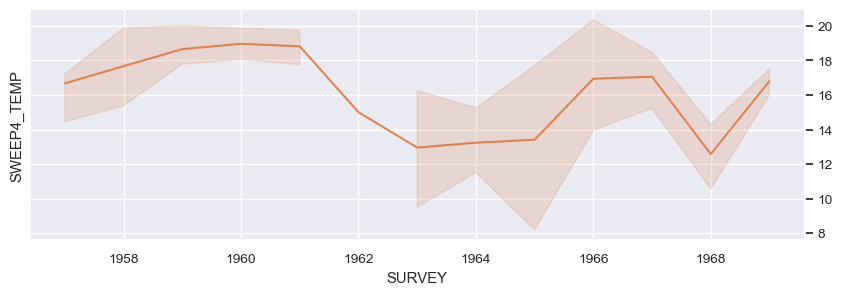





=========================== SWEEP4_TIME ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
COLUMN MISSING OR NULL: SWEEP4_TIME

		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: SWEEP4_TIME 

UNIQUE numbers, strings, blanks, null = (63, 0, 0, 1)
number of numeric = 306
number of strings = 0
number of blanks = 0
number of null =  311

--------------------------------------------------
Histogram: SWEEP4_TIME
NUMERICAL


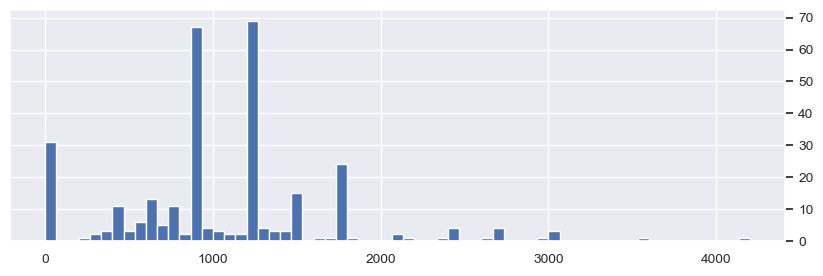


------------------------------------------------
Time Series:SWEEP4_TIME
NUMERICAL


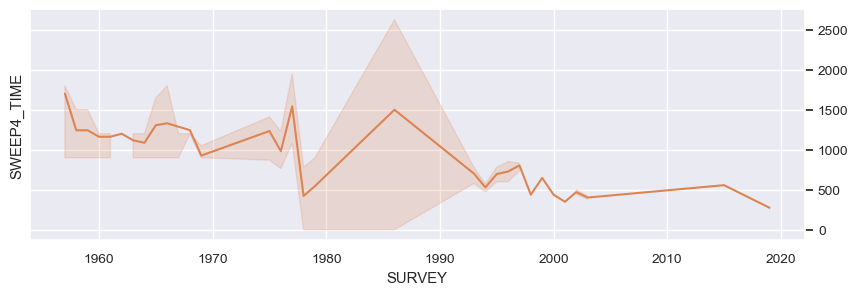





=========================== SWEEP5_TEMP ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
COLUMN MISSING OR NULL: SWEEP5_TEMP

		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: SWEEP5_TEMP 

UNIQUE numbers, strings, blanks, null = (80, 0, 0, 1)
number of numeric = 146
number of strings = 0
number of blanks = 0
number of null =  471

--------------------------------------------------
Histogram: SWEEP5_TEMP
NUMERICAL


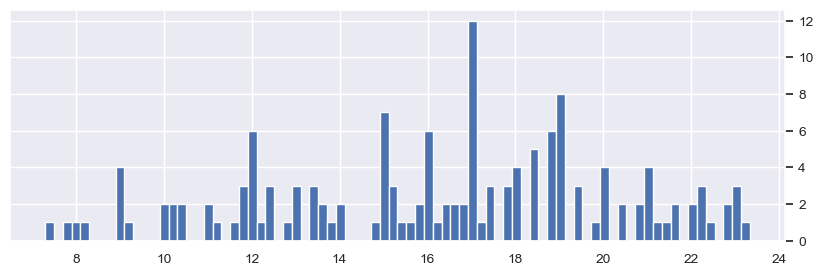


------------------------------------------------
Time Series:SWEEP5_TEMP
NUMERICAL


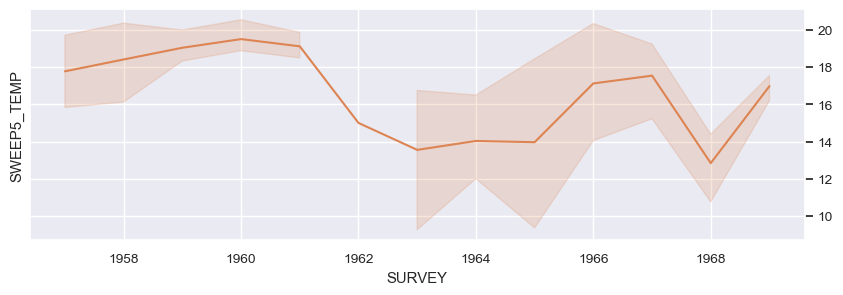





=========================== SWEEP5_TIME ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
COLUMN MISSING OR NULL: SWEEP5_TIME

		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: SWEEP5_TIME 

UNIQUE numbers, strings, blanks, null = (26, 0, 0, 1)
number of numeric = 242
number of strings = 0
number of blanks = 0
number of null =  375

--------------------------------------------------
Histogram: SWEEP5_TIME
NUMERICAL


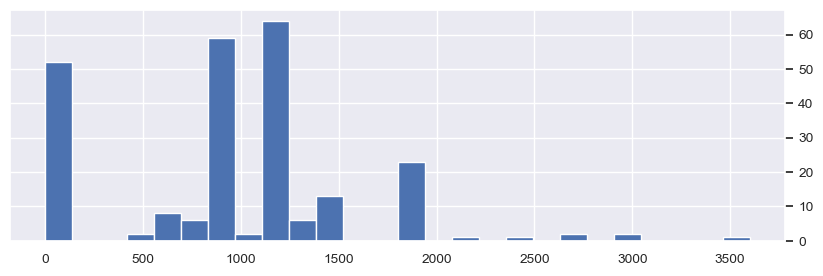


------------------------------------------------
Time Series:SWEEP5_TIME
NUMERICAL


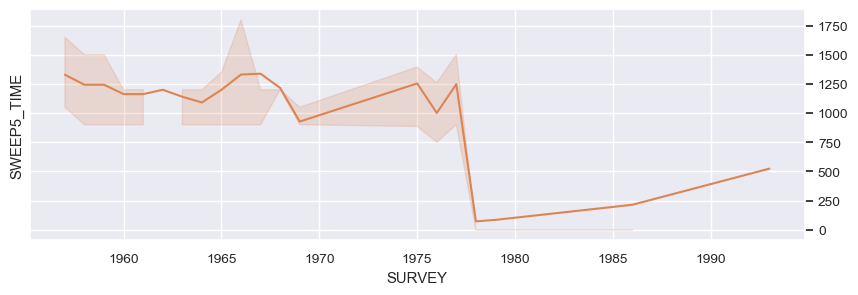





=========================== SWEEP6_TEMP ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
COLUMN MISSING OR NULL: SWEEP6_TEMP

		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: SWEEP6_TEMP 

UNIQUE numbers, strings, blanks, null = (68, 0, 0, 1)
number of numeric = 118
number of strings = 0
number of blanks = 0
number of null =  499

--------------------------------------------------
Histogram: SWEEP6_TEMP
NUMERICAL


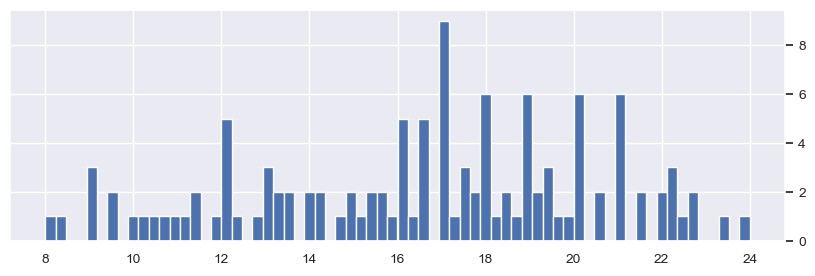


------------------------------------------------
Time Series:SWEEP6_TEMP
NUMERICAL


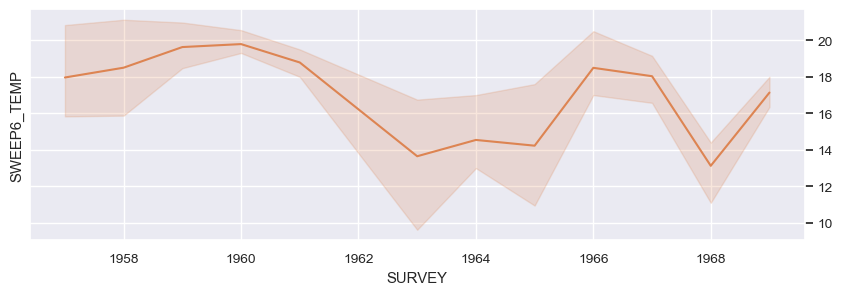





=========================== SWEEP6_TIME ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
COLUMN MISSING OR NULL: SWEEP6_TIME

		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: SWEEP6_TIME 

UNIQUE numbers, strings, blanks, null = (9, 0, 0, 1)
number of numeric = 167
number of strings = 0
number of blanks = 0
number of null =  450

--------------------------------------------------
Histogram: SWEEP6_TIME
NUMERICAL


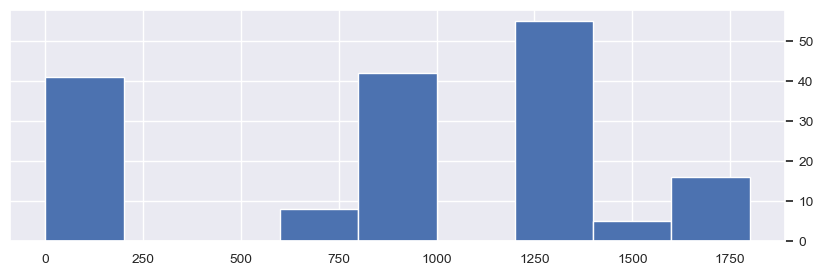


------------------------------------------------
Time Series:SWEEP6_TIME
NUMERICAL


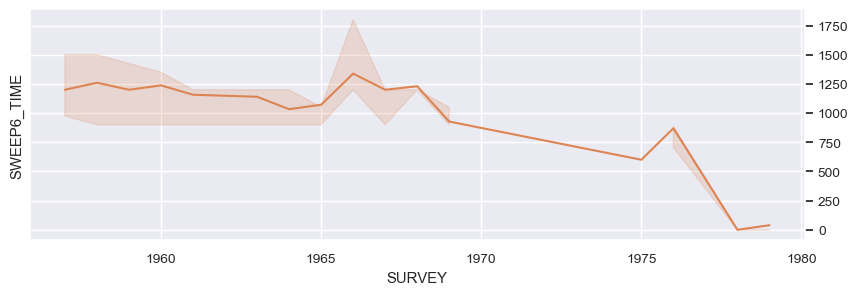





=========================== TOS1 ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: TOS1 

UNIQUE numbers, strings, blanks, null = (20, 0, 0, 1)
number of numeric = 197
number of strings = 0
number of blanks = 0
number of null =  47

--------------------------------------------------
Histogram: TOS1
NUMERICAL


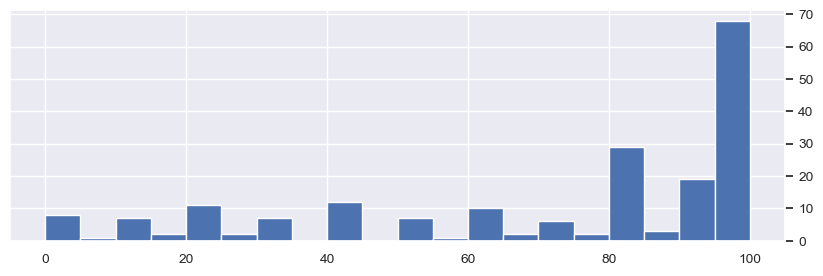


------------------------------------------------
Time Series:TOS1
NUMERICAL


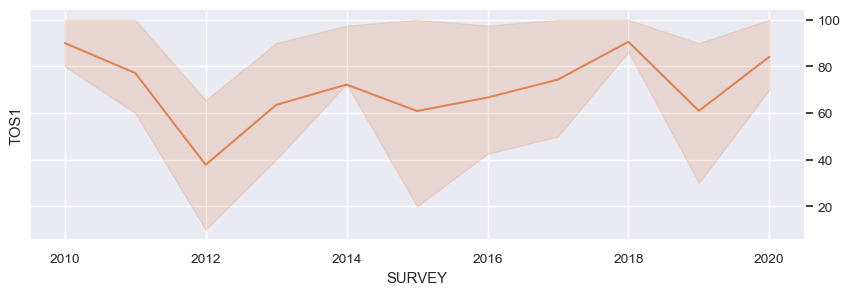


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: TOS1 

UNIQUE numbers, strings, blanks, null = (17, 0, 0, 1)
number of numeric = 183
number of strings = 0
number of blanks = 0
number of null =  434

--------------------------------------------------
Histogram: TOS1
NUMERICAL


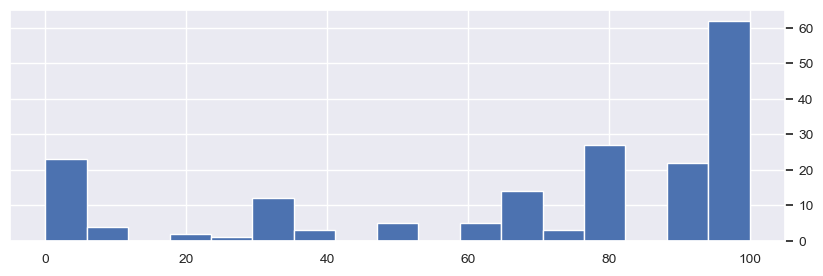


------------------------------------------------
Time Series:TOS1
NUMERICAL


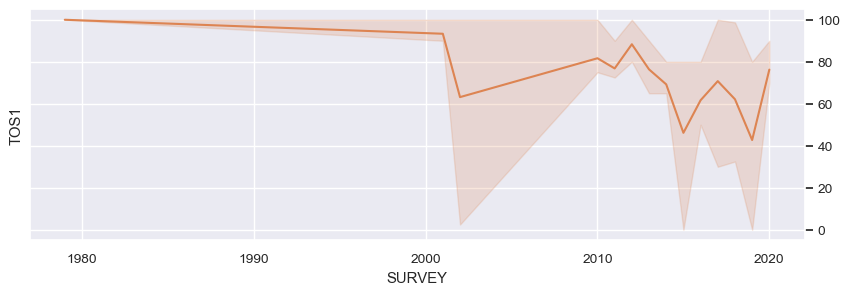





=========================== TOS2 ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: TOS2 

UNIQUE numbers, strings, blanks, null = (20, 0, 0, 1)
number of numeric = 197
number of strings = 0
number of blanks = 0
number of null =  47

--------------------------------------------------
Histogram: TOS2
NUMERICAL


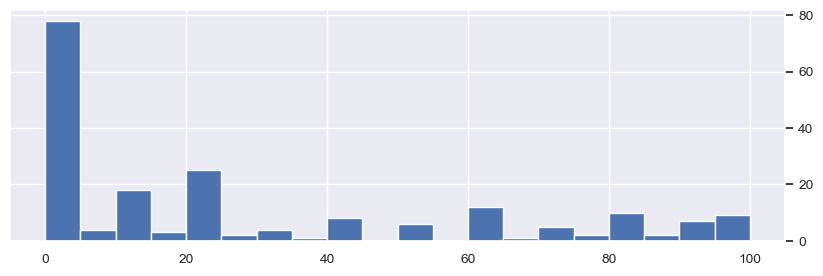


------------------------------------------------
Time Series:TOS2
NUMERICAL


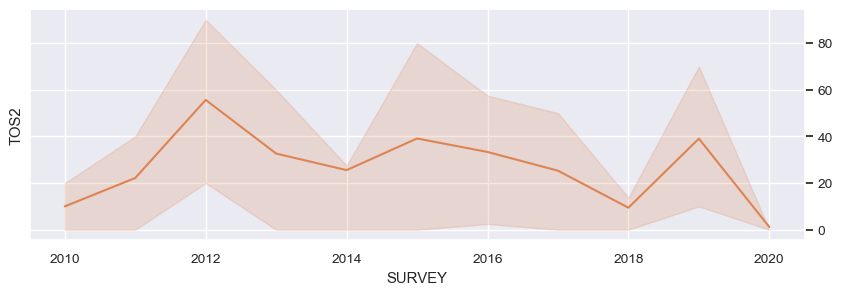


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: TOS2 

UNIQUE numbers, strings, blanks, null = (17, 0, 0, 1)
number of numeric = 184
number of strings = 0
number of blanks = 0
number of null =  433

--------------------------------------------------
Histogram: TOS2
NUMERICAL


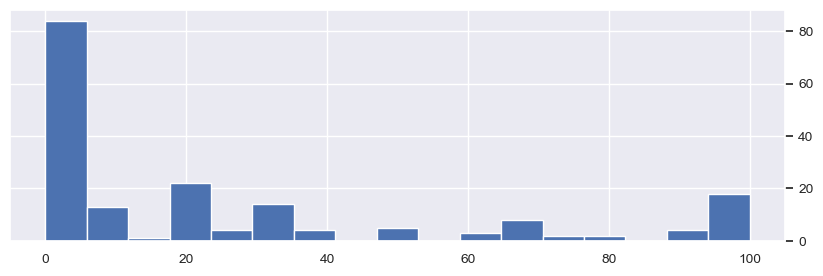


------------------------------------------------
Time Series:TOS2
NUMERICAL


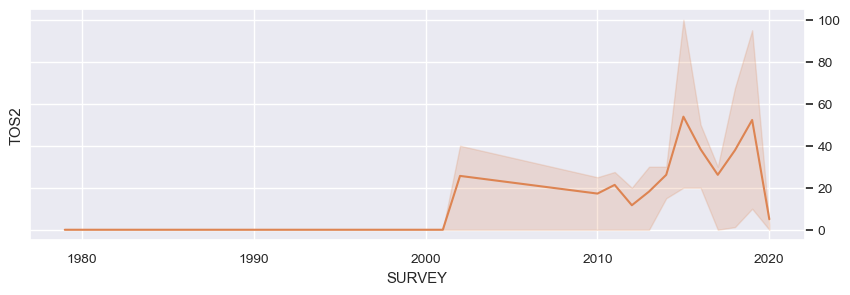





=========================== TOS3 ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: TOS3 

UNIQUE numbers, strings, blanks, null = (6, 0, 0, 1)
number of numeric = 197
number of strings = 0
number of blanks = 0
number of null =  47

--------------------------------------------------
Histogram: TOS3
NUMERICAL


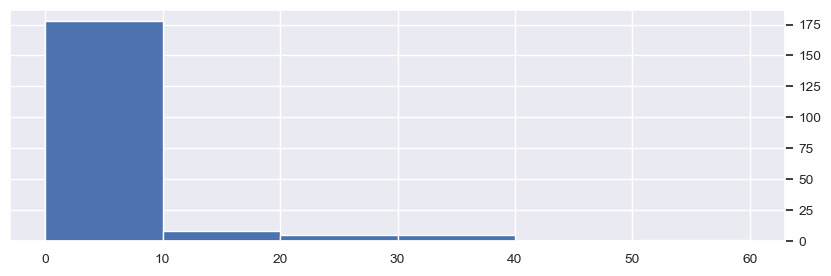


------------------------------------------------
Time Series:TOS3
NUMERICAL


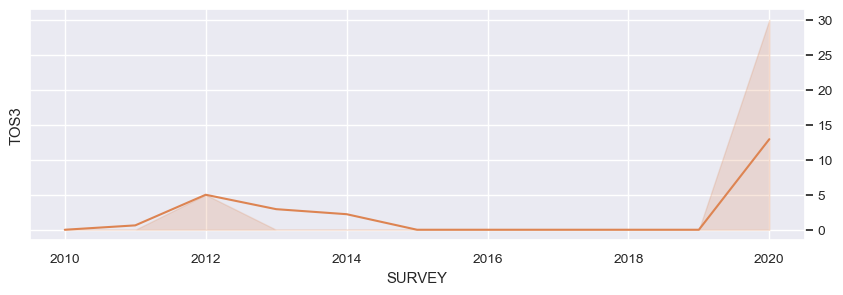


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: TOS3 

UNIQUE numbers, strings, blanks, null = (10, 0, 0, 1)
number of numeric = 184
number of strings = 0
number of blanks = 0
number of null =  433

--------------------------------------------------
Histogram: TOS3
NUMERICAL


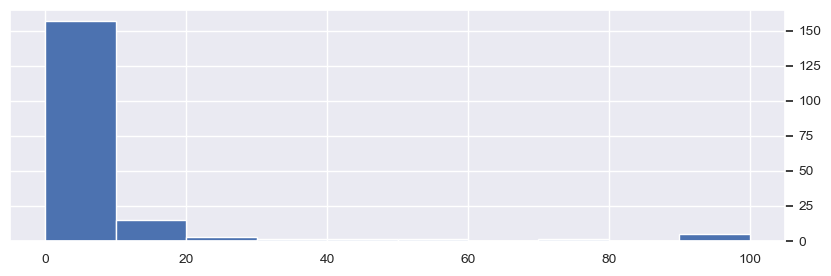


------------------------------------------------
Time Series:TOS3
NUMERICAL


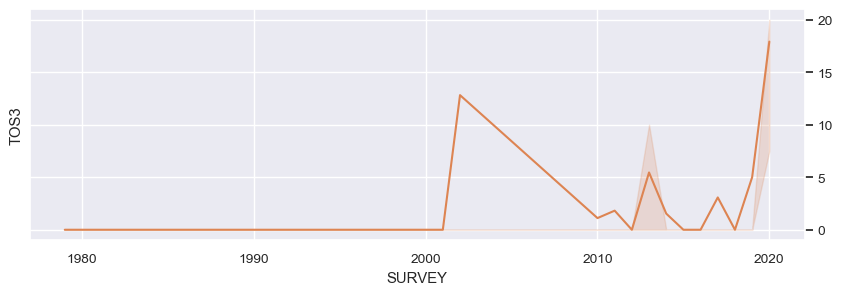





=========================== TOS4 ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: TOS4 

UNIQUE numbers, strings, blanks, null = (5, 0, 0, 1)
number of numeric = 197
number of strings = 0
number of blanks = 0
number of null =  47

--------------------------------------------------
Histogram: TOS4
NUMERICAL


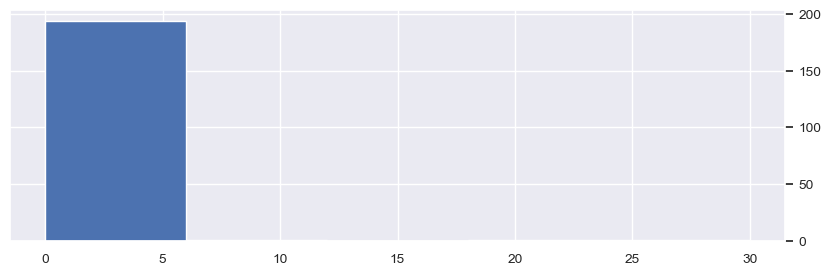


------------------------------------------------
Time Series:TOS4
NUMERICAL


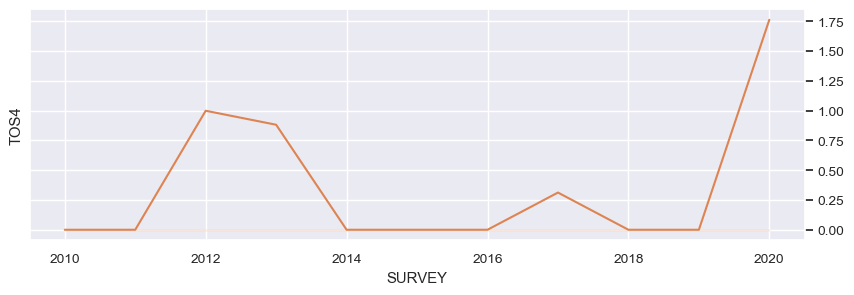


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: TOS4 

UNIQUE numbers, strings, blanks, null = (3, 0, 0, 1)
number of numeric = 184
number of strings = 0
number of blanks = 0
number of null =  433

--------------------------------------------------
Histogram: TOS4
NUMERICAL


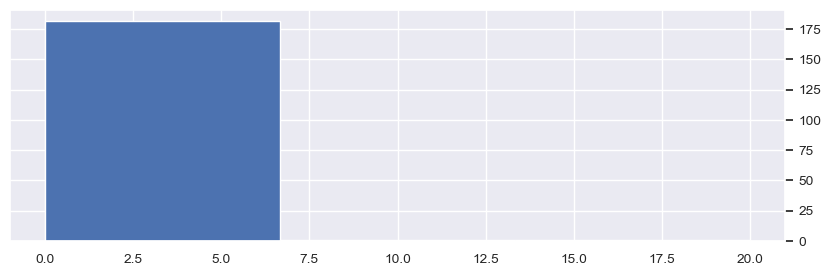


------------------------------------------------
Time Series:TOS4
NUMERICAL


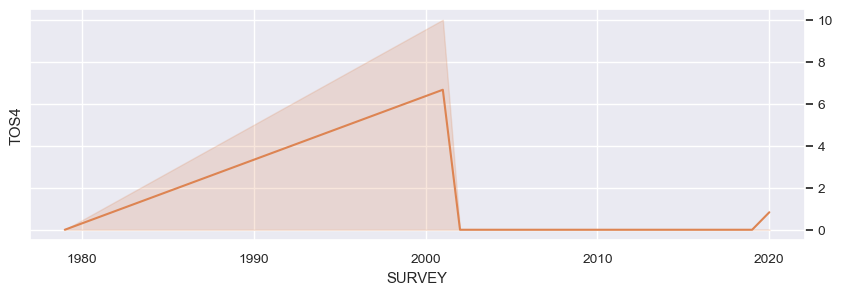





=========================== WATER_CONDUCTIVITY ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: WATER_CONDUCTIVITY 

UNIQUE numbers, strings, blanks, null = (168, 0, 0, 1)
number of numeric = 190
number of strings = 0
number of blanks = 0
number of null =  54

--------------------------------------------------
Histogram: WATER_CONDUCTIVITY
NUMERICAL


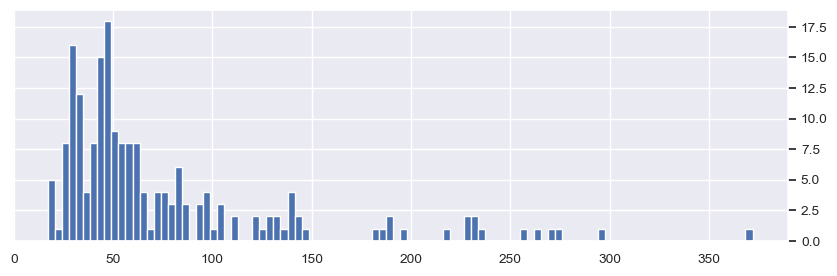


------------------------------------------------
Time Series:WATER_CONDUCTIVITY
NUMERICAL


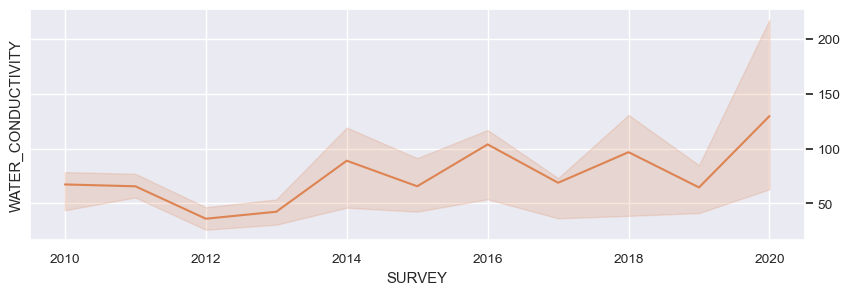


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: WATER_CONDUCTIVITY 

UNIQUE numbers, strings, blanks, null = (234, 0, 0, 1)
number of numeric = 349
number of strings = 0
number of blanks = 0
number of null =  268

--------------------------------------------------
Histogram: WATER_CONDUCTIVITY
NUMERICAL


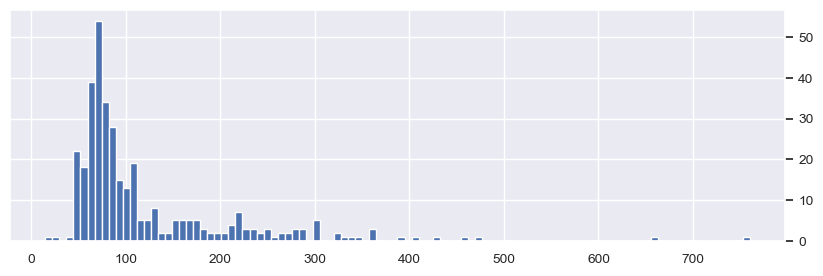


------------------------------------------------
Time Series:WATER_CONDUCTIVITY
NUMERICAL


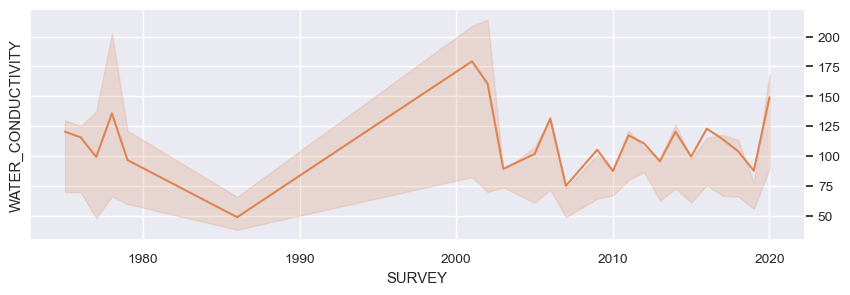





=========================== WATER_CONDUCTIVITY_RESOLUTION ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
COLUMN MISSING OR NULL: WATER_CONDUCTIVITY_RESOLUTION

		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: WATER_CONDUCTIVITY_RESOLUTION 

UNIQUE numbers, strings, blanks, null = (6, 0, 0, 1)
number of numeric = 6
number of strings = 0
number of blanks = 0
number of null =  611

--------------------------------------------------
Histogram: WATER_CONDUCTIVITY_RESOLUTION
NUMERICAL


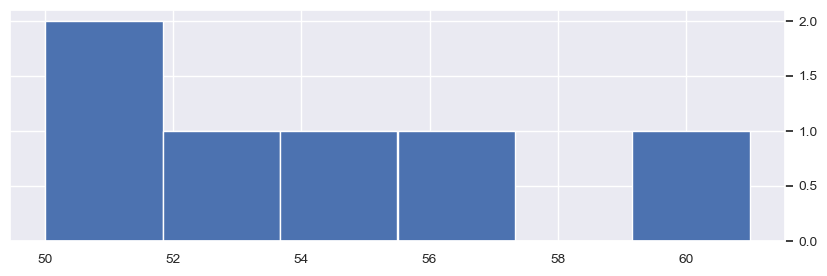


------------------------------------------------
Time Series:WATER_CONDUCTIVITY_RESOLUTION
NUMERICAL


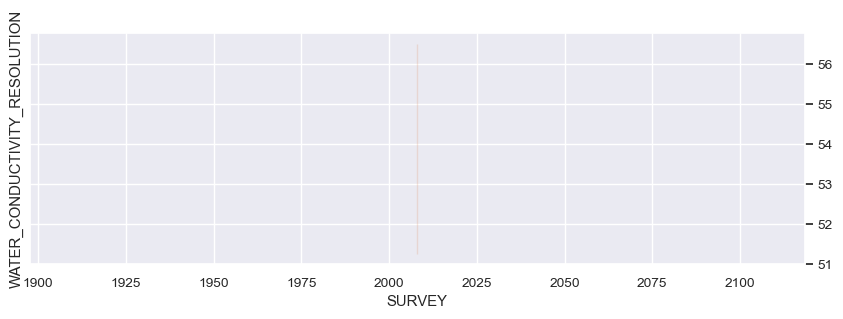





=========================== WATER_PH ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: WATER_PH 

UNIQUE numbers, strings, blanks, null = (21, 0, 0, 1)
number of numeric = 25
number of strings = 0
number of blanks = 0
number of null =  219

--------------------------------------------------
Histogram: WATER_PH
NUMERICAL


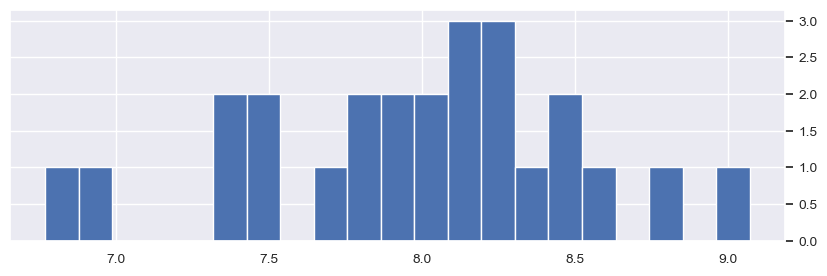


------------------------------------------------
Time Series:WATER_PH
NUMERICAL


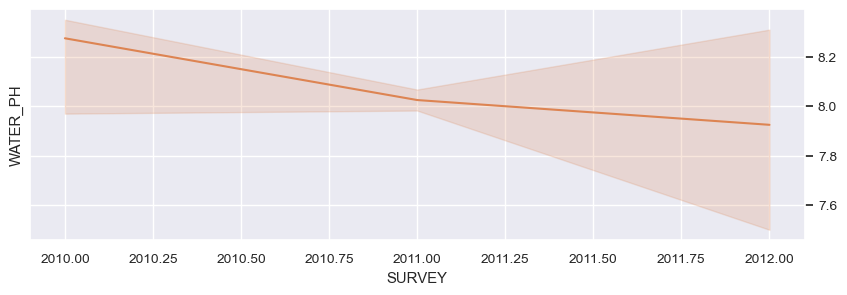


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: WATER_PH 

UNIQUE numbers, strings, blanks, null = (27, 0, 0, 1)
number of numeric = 45
number of strings = 0
number of blanks = 0
number of null =  572

--------------------------------------------------
Histogram: WATER_PH
NUMERICAL


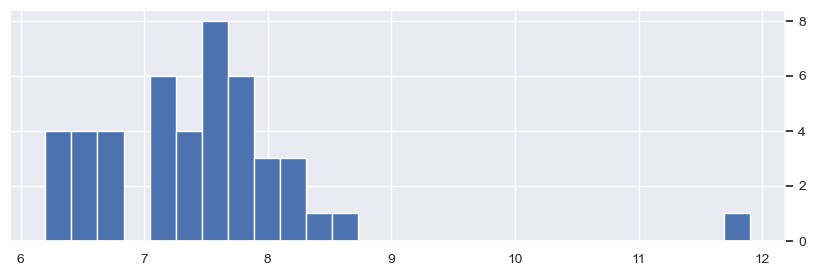


------------------------------------------------
Time Series:WATER_PH
NUMERICAL


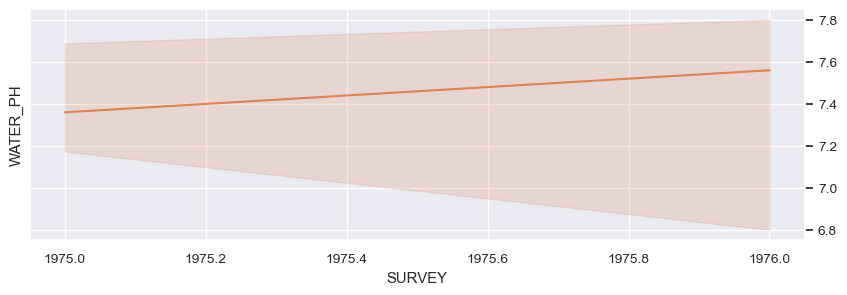





=========================== WATER_TEMP1 ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
COLUMN MISSING OR NULL: WATER_TEMP1

		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: WATER_TEMP1 

UNIQUE numbers, strings, blanks, null = (23, 0, 0, 1)
number of numeric = 34
number of strings = 0
number of blanks = 0
number of null =  583

--------------------------------------------------
Histogram: WATER_TEMP1
NUMERICAL


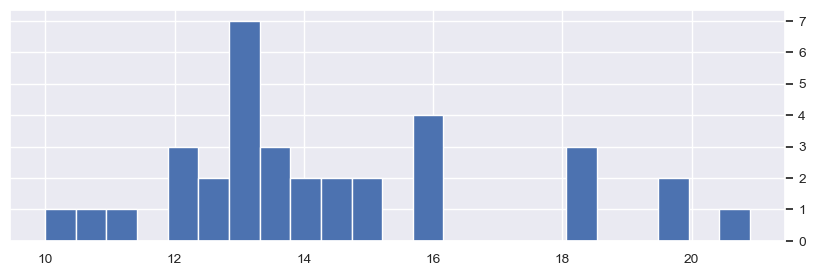


------------------------------------------------
Time Series:WATER_TEMP1
NUMERICAL


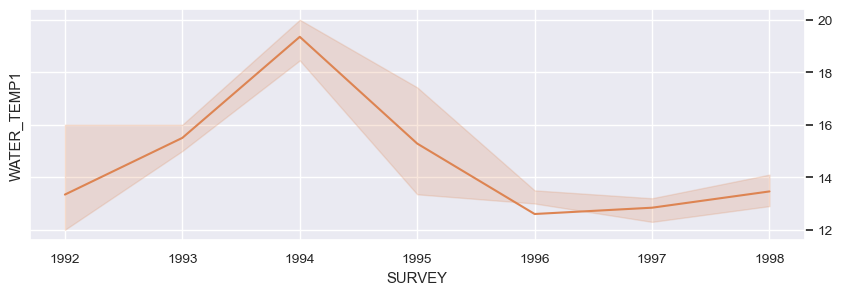





=========================== WATER_TEMPERATURE_ARRIVAL ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: WATER_TEMPERATURE_ARRIVAL 

UNIQUE numbers, strings, blanks, null = (83, 0, 0, 1)
number of numeric = 189
number of strings = 0
number of blanks = 0
number of null =  55

--------------------------------------------------
Histogram: WATER_TEMPERATURE_ARRIVAL
NUMERICAL


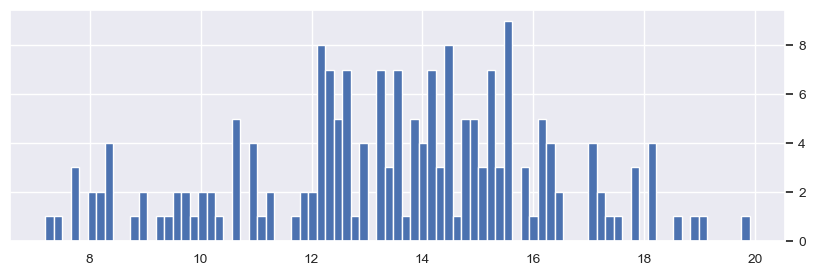


------------------------------------------------
Time Series:WATER_TEMPERATURE_ARRIVAL
NUMERICAL


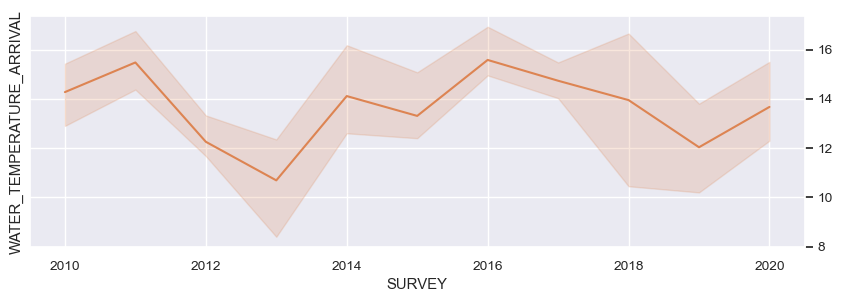


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: WATER_TEMPERATURE_ARRIVAL 

UNIQUE numbers, strings, blanks, null = (140, 0, 0, 1)
number of numeric = 362
number of strings = 0
number of blanks = 0
number of null =  255

--------------------------------------------------
Histogram: WATER_TEMPERATURE_ARRIVAL
NUMERICAL


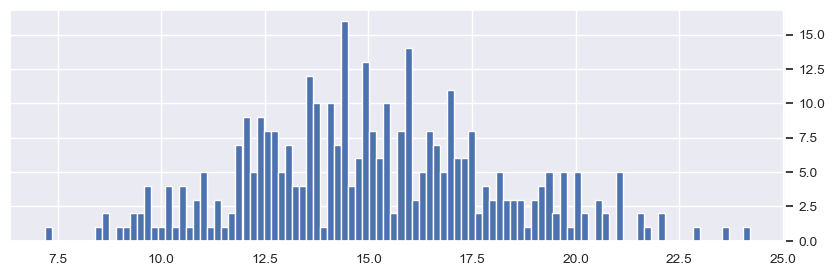


------------------------------------------------
Time Series:WATER_TEMPERATURE_ARRIVAL
NUMERICAL


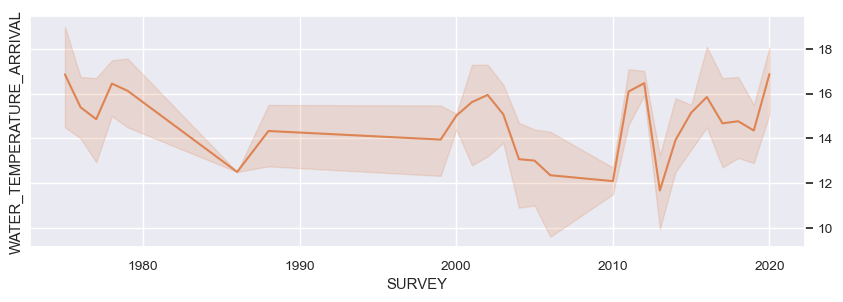





=========================== WATER_TEMPERATURE_DEPART ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
COLUMN MISSING OR NULL: WATER_TEMPERATURE_DEPART

		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: WATER_TEMPERATURE_DEPART 

UNIQUE numbers, strings, blanks, null = (1, 0, 0, 1)
number of numeric = 1
number of strings = 0
number of blanks = 0
number of null =  616

--------------------------------------------------
Histogram: WATER_TEMPERATURE_DEPART
NUMERICAL


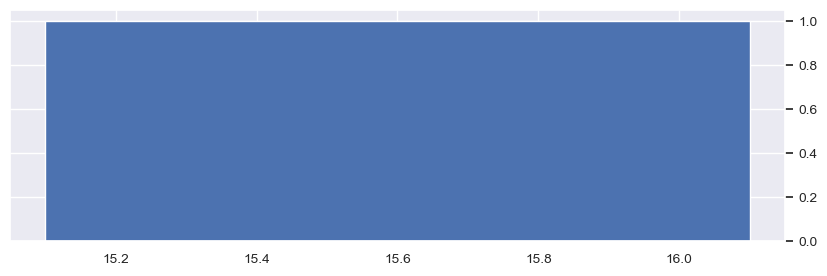


------------------------------------------------
Time Series:WATER_TEMPERATURE_DEPART
NUMERICAL


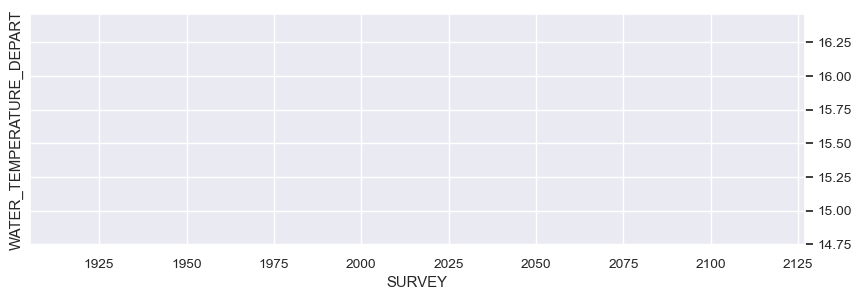





=========================== WEATHER ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: WEATHER 

UNIQUE numbers, strings, blanks, null = (0, 3, 0, 1)
number of numeric = 0
number of strings = 3
number of blanks = 0
number of null =  241

--------------------------------------------------
Histogram: WEATHER
CATEGORICAL


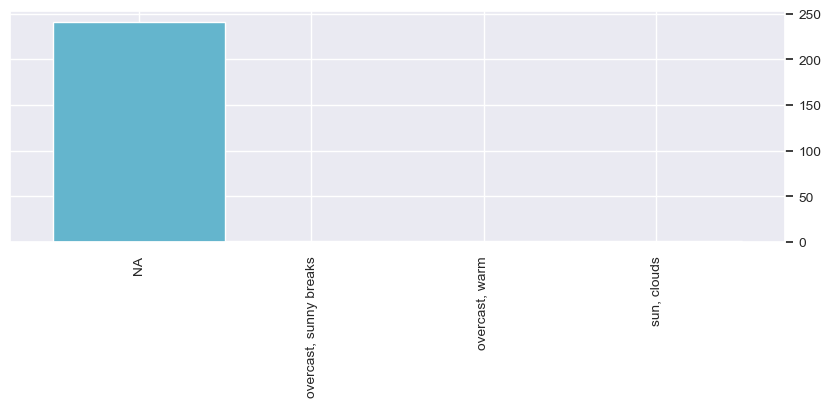


------------------------------------------------
Time Series:WEATHER
CATEGORICAL


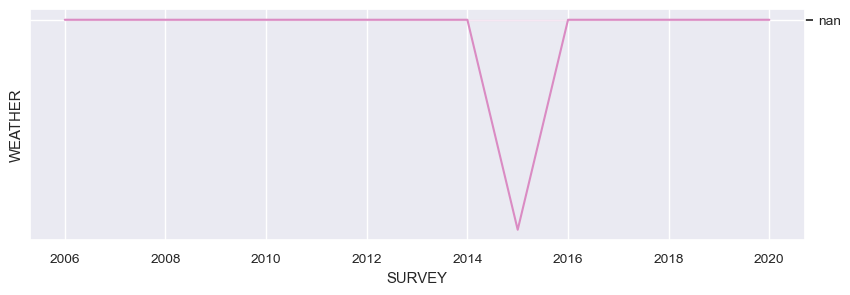


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: WEATHER 

UNIQUE numbers, strings, blanks, null = (0, 17, 0, 1)
number of numeric = 0
number of strings = 112
number of blanks = 0
number of null =  505

--------------------------------------------------
Histogram: WEATHER
CATEGORICAL


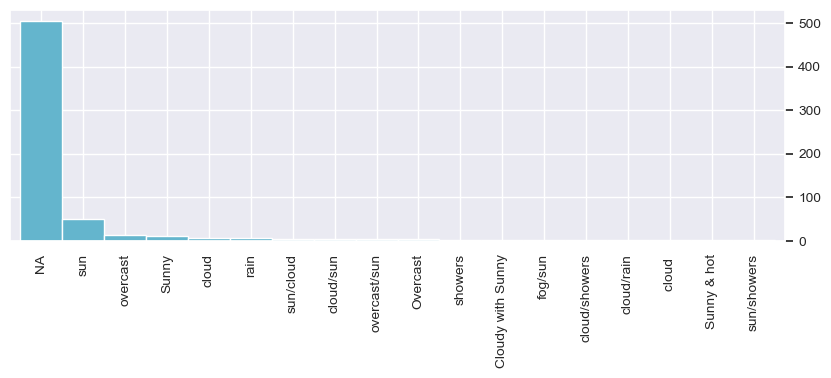


------------------------------------------------
Time Series:WEATHER
CATEGORICAL


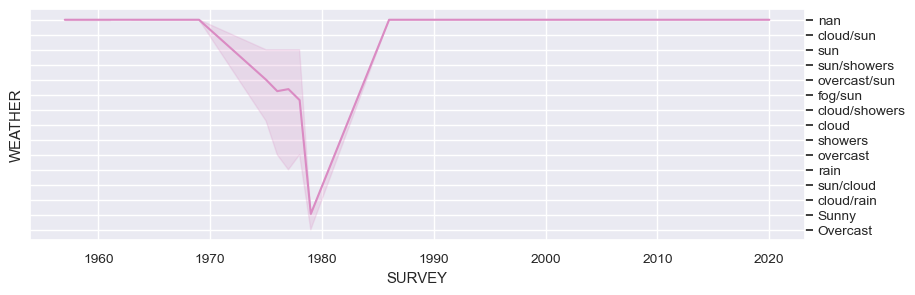





=========================== WIDTH_LOWER ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: WIDTH_LOWER 

UNIQUE numbers, strings, blanks, null = (100, 0, 0, 1)
number of numeric = 237
number of strings = 0
number of blanks = 0
number of null =  7

--------------------------------------------------
Histogram: WIDTH_LOWER
NUMERICAL


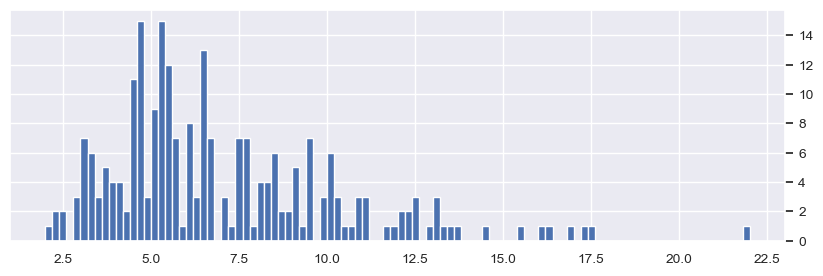


------------------------------------------------
Time Series:WIDTH_LOWER
NUMERICAL


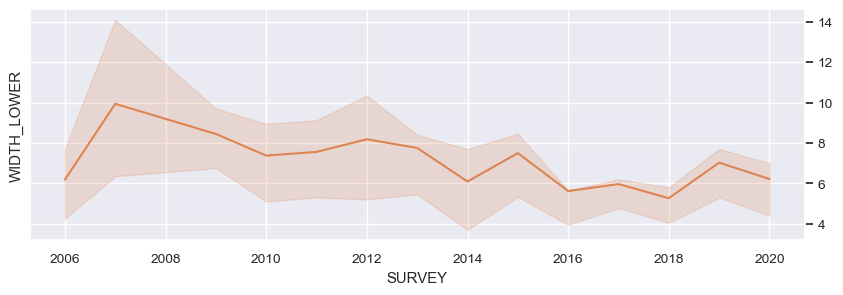


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: WIDTH_LOWER 

UNIQUE numbers, strings, blanks, null = (243, 0, 0, 1)
number of numeric = 583
number of strings = 0
number of blanks = 0
number of null =  34

--------------------------------------------------
Histogram: WIDTH_LOWER
NUMERICAL


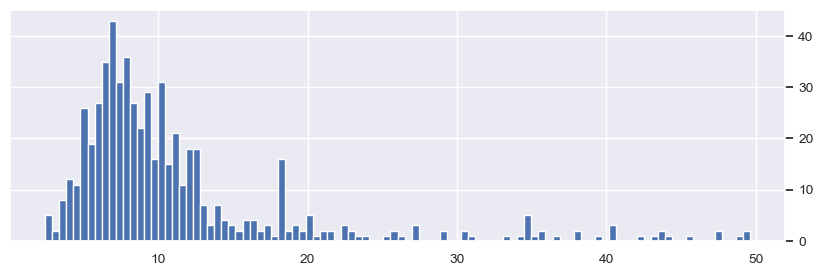


------------------------------------------------
Time Series:WIDTH_LOWER
NUMERICAL


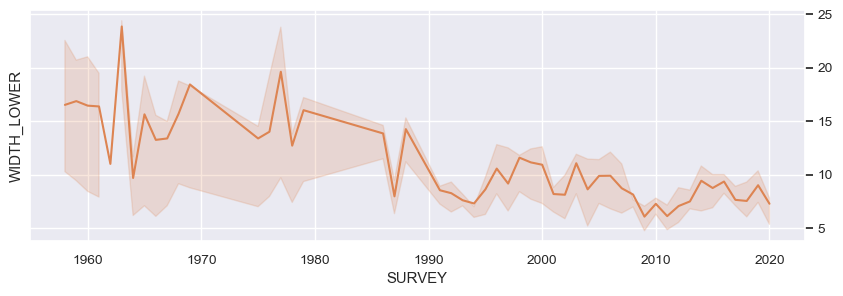





=========================== WIDTH_MIDDLE ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: WIDTH_MIDDLE 

UNIQUE numbers, strings, blanks, null = (92, 0, 0, 1)
number of numeric = 202
number of strings = 0
number of blanks = 0
number of null =  42

--------------------------------------------------
Histogram: WIDTH_MIDDLE
NUMERICAL


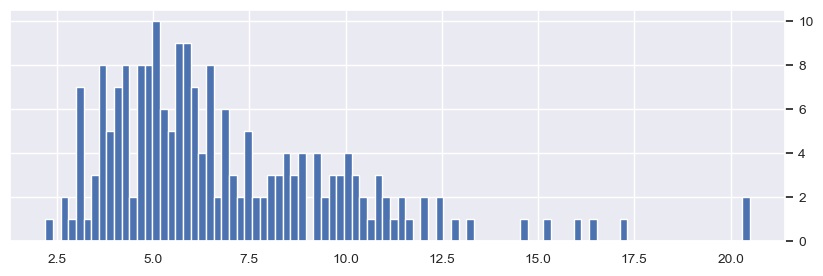


------------------------------------------------
Time Series:WIDTH_MIDDLE
NUMERICAL


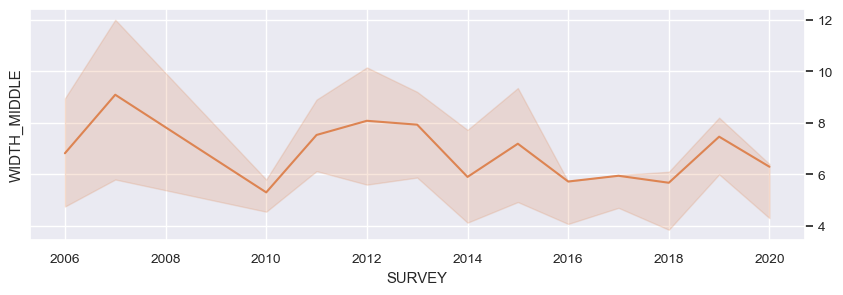


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: WIDTH_MIDDLE 

UNIQUE numbers, strings, blanks, null = (117, 0, 0, 1)
number of numeric = 281
number of strings = 0
number of blanks = 0
number of null =  336

--------------------------------------------------
Histogram: WIDTH_MIDDLE
NUMERICAL


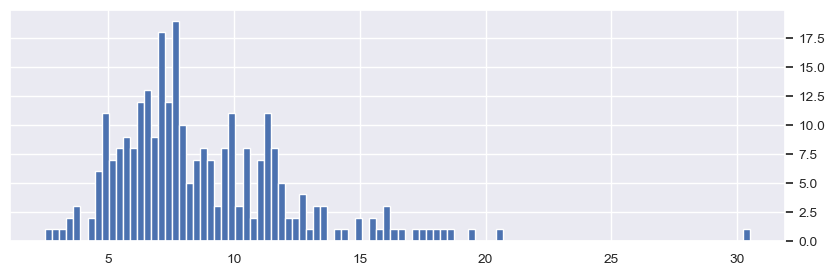


------------------------------------------------
Time Series:WIDTH_MIDDLE
NUMERICAL


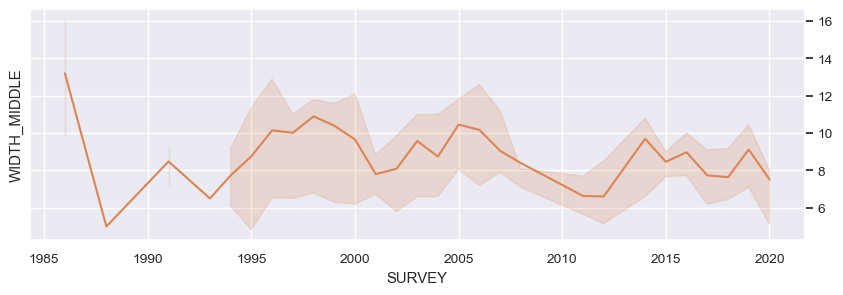





=========================== WIDTH_UPPER ===========================


		<<<<<  GNS  >>>>>

--------------------------------------------------
Data Info: WIDTH_UPPER 

UNIQUE numbers, strings, blanks, null = (95, 0, 0, 1)
number of numeric = 238
number of strings = 0
number of blanks = 0
number of null =  6

--------------------------------------------------
Histogram: WIDTH_UPPER
NUMERICAL


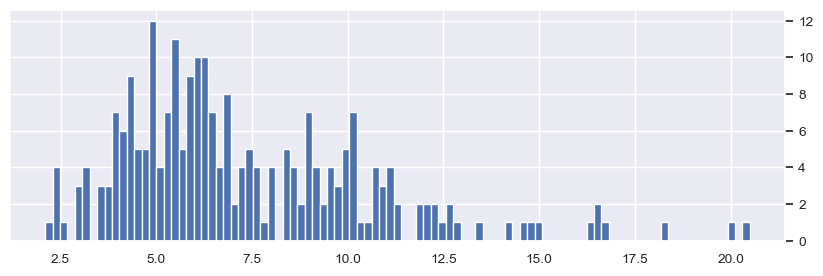


------------------------------------------------
Time Series:WIDTH_UPPER
NUMERICAL


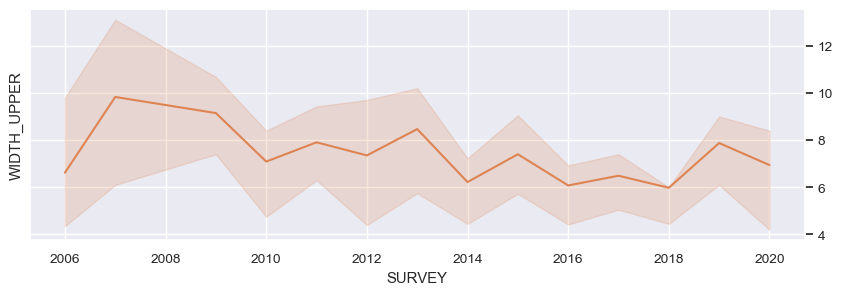


		<<<<<  MARGAREE  >>>>>

--------------------------------------------------
Data Info: WIDTH_UPPER 

UNIQUE numbers, strings, blanks, null = (247, 0, 0, 1)
number of numeric = 575
number of strings = 0
number of blanks = 0
number of null =  42

--------------------------------------------------
Histogram: WIDTH_UPPER
NUMERICAL


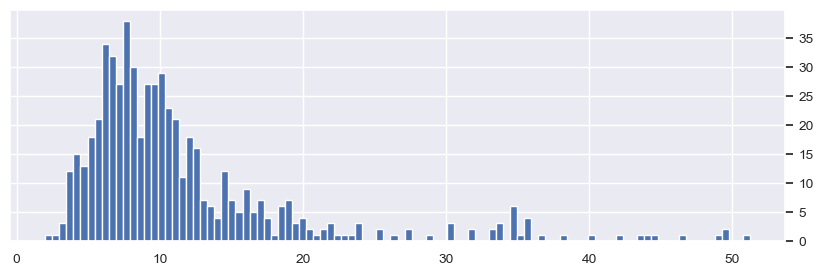


------------------------------------------------
Time Series:WIDTH_UPPER
NUMERICAL


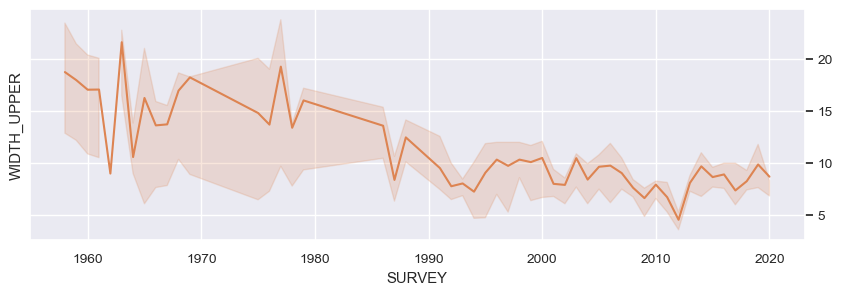

In [80]:
dont_plot_these_columns = sorted(['REMARK'] + [x for x in df_gsite.columns if x[0:4]=='FLAG'] + [x for x in df_msite.columns if x[0:4]=='FLAG'])
dfg = df_gsite[df_gsite.nunique()[df_gsite.nunique()>0].index].drop(['SITE_EVENT_DATE'], axis=1)
dfm = df_msite[df_msite.nunique()[df_msite.nunique()>0].index].drop(['TIME_TEMP1', 'SITE_EVENT_DATE'], axis=1)

plot_these_columns = sorted([x for x in set(list(dfg.columns) + list(dfm.columns)) if x not in dont_plot_these_columns])
missing_from_gns = [x for x in dfm.columns if x not in dfg.columns]
missing_from_mar = [x for x in dfg.columns if x not in dfm.columns]

for col in dont_plot_these_columns:
    print(f'\n\n\n\n=========================== {col.upper()} ===========================\n')
    print('\n\t\t<<<<<  GNS  >>>>>\n')
    if col in missing_from_gns:
        print('--------------------------------------------------\nCOLUMN MISSING OR NULL:', col)
    else:
        print_data_info(dfg, col)
    print('\n\t\t<<<<<  MARGAREE  >>>>>\n')
    if col in missing_from_mar:
        print('--------------------------------------------------\nCOLUMN MISSING OR NULL:', col)
    else:
        print_data_info(dfm, col)
for col in plot_these_columns:
    print(f'\n\n\n\n=========================== {col.upper()} ===========================\n')
    print('\n\t\t<<<<<  GNS  >>>>>\n')
    if col in missing_from_gns:
        print('--------------------------------------------------\nCOLUMN MISSING OR NULL:', col)
    else:
        do_EDA_stuff(dfg, col, date_column='SURVEY')
    print('\n\t\t<<<<<  MARGAREE  >>>>>\n')
    if col in missing_from_mar:
        print('--------------------------------------------------\nCOLUMN MISSING OR NULL:', col)
    else:
        do_EDA_stuff(dfm, col, date_column='SURVEY')

# Save Cleaned Data

In [81]:
if False:
    df_gns.to_pickle('df_gns.pickle')
    df_mar.to_pickle('df_mar.pickle')
    df_code.to_pickle('df_code.pickle')
    df_gsite.to_pickle('df_gsite.pickle')
    df_msite.to_pickle('df_msite.pickle')